## Цели работы

Использовать авторегрессионные модели SARIMAX, auto_arima, Prophet, TBATS для прогнозирования временных рядов.

Рассмотреть разные метрики оценки прогнозов: MAPE, MSE, MAE.

## Датасет 

https://www.kaggle.com/c/demand-forecasting-kernels-only/overview

In [37]:
import numpy as np
import pandas as pd
import optuna
import os

# plotting
import matplotlib.pyplot as plt
## make plots bigger
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
from tbats import TBATS
from prophet import Prophet
from pmdarima import auto_arima


def plot_results(y_to_train,
                 y_to_test, y_forecast,
                 plot_conf_int=True,
                 left_bound=None, right_bound=None):

    plt.plot(y_to_train, label='train')
    plt.plot(y_to_test, label='test')
    plt.plot(y_to_test.index, y_forecast, label='prediction')

    if plot_conf_int:
        plt.fill_between(y_to_test.index,
                         left_bound, right_bound,
                         alpha=0.23, color='grey',
                         label='intervals')
    plt.legend()
    plt.show()

## Prophet, SARIMAX, TBATS — модели для предсказания временных рядов

In [2]:
root_path =  'D:\ML\LS\MLA\Time_series\practice'
data_path = os.path.join(root_path, 'train.csv') 
data = pd.read_csv('train.csv', parse_dates=['date'])
data.head()

date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

In [3]:
store, item = 1,1
data = data[(data['store'] == store) & (data['item'] == item)]
data = data.set_index('date')
data = data['sales']

In [4]:
data

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2017-12-27    14
2017-12-28    19
2017-12-29    15
2017-12-30    27
2017-12-31    23
Name: sales, Length: 1826, dtype: int64

### Данные
Разделим данные на train и test. test — данные за последний год.

In [5]:
test_size = 365
data_train = data.iloc[: -test_size]
data_test  = data.iloc[-test_size:]

### Визуализируем данные.

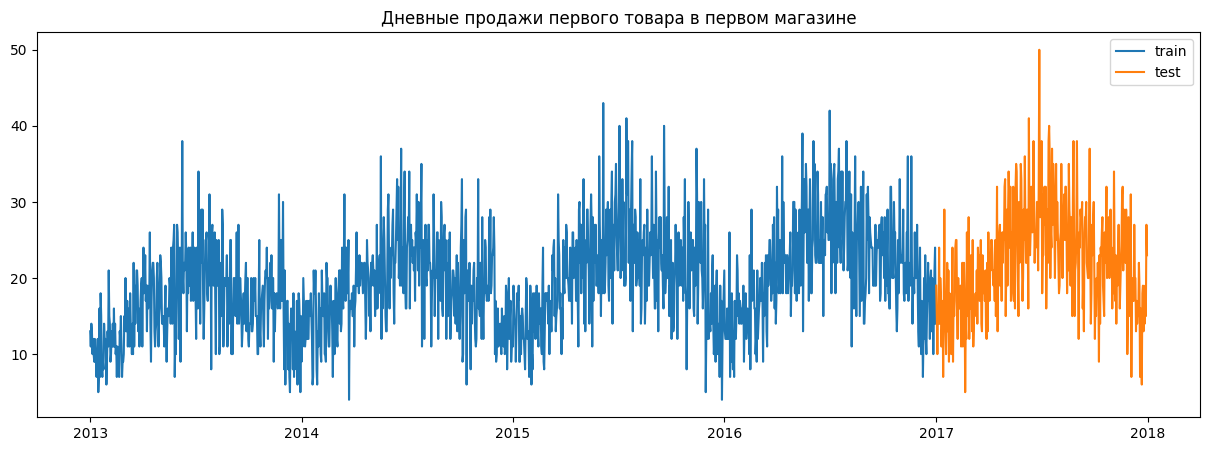

In [6]:
plt.figure(figsize=(15, 5))

plt.title('Дневные продажи первого товара в первом магазине')

plt.plot(data_train, label='train')
plt.plot(data_test, label='test')
plt.legend()

### Имеется некоторая недельная сезонность.

### Метрики
Зададим метрики качества моделей: MSE, MAE, MAPE. Зададим функцию, которая будет вычислять метрики качества моделей и записывать их в таблицу.

In [7]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred) -> float:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
def add_method_comparison(method: str, y_true, y_forecast, compare_table=None) -> pd.DataFrame:
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast)
    }

    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table

### Prophet

In [9]:
prophet_train_df = pd.DataFrame(data_train)

prophet_train_df.columns = ['y']
prophet_train_df['ds'] = prophet_train_df.index

In [10]:
prophet_train_df

y         ds
date                     
2013-01-01  13 2013-01-01
2013-01-02  11 2013-01-02
2013-01-03  14 2013-01-03
2013-01-04  13 2013-01-04
2013-01-05  10 2013-01-05
...         ..        ...
2016-12-27  10 2016-12-27
2016-12-28  16 2016-12-28
2016-12-29  21 2016-12-29
2016-12-30  24 2016-12-30
2016-12-31  14 2016-12-31

[1461 rows x 2 columns]

In [11]:
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(prophet_train_df)

future = prophet_model.make_future_dataframe(
    periods=test_size, include_history=False
)

y_prophet_forecast = prophet_model.predict(future)

13:26:26 - cmdstanpy - INFO - Chain [1] start processing
13:26:27 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
y_prophet_forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2017-01-01  22.656367   12.412708   30.173083    22.656367    22.656367   
1 2017-01-02  22.660412    4.439778   21.703123    22.660412    22.660412   
2 2017-01-03  22.664457    7.383629   24.550525    22.664457    22.664457   
3 2017-01-04  22.668502    7.681927   24.613001    22.668472    22.668510   
4 2017-01-05  22.672547    7.588161   25.371003    22.672487    22.672572   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0       -1.504747             -1.504747             -1.504747  3.723810   
1       -9.438711             -9.438711             -9.438711 -4.232954   
2       -6.836088             -6.836088             -6.836088 -1.636037   
3       -6.324862             -6.324862             -6.324862 -1.114510   
4       -5.942896             -5.942896             -5.942896 -0.707795   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      3.723810      3.723810 -5.228557     -5.228557     -5.228557   
1     -4.232954     -4.232954 -5.205757     -5.205757     -5.205757   
2     -1.636037     -1.636037 -5.200051     -5.200051     -5.200051   
3     -1.114510     -1.114510 -5.210352     -5.210352     -5.210352   
4     -0.707795     -0.707795 -5.235101     -5.235101     -5.235101   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  21.151621  
1                         0.0  13.221701  
2                         0.0  15.828369  
3                         0.0  16.343640  
4                         0.0  16.729651

Модель для каждой даты раскладывает своё предсказание на компоненты.

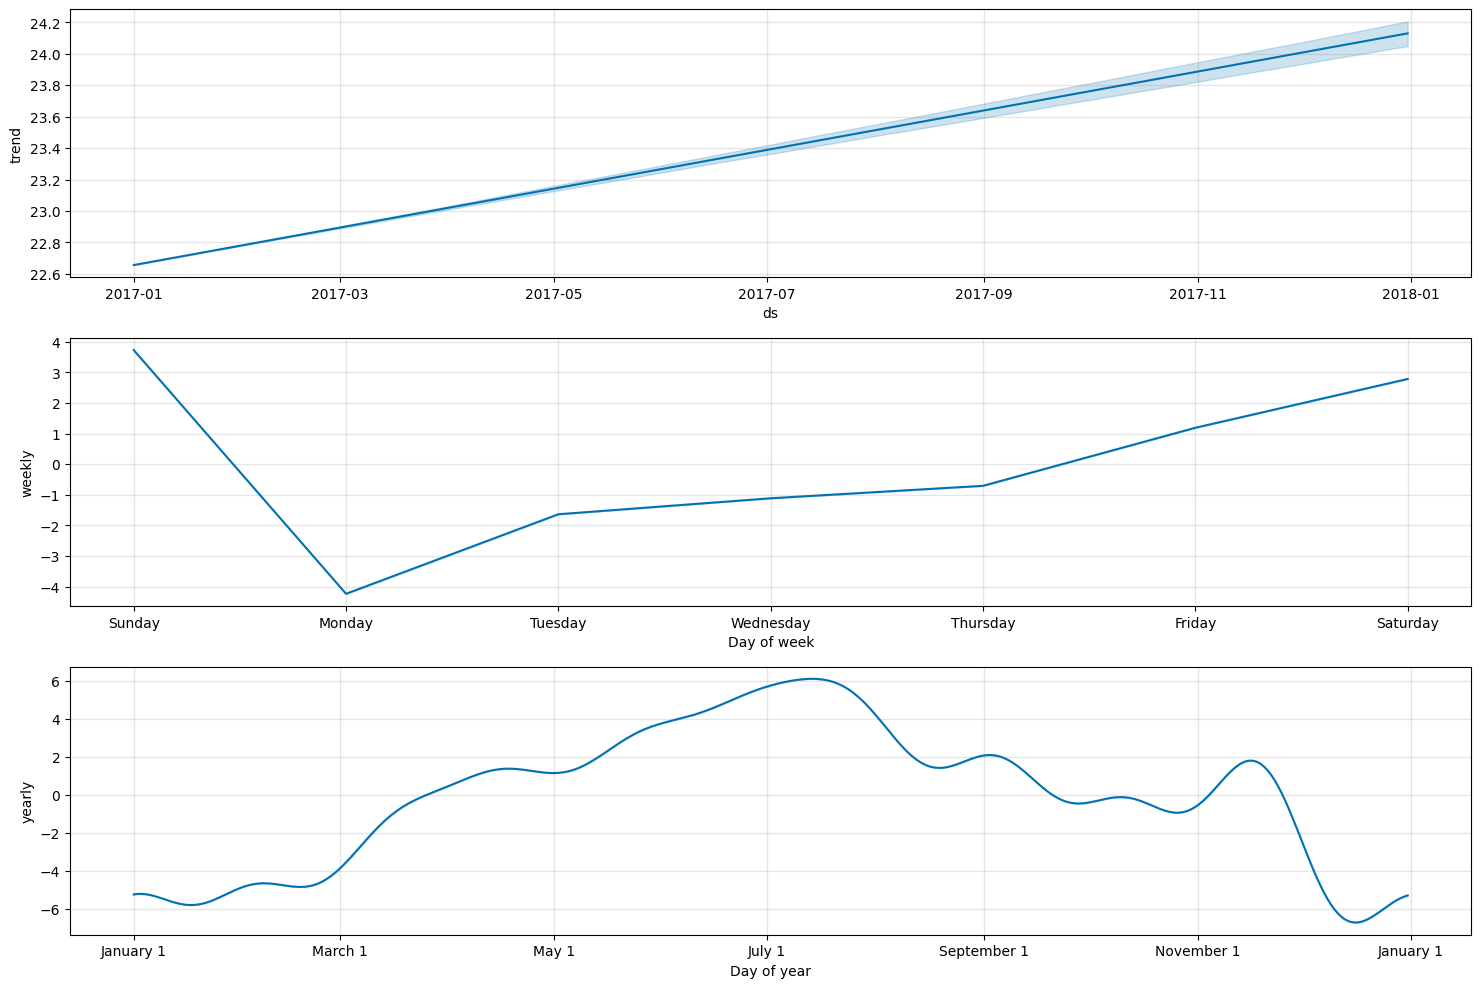

In [13]:
prophet_model.plot_components(y_prophet_forecast, figsize=(15, 10))
plt.show()

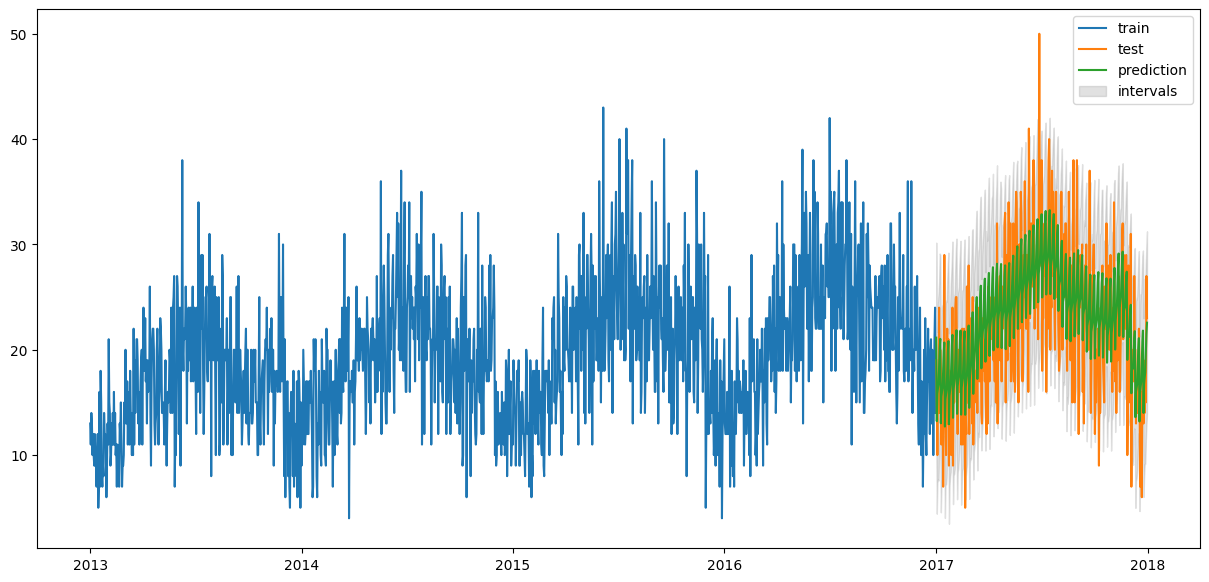

In [14]:
plot_results(data_train, data_test, y_prophet_forecast['yhat'], plot_conf_int=True,
             left_bound=y_prophet_forecast['yhat_lower'],
             right_bound=y_prophet_forecast['yhat_upper'])

In [15]:
compare_table = add_method_comparison('Prophet', data_test, y_prophet_forecast['yhat'])
compare_table

method        MSE       MAE       MAPE
0  Prophet  24.681247  4.032164  22.234031

### Prophet + US holidays

In [17]:
from prophet.make_holidays import make_holidays_df

prophet_model_holidays = Prophet(interval_width=0.95)
prophet_model_holidays.add_country_holidays(country_name='US')
prophet_model_holidays.fit(prophet_train_df)

future = prophet_model_holidays.make_future_dataframe(periods=test_size, include_history=False)
y_prophet_holidays_forecast = prophet_model_holidays.predict(future)
compare_table = add_method_comparison('Prophet + US holidays', data_test, y_prophet_holidays_forecast['yhat'], compare_table)
compare_table

13:29:36 - cmdstanpy - INFO - Chain [1] start processing
13:29:36 - cmdstanpy - INFO - Chain [1] done processing


method        MSE       MAE       MAPE
0                Prophet  24.681247  4.032164  22.234031
1  Prophet + US holidays  25.021721  4.068054  22.477342

### Prophet. Преобразование Бокса — Кокса

In [22]:
from scipy import stats as sps

df = prophet_train_df.reset_index()

# Оставить только 'ds' и 'y'
df_for_prophet = df[['ds', 'y_boxcox']].rename(columns={'y_boxcox': 'y'})

# Убедиться, что 'ds' — datetime
df_for_prophet['ds'] = pd.to_datetime(df_for_prophet['ds'])

In [24]:
prophet_model_boxcox = Prophet(interval_width=0.95)
prophet_model_boxcox.fit(df_for_prophet)

13:37:13 - cmdstanpy - INFO - Chain [1] start processing
13:37:13 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# Сгенерировать будущие даты для теста (periods = длина теста)
future = prophet_model_boxcox.make_future_dataframe(periods=len(data_test), include_history=False)
# Сделать прогноз
y_prophet_boxcox_forecast = prophet_model_boxcox.predict(future)

In [26]:
# Используем то же значение lmbda, что и при fit (полученное из sps.boxcox)

def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.power(lmbda * y + 1, 1 / lmbda)

# Применяем обратное преобразование к прогнозу
y_pred = inv_boxcox(y_prophet_boxcox_forecast['yhat'].values, lmbda)

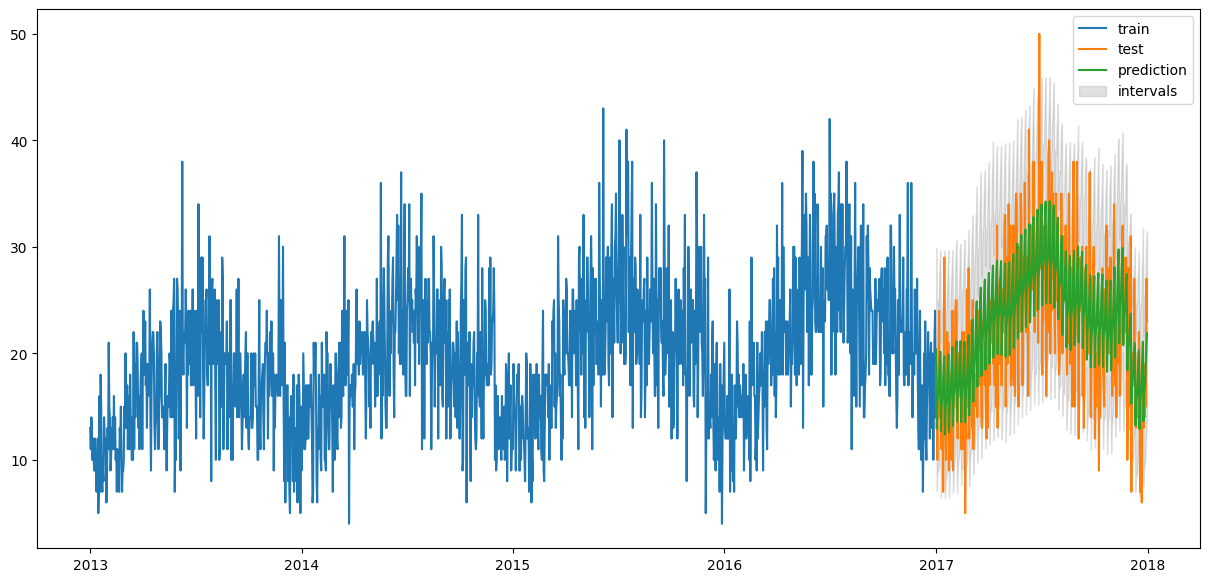

In [29]:
left_bound = inv_boxcox(y_prophet_boxcox_forecast['yhat_lower'].values, lmbda)
right_bound = inv_boxcox(y_prophet_boxcox_forecast['yhat_upper'].values, lmbda)
plot_results(data_train, data_test, y_pred, plot_conf_int=True, left_bound=left_bound, right_bound=right_bound)

In [27]:
compare_table = add_method_comparison('Prophet + BoxCox', data_test, y_pred, compare_table)
print(compare_table)

                  method        MSE       MAE       MAPE
0                Prophet  24.681247  4.032164  22.234031
1  Prophet + US holidays  25.021721  4.068054  22.477342
2       Prophet + BoxCox  24.119069  3.987960  21.686104


### Prophet + Box-Cox (для выравнивания распределения) + US holidays (для особых дней) + Сезонности 7 и 365

13:41:33 - cmdstanpy - INFO - Chain [1] start processing
13:41:33 - cmdstanpy - INFO - Chain [1] done processing


                                      method        MSE       MAE       MAPE
0                                    Prophet  24.681247  4.032164  22.234031
1                      Prophet + US holidays  25.021721  4.068054  22.477342
2                           Prophet + BoxCox  24.119069  3.987960  21.686104
3  Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946


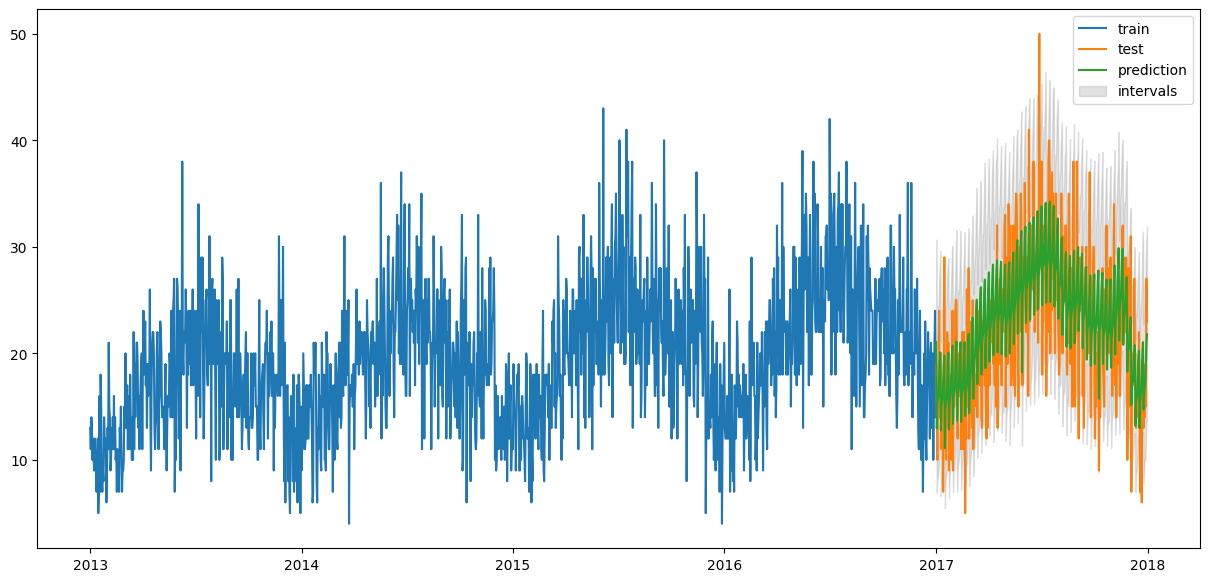

In [31]:
# Преобразование Box-Cox на train
df = prophet_train_df.reset_index()
df_for_prophet = df[['ds', 'y_boxcox']].rename(columns={'y_boxcox': 'y'})
df_for_prophet['ds'] = pd.to_datetime(df_for_prophet['ds'])

# Prophet с holidays и двумя кастомными сезонностями
prophet_model_full = Prophet(interval_width=0.95)
prophet_model_full.add_country_holidays(country_name='US')
prophet_model_full.add_seasonality(name='weekly', period=7, fourier_order=5)
prophet_model_full.add_seasonality(name='yearly', period=365, fourier_order=10)

prophet_model_full.fit(df_for_prophet)

# Прогноз
future = prophet_model_full.make_future_dataframe(periods=len(data_test), include_history=False)
y_prophet_full_forecast = prophet_model_full.predict(future)

# Инверсия Box-Cox для yhat 
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.power(lmbda * y + 1, 1 / lmbda)

y_pred = inv_boxcox(y_prophet_full_forecast['yhat'].values, lmbda)
left_bound = inv_boxcox(y_prophet_full_forecast['yhat_lower'].values, lmbda)
right_bound = inv_boxcox(y_prophet_full_forecast['yhat_upper'].values, lmbda)

# Метрики
compare_table = add_method_comparison('Prophet + BoxCox + holidays + seasonality', data_test, y_pred, compare_table)
print(compare_table)

# Визуализация
plot_results(data_train, data_test, y_pred, plot_conf_int=True, left_bound=left_bound, right_bound=right_bound)

In [32]:
# Prophet: только годовая сезонность
prophet_model_yearly = Prophet(interval_width=0.95)
prophet_model_yearly.add_country_holidays(country_name='US')
prophet_model_yearly.add_seasonality(name='yearly', period=365, fourier_order=10)

prophet_model_yearly.fit(df_for_prophet)

future = prophet_model_yearly.make_future_dataframe(periods=len(data_test), include_history=False)
y_prophet_yearly_forecast = prophet_model_yearly.predict(future)

y_pred_yearly = inv_boxcox(y_prophet_yearly_forecast['yhat'].values, lmbda)

compare_table = add_method_comparison('Prophet + BoxCox + holidays + yearly', data_test, y_pred_yearly, compare_table)
print(compare_table)

13:44:35 - cmdstanpy - INFO - Chain [1] start processing
13:44:35 - cmdstanpy - INFO - Chain [1] done processing


                                      method        MSE       MAE       MAPE
0                                    Prophet  24.681247  4.032164  22.234031
1                      Prophet + US holidays  25.021721  4.068054  22.477342
2                           Prophet + BoxCox  24.119069  3.987960  21.686104
3  Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4       Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265


In [33]:
# Prophet: только недельная сезонность
prophet_model_weekly = Prophet(interval_width=0.95)
prophet_model_weekly.add_country_holidays(country_name='US')
prophet_model_weekly.add_seasonality(name='weekly', period=7, fourier_order=5)

prophet_model_weekly.fit(df_for_prophet)

future = prophet_model_weekly.make_future_dataframe(periods=len(data_test), include_history=False)
y_prophet_weekly_forecast = prophet_model_weekly.predict(future)

y_pred_weekly = inv_boxcox(y_prophet_weekly_forecast['yhat'].values, lmbda)

compare_table = add_method_comparison('Prophet + BoxCox + holidays + weekly', data_test, y_pred_weekly, compare_table)
print(compare_table)

13:44:50 - cmdstanpy - INFO - Chain [1] start processing
13:44:50 - cmdstanpy - INFO - Chain [1] done processing


                                      method        MSE       MAE       MAPE
0                                    Prophet  24.681247  4.032164  22.234031
1                      Prophet + US holidays  25.021721  4.068054  22.477342
2                           Prophet + BoxCox  24.119069  3.987960  21.686104
3  Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4       Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5       Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060


In [34]:
prophet_model_high_fourier = Prophet(
    interval_width=0.95,
    seasonality_prior_scale=10,     # повысить гибкость сезонности
    holidays_prior_scale=10         # повысить влияние праздников
)
prophet_model_high_fourier.add_country_holidays(country_name='US')
prophet_model_high_fourier.add_seasonality(name='weekly', period=7, fourier_order=10)
prophet_model_high_fourier.add_seasonality(name='yearly', period=365, fourier_order=20)

prophet_model_high_fourier.fit(df_for_prophet)
future = prophet_model_high_fourier.make_future_dataframe(periods=len(data_test), include_history=False)
y_prophet_high_fourier_forecast = prophet_model_high_fourier.predict(future)
y_pred_high_fourier = inv_boxcox(y_prophet_high_fourier_forecast['yhat'].values, lmbda)
compare_table = add_method_comparison('Prophet + BoxCox + holidays + hi-fourier', data_test, y_pred_high_fourier, compare_table)
print(compare_table)

13:46:04 - cmdstanpy - INFO - Chain [1] start processing
13:46:04 - cmdstanpy - INFO - Chain [1] done processing


                                      method        MSE       MAE       MAPE
0                                    Prophet  24.681247  4.032164  22.234031
1                      Prophet + US holidays  25.021721  4.068054  22.477342
2                           Prophet + BoxCox  24.119069  3.987960  21.686104
3  Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4       Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5       Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6   Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862


In [36]:
prophet_model_flex = Prophet(
    interval_width=0.95,
    seasonality_prior_scale=25,
    holidays_prior_scale=25
)
prophet_model_flex.add_country_holidays(country_name='US')
prophet_model_flex.add_seasonality(name='weekly', period=7, fourier_order=12)
prophet_model_flex.add_seasonality(name='yearly', period=365, fourier_order=30)
prophet_model_flex.fit(df_for_prophet)
future = prophet_model_flex.make_future_dataframe(periods=len(data_test), include_history=False)
y_flex = prophet_model_flex.predict(future)
y_pred_flex = inv_boxcox(y_flex['yhat'].values, lmbda)
compare_table = add_method_comparison('Prophet + BoxCox + holidays + flex', data_test, y_pred_flex, compare_table)
print(compare_table)

13:47:24 - cmdstanpy - INFO - Chain [1] start processing
13:47:24 - cmdstanpy - INFO - Chain [1] done processing


                                      method        MSE       MAE       MAPE
0                                    Prophet  24.681247  4.032164  22.234031
1                      Prophet + US holidays  25.021721  4.068054  22.477342
2                           Prophet + BoxCox  24.119069  3.987960  21.686104
3  Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4       Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5       Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6   Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862
7         Prophet + BoxCox + holidays + flex  24.975915  4.079037  22.155363


## Подбор оптуной

In [40]:
# Box-Cox преобразование train (и отдельно test)
y_train_bc, lmbda = sps.boxcox(data_train.values)
y_test_bc = sps.boxcox(data_test.values, lmbda=lmbda)

def objective(trial):
    try:
        # === Гиперпараметры Prophet
        seasonality_mode = trial.suggest_categorical("seasonality_mode", ["additive", "multiplicative"])
        seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 5.0, 40.0)
        changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.001, 0.5)
        changepoint_range = trial.suggest_float("changepoint_range", 0.8, 0.95)
        holidays_prior_scale = trial.suggest_float("holidays_prior_scale", 0.0, 20.0)

        weekly_fourier = trial.suggest_int("weekly_fourier_order", 3, 15)
        monthly_fourier = trial.suggest_int("monthly_fourier_order", 3, 10)
        quarterly_fourier = trial.suggest_int("quarterly_fourier_order", 3, 10)
        halfyearly_fourier = trial.suggest_int("halfyearly_fourier_order", 3, 8)

        use_weekly_default = trial.suggest_categorical("use_weekly_default", [True, False])
        use_yearly_default = trial.suggest_categorical("use_yearly_default", [True, False])
        use_holidays = trial.suggest_categorical("add_holidays", [True, False])
        use_quarterly = trial.suggest_categorical("add_quarterly", [True, False])
        use_halfyearly = trial.suggest_categorical("add_halfyearly", [True, False])
        use_changepoints = trial.suggest_categorical("use_changepoints", [True, False])

        if use_changepoints:
            n_changepoints = trial.suggest_int("n_changepoints", 25, 100)
        else:
            n_changepoints = 25

        # Подготовка df с Box-Cox
        prophet_train_df = pd.DataFrame({'ds': data_train.index, 'y': y_train_bc})

        # Prophet-модель
        model = Prophet(
            seasonality_mode=seasonality_mode,
            seasonality_prior_scale=seasonality_prior_scale,
            changepoint_prior_scale=changepoint_prior_scale,
            changepoint_range=changepoint_range,
            holidays_prior_scale=holidays_prior_scale,
            weekly_seasonality=use_weekly_default,
            yearly_seasonality=use_yearly_default,
            daily_seasonality=False,
            n_changepoints=n_changepoints
        )
        if use_holidays:
            model.add_country_holidays(country_name='US')
        model.add_seasonality(name='weekly_custom', period=7, fourier_order=weekly_fourier)
        model.add_seasonality(name='monthly_custom', period=30.5, fourier_order=monthly_fourier)
        if use_quarterly:
            model.add_seasonality(name='quarterly', period=91.3, fourier_order=quarterly_fourier)
        if use_halfyearly:
            model.add_seasonality(name='halfyearly', period=182.6, fourier_order=halfyearly_fourier)

        model.fit(prophet_train_df)

        # Прогноз
        future = model.make_future_dataframe(periods=len(data_test), freq='D', include_history=False)
        forecast = model.predict(future)
        y_pred_bc = forecast['yhat'].values

        # Обратное преобразование для прогноза
        y_pred = inv_boxcox(y_pred_bc, lmbda)

        # Метрика — сравниваем с реальными (сырыми) значениями data_test
        mape = mean_absolute_percentage_error(data_test.values, y_pred)

        print(f"[Trial {trial.number}] MAPE={mape:.2f} | changepoint_range={changepoint_range:.3f}")

        return mape

    except Exception as e:
        print(f"[Trial {trial.number}] Ошибка: {e}")
        return float("inf")

# Запуск Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500, show_progress_bar=True)

# Лучшие параметры
print("\nBest trial:")
print(f"{study.best_value:.4f}")
print("Params:", study.best_params)

[I 2025-07-29 13:58:00,748] A new study created in memory with name: no-name-3c8e316a-303c-449c-8e02-052fcb789596


  0%|          | 0/500 [00:00<?, ?it/s]

13:58:01 - cmdstanpy - INFO - Chain [1] start processing
13:58:02 - cmdstanpy - INFO - Chain [1] done processing


[Trial 0] MAPE=42.30 | changepoint_range=0.833
[I 2025-07-29 13:58:02,285] Trial 0 finished with value: 42.297054377251634 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 26.418194818264656, 'changepoint_prior_scale': 0.4668393455288111, 'changepoint_range': 0.8327469923219044, 'holidays_prior_scale': 3.4346348917135483, 'weekly_fourier_order': 10, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': False, 'add_quarterly': True, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 0 with value: 42.297054377251634.


13:58:02 - cmdstanpy - INFO - Chain [1] start processing
13:58:04 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\555\AppData\Local\Temp\ipykernel_5172\2306105651.py:23: RuntimeWarning: invalid value encountered in power
  return np.power(lmbda * y + 1, 1 / lmbda)


[Trial 1] MAPE=nan | changepoint_range=0.949
[W 2025-07-29 13:58:04,415] Trial 1 failed with parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.00894022848264, 'changepoint_prior_scale': 0.46842979879547175, 'changepoint_range': 0.9486068408860996, 'holidays_prior_scale': 0.8658566278103552, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 98} because of the following error: The value nan is not acceptable.
[W 2025-07-29 13:58:04,416] Trial 1 failed with value nan.


13:58:04 - cmdstanpy - INFO - Chain [1] start processing
13:58:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 2] MAPE=30.56 | changepoint_range=0.817
[I 2025-07-29 13:58:05,307] Trial 2 finished with value: 30.561175567104783 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.184759094712973, 'changepoint_prior_scale': 0.40564798889545267, 'changepoint_range': 0.8167783866291702, 'holidays_prior_scale': 3.6418649874640563, 'weekly_fourier_order': 11, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': False, 'add_holidays': False, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 2 with value: 30.561175567104783.


13:58:05 - cmdstanpy - INFO - Chain [1] start processing
13:58:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 3] MAPE=21.24 | changepoint_range=0.932
[I 2025-07-29 13:58:06,084] Trial 3 finished with value: 21.243233121757633 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.087722051268, 'changepoint_prior_scale': 0.05788377025348555, 'changepoint_range': 0.9318685078149307, 'holidays_prior_scale': 13.748688505653288, 'weekly_fourier_order': 9, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 3 with value: 21.243233121757633.


13:58:06 - cmdstanpy - INFO - Chain [1] start processing
13:58:07 - cmdstanpy - INFO - Chain [1] done processing


[Trial 4] MAPE=64.58 | changepoint_range=0.940
[I 2025-07-29 13:58:07,127] Trial 4 finished with value: 64.58484881822835 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 28.47596649853235, 'changepoint_prior_scale': 0.4039208313139241, 'changepoint_range': 0.9398140901381528, 'holidays_prior_scale': 19.387179035012743, 'weekly_fourier_order': 8, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 71}. Best is trial 3 with value: 21.243233121757633.


13:58:07 - cmdstanpy - INFO - Chain [1] start processing
13:58:07 - cmdstanpy - INFO - Chain [1] done processing


[Trial 5] MAPE=21.10 | changepoint_range=0.814
[I 2025-07-29 13:58:08,002] Trial 5 finished with value: 21.102868419947118 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 26.543770086497776, 'changepoint_prior_scale': 0.476601925124208, 'changepoint_range': 0.8142557657721714, 'holidays_prior_scale': 19.178700143462137, 'weekly_fourier_order': 11, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 10, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 59}. Best is trial 5 with value: 21.102868419947118.


13:58:08 - cmdstanpy - INFO - Chain [1] start processing
13:58:08 - cmdstanpy - INFO - Chain [1] done processing


[Trial 6] MAPE=20.10 | changepoint_range=0.863
[I 2025-07-29 13:58:08,848] Trial 6 finished with value: 20.09867282834047 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 17.57335944623076, 'changepoint_prior_scale': 0.43475399240916884, 'changepoint_range': 0.8632756937059375, 'holidays_prior_scale': 12.59035494405066, 'weekly_fourier_order': 10, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:09 - cmdstanpy - INFO - Chain [1] start processing
13:58:09 - cmdstanpy - INFO - Chain [1] done processing


[Trial 7] MAPE=27.23 | changepoint_range=0.809
[I 2025-07-29 13:58:09,277] Trial 7 finished with value: 27.233670142307144 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 32.296227182227064, 'changepoint_prior_scale': 0.0013800733061170283, 'changepoint_range': 0.8089940262579833, 'holidays_prior_scale': 8.131430022693099, 'weekly_fourier_order': 5, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': False, 'add_holidays': False, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:09 - cmdstanpy - INFO - Chain [1] start processing
13:58:09 - cmdstanpy - INFO - Chain [1] done processing


[Trial 8] MAPE=22.31 | changepoint_range=0.856
[I 2025-07-29 13:58:09,912] Trial 8 finished with value: 22.306297979635776 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 33.21282626518533, 'changepoint_prior_scale': 0.004048077741877472, 'changepoint_range': 0.8557621464864394, 'holidays_prior_scale': 7.518000380914707, 'weekly_fourier_order': 7, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 10, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 41}. Best is trial 6 with value: 20.09867282834047.


13:58:10 - cmdstanpy - INFO - Chain [1] start processing
13:58:11 - cmdstanpy - INFO - Chain [1] done processing


[Trial 9] MAPE=60.87 | changepoint_range=0.917
[I 2025-07-29 13:58:12,098] Trial 9 finished with value: 60.869249626919895 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 33.1116472677534, 'changepoint_prior_scale': 0.3139695693338177, 'changepoint_range': 0.9174891323899506, 'holidays_prior_scale': 1.2553720342767982, 'weekly_fourier_order': 8, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 38}. Best is trial 6 with value: 20.09867282834047.


13:58:12 - cmdstanpy - INFO - Chain [1] start processing
13:58:12 - cmdstanpy - INFO - Chain [1] done processing


[Trial 10] MAPE=30.59 | changepoint_range=0.820
[I 2025-07-29 13:58:12,886] Trial 10 finished with value: 30.586021950096036 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 23.693541897100346, 'changepoint_prior_scale': 0.38773085057857776, 'changepoint_range': 0.8196683944145795, 'holidays_prior_scale': 5.663901805258778, 'weekly_fourier_order': 14, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:13 - cmdstanpy - INFO - Chain [1] start processing
13:58:13 - cmdstanpy - INFO - Chain [1] done processing


[Trial 11] MAPE=20.74 | changepoint_range=0.893
[I 2025-07-29 13:58:13,424] Trial 11 finished with value: 20.737135114624348 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15.704190856416243, 'changepoint_prior_scale': 0.14823514435248136, 'changepoint_range': 0.8925021712970906, 'holidays_prior_scale': 12.816795863025515, 'weekly_fourier_order': 3, 'monthly_fourier_order': 3, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:13 - cmdstanpy - INFO - Chain [1] start processing
13:58:13 - cmdstanpy - INFO - Chain [1] done processing


[Trial 12] MAPE=20.74 | changepoint_range=0.890
[I 2025-07-29 13:58:13,946] Trial 12 finished with value: 20.740543771570806 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 14.880865451587432, 'changepoint_prior_scale': 0.1408888674087217, 'changepoint_range': 0.8899363186630491, 'holidays_prior_scale': 12.869601091720167, 'weekly_fourier_order': 3, 'monthly_fourier_order': 3, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:14 - cmdstanpy - INFO - Chain [1] start processing
13:58:14 - cmdstanpy - INFO - Chain [1] done processing


[Trial 13] MAPE=20.58 | changepoint_range=0.888
[I 2025-07-29 13:58:14,616] Trial 13 finished with value: 20.583013624434763 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15.991458673417302, 'changepoint_prior_scale': 0.19989532660077505, 'changepoint_range': 0.8879554991598467, 'holidays_prior_scale': 12.76996918482363, 'weekly_fourier_order': 14, 'monthly_fourier_order': 3, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 7, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:15 - cmdstanpy - INFO - Chain [1] start processing
13:58:15 - cmdstanpy - INFO - Chain [1] done processing


[Trial 14] MAPE=20.50 | changepoint_range=0.856
[I 2025-07-29 13:58:15,410] Trial 14 finished with value: 20.499772530756314 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15.627791806662612, 'changepoint_prior_scale': 0.28333802320426593, 'changepoint_range': 0.8560831121652488, 'holidays_prior_scale': 16.023655678728957, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 7, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:15 - cmdstanpy - INFO - Chain [1] start processing
13:58:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 15] MAPE=20.90 | changepoint_range=0.852
[I 2025-07-29 13:58:16,323] Trial 15 finished with value: 20.899116544182466 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.543064919915427, 'changepoint_prior_scale': 0.28853792267675615, 'changepoint_range': 0.8522798914436557, 'holidays_prior_scale': 17.204509833396052, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 9, 'halfyearly_fourier_order': 7, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:16 - cmdstanpy - INFO - Chain [1] start processing
13:58:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 16] MAPE=20.54 | changepoint_range=0.860
[I 2025-07-29 13:58:17,049] Trial 16 finished with value: 20.541007692714288 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20.06245666164667, 'changepoint_prior_scale': 0.3322004000551765, 'changepoint_range': 0.8596776747931144, 'holidays_prior_scale': 15.652024715034777, 'weekly_fourier_order': 12, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:17 - cmdstanpy - INFO - Chain [1] start processing
13:58:17 - cmdstanpy - INFO - Chain [1] done processing


[Trial 17] MAPE=20.52 | changepoint_range=0.872
[I 2025-07-29 13:58:17,735] Trial 17 finished with value: 20.521295535769728 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.866805915205086, 'changepoint_prior_scale': 0.24866812078774123, 'changepoint_range': 0.8721998833405281, 'holidays_prior_scale': 9.956198669317988, 'weekly_fourier_order': 13, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 7, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:18 - cmdstanpy - INFO - Chain [1] start processing
13:58:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 18] MAPE=20.47 | changepoint_range=0.839
[I 2025-07-29 13:58:18,324] Trial 18 finished with value: 20.47142626734529 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 19.798740269754074, 'changepoint_prior_scale': 0.36779836261927024, 'changepoint_range': 0.839373620360749, 'holidays_prior_scale': 15.800971295178975, 'weekly_fourier_order': 6, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:18 - cmdstanpy - INFO - Chain [1] start processing
13:58:19 - cmdstanpy - INFO - Chain [1] done processing


[Trial 19] MAPE=20.37 | changepoint_range=0.838
[I 2025-07-29 13:58:19,170] Trial 19 finished with value: 20.370935905829665 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20.534878731183213, 'changepoint_prior_scale': 0.3644975390014949, 'changepoint_range': 0.8383680134765944, 'holidays_prior_scale': 11.115590844249017, 'weekly_fourier_order': 6, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 94}. Best is trial 6 with value: 20.09867282834047.


13:58:19 - cmdstanpy - INFO - Chain [1] start processing
13:58:19 - cmdstanpy - INFO - Chain [1] done processing


[Trial 20] MAPE=20.47 | changepoint_range=0.836
[I 2025-07-29 13:58:20,080] Trial 20 finished with value: 20.467629302988662 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20.615869796379936, 'changepoint_prior_scale': 0.44185289888650836, 'changepoint_range': 0.8356633906941692, 'holidays_prior_scale': 10.096865924683325, 'weekly_fourier_order': 5, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 100}. Best is trial 6 with value: 20.09867282834047.


13:58:20 - cmdstanpy - INFO - Chain [1] start processing
13:58:20 - cmdstanpy - INFO - Chain [1] done processing


[Trial 21] MAPE=20.46 | changepoint_range=0.907
[I 2025-07-29 13:58:21,025] Trial 21 finished with value: 20.461956254461626 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 23.732412537297098, 'changepoint_prior_scale': 0.35247985600387244, 'changepoint_range': 0.9074278271021331, 'holidays_prior_scale': 10.643926851622735, 'weekly_fourier_order': 9, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 99}. Best is trial 6 with value: 20.09867282834047.


13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:21 - cmdstanpy - INFO - Chain [1] done processing


[Trial 22] MAPE=20.36 | changepoint_range=0.915
[I 2025-07-29 13:58:21,909] Trial 22 finished with value: 20.36274534334016 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 22.877783349322698, 'changepoint_prior_scale': 0.3496810283880698, 'changepoint_range': 0.9153613086145654, 'holidays_prior_scale': 10.350535821922861, 'weekly_fourier_order': 9, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 98}. Best is trial 6 with value: 20.09867282834047.


13:58:22 - cmdstanpy - INFO - Chain [1] start processing
13:58:22 - cmdstanpy - INFO - Chain [1] done processing


[Trial 23] MAPE=20.56 | changepoint_range=0.869
[I 2025-07-29 13:58:22,951] Trial 23 finished with value: 20.55893301054394 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 18.06525078702004, 'changepoint_prior_scale': 0.43352578565544353, 'changepoint_range': 0.8690226648575138, 'holidays_prior_scale': 11.170330804171403, 'weekly_fourier_order': 7, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 82}. Best is trial 6 with value: 20.09867282834047.


13:58:23 - cmdstanpy - INFO - Chain [1] start processing
13:58:24 - cmdstanpy - INFO - Chain [1] done processing


[Trial 24] MAPE=20.10 | changepoint_range=0.905
[I 2025-07-29 13:58:24,295] Trial 24 finished with value: 20.099703529847382 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 22.57480149033413, 'changepoint_prior_scale': 0.4980743201016632, 'changepoint_range': 0.9051575984845194, 'holidays_prior_scale': 7.507555043453277, 'weekly_fourier_order': 10, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 84}. Best is trial 6 with value: 20.09867282834047.


13:58:24 - cmdstanpy - INFO - Chain [1] start processing
13:58:25 - cmdstanpy - INFO - Chain [1] done processing


[Trial 25] MAPE=20.16 | changepoint_range=0.909
[I 2025-07-29 13:58:25,916] Trial 25 finished with value: 20.161879613266994 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 28.341177725196044, 'changepoint_prior_scale': 0.4910533806455331, 'changepoint_range': 0.9089823339097552, 'holidays_prior_scale': 7.65145468350623, 'weekly_fourier_order': 10, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 6, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 81}. Best is trial 6 with value: 20.09867282834047.


13:58:26 - cmdstanpy - INFO - Chain [1] start processing
13:58:26 - cmdstanpy - INFO - Chain [1] done processing


[Trial 26] MAPE=20.77 | changepoint_range=0.900
[I 2025-07-29 13:58:26,986] Trial 26 finished with value: 20.76785243192909 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 30.05612524536545, 'changepoint_prior_scale': 0.4937489277080365, 'changepoint_range': 0.9001829189523001, 'holidays_prior_scale': 7.893230767806102, 'weekly_fourier_order': 11, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 6, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 77}. Best is trial 6 with value: 20.09867282834047.


13:58:27 - cmdstanpy - INFO - Chain [1] start processing
13:58:28 - cmdstanpy - INFO - Chain [1] done processing


[Trial 27] MAPE=20.63 | changepoint_range=0.926
[I 2025-07-29 13:58:28,244] Trial 27 finished with value: 20.633023368826635 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 37.79872866809575, 'changepoint_prior_scale': 0.49570690928329125, 'changepoint_range': 0.9264797490284986, 'holidays_prior_scale': 5.996886853690813, 'weekly_fourier_order': 10, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 59}. Best is trial 6 with value: 20.09867282834047.


13:58:28 - cmdstanpy - INFO - Chain [1] start processing
13:58:29 - cmdstanpy - INFO - Chain [1] done processing


[Trial 28] MAPE=20.60 | changepoint_range=0.949
[I 2025-07-29 13:58:29,190] Trial 28 finished with value: 20.59914823170461 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25.353725977752354, 'changepoint_prior_scale': 0.43111082592467254, 'changepoint_range': 0.9485925873829404, 'holidays_prior_scale': 5.933413103576948, 'weekly_fourier_order': 12, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 82}. Best is trial 6 with value: 20.09867282834047.


13:58:29 - cmdstanpy - INFO - Chain [1] start processing
13:58:30 - cmdstanpy - INFO - Chain [1] done processing


[Trial 29] MAPE=20.51 | changepoint_range=0.883
[I 2025-07-29 13:58:30,311] Trial 29 finished with value: 20.51307897312442 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.942089061498915, 'changepoint_prior_scale': 0.45098672102287174, 'changepoint_range': 0.8828847924114585, 'holidays_prior_scale': 8.799682964701864, 'weekly_fourier_order': 10, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 69}. Best is trial 6 with value: 20.09867282834047.


13:58:30 - cmdstanpy - INFO - Chain [1] start processing
13:58:33 - cmdstanpy - INFO - Chain [1] done processing


[Trial 30] MAPE=64.93 | changepoint_range=0.908
[I 2025-07-29 13:58:33,848] Trial 30 finished with value: 64.92644867187667 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 27.94531196373213, 'changepoint_prior_scale': 0.48668741992752956, 'changepoint_range': 0.9077827897091654, 'holidays_prior_scale': 4.079198540302464, 'weekly_fourier_order': 10, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 87}. Best is trial 6 with value: 20.09867282834047.


13:58:34 - cmdstanpy - INFO - Chain [1] start processing
13:58:34 - cmdstanpy - INFO - Chain [1] done processing


[Trial 31] MAPE=20.63 | changepoint_range=0.875
[I 2025-07-29 13:58:34,737] Trial 31 finished with value: 20.63270770308724 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 30.088183096081337, 'changepoint_prior_scale': 0.46793592062015704, 'changepoint_range': 0.8748945357165916, 'holidays_prior_scale': 0.49846616338966854, 'weekly_fourier_order': 12, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 50}. Best is trial 6 with value: 20.09867282834047.


13:58:35 - cmdstanpy - INFO - Chain [1] start processing
13:58:35 - cmdstanpy - INFO - Chain [1] done processing


[Trial 32] MAPE=20.43 | changepoint_range=0.919
[I 2025-07-29 13:58:35,575] Trial 32 finished with value: 20.433143272240116 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 22.578225096721336, 'changepoint_prior_scale': 0.41519164880271753, 'changepoint_range': 0.9186314005764882, 'holidays_prior_scale': 6.612855572989121, 'weekly_fourier_order': 8, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 89}. Best is trial 6 with value: 20.09867282834047.


13:58:36 - cmdstanpy - INFO - Chain [1] start processing
13:58:36 - cmdstanpy - INFO - Chain [1] done processing


[Trial 33] MAPE=20.26 | changepoint_range=0.904
[I 2025-07-29 13:58:36,733] Trial 33 finished with value: 20.258743872618282 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25.258158258087533, 'changepoint_prior_scale': 0.4589040649450692, 'changepoint_range': 0.9039709590086018, 'holidays_prior_scale': 4.181493297476548, 'weekly_fourier_order': 9, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 92}. Best is trial 6 with value: 20.09867282834047.


13:58:37 - cmdstanpy - INFO - Chain [1] start processing
13:58:37 - cmdstanpy - INFO - Chain [1] done processing


[Trial 34] MAPE=20.47 | changepoint_range=0.904
[I 2025-07-29 13:58:37,899] Trial 34 finished with value: 20.468343821586647 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25.619152798136376, 'changepoint_prior_scale': 0.4599266947925725, 'changepoint_range': 0.9035680089195521, 'holidays_prior_scale': 2.5519475677255947, 'weekly_fourier_order': 9, 'monthly_fourier_order': 3, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 74}. Best is trial 6 with value: 20.09867282834047.


13:58:38 - cmdstanpy - INFO - Chain [1] start processing
13:58:39 - cmdstanpy - INFO - Chain [1] done processing


[Trial 35] MAPE=64.64 | changepoint_range=0.897
[I 2025-07-29 13:58:39,330] Trial 35 finished with value: 64.63685011000078 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 28.97154648969708, 'changepoint_prior_scale': 0.3999626235559729, 'changepoint_range': 0.8972548305809985, 'holidays_prior_scale': 4.384015381659706, 'weekly_fourier_order': 11, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 89}. Best is trial 6 with value: 20.09867282834047.


13:58:39 - cmdstanpy - INFO - Chain [1] start processing
13:58:40 - cmdstanpy - INFO - Chain [1] done processing


[Trial 36] MAPE=20.72 | changepoint_range=0.928
[I 2025-07-29 13:58:40,260] Trial 36 finished with value: 20.71960601497022 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 18.154701204122595, 'changepoint_prior_scale': 0.4971567290319029, 'changepoint_range': 0.928284956505584, 'holidays_prior_scale': 2.9279317282456656, 'weekly_fourier_order': 11, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 82}. Best is trial 6 with value: 20.09867282834047.


13:58:40 - cmdstanpy - INFO - Chain [1] start processing
13:58:41 - cmdstanpy - INFO - Chain [1] done processing


[Trial 37] MAPE=20.67 | changepoint_range=0.880
[I 2025-07-29 13:58:41,241] Trial 37 finished with value: 20.669976769848372 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.763847284936446, 'changepoint_prior_scale': 0.4607124080811135, 'changepoint_range': 0.8801218025139567, 'holidays_prior_scale': 9.020444774210944, 'weekly_fourier_order': 8, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 64}. Best is trial 6 with value: 20.09867282834047.


13:58:41 - cmdstanpy - INFO - Chain [1] start processing
13:58:42 - cmdstanpy - INFO - Chain [1] done processing


[Trial 38] MAPE=64.52 | changepoint_range=0.939
[I 2025-07-29 13:58:42,540] Trial 38 finished with value: 64.52180380039121 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 27.371524987795123, 'changepoint_prior_scale': 0.4182041694840622, 'changepoint_range': 0.9391245595651956, 'holidays_prior_scale': 7.033343203667339, 'weekly_fourier_order': 10, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 92}. Best is trial 6 with value: 20.09867282834047.


13:58:43 - cmdstanpy - INFO - Chain [1] start processing
13:58:43 - cmdstanpy - INFO - Chain [1] done processing


[Trial 39] MAPE=20.60 | changepoint_range=0.865
[I 2025-07-29 13:58:43,451] Trial 39 finished with value: 20.603259653798062 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 31.479221598440926, 'changepoint_prior_scale': 0.3873516468632441, 'changepoint_range': 0.8648435940053492, 'holidays_prior_scale': 5.025964723929268, 'weekly_fourier_order': 10, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:43 - cmdstanpy - INFO - Chain [1] start processing
13:58:44 - cmdstanpy - INFO - Chain [1] done processing


[Trial 40] MAPE=20.66 | changepoint_range=0.913
[I 2025-07-29 13:58:44,368] Trial 40 finished with value: 20.660684318302525 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 24.935762369019425, 'changepoint_prior_scale': 0.47181608650366236, 'changepoint_range': 0.9125470586332458, 'holidays_prior_scale': 1.9533519505727246, 'weekly_fourier_order': 7, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': True, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 26}. Best is trial 6 with value: 20.09867282834047.


13:58:44 - cmdstanpy - INFO - Chain [1] start processing
13:58:46 - cmdstanpy - INFO - Chain [1] done processing


[Trial 41] MAPE=49.54 | changepoint_range=0.847
[I 2025-07-29 13:58:46,202] Trial 41 finished with value: 49.541646702813416 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.719182746670825, 'changepoint_prior_scale': 0.44096897684105407, 'changepoint_range': 0.847295430941281, 'holidays_prior_scale': 8.993966172893582, 'weekly_fourier_order': 9, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 79}. Best is trial 6 with value: 20.09867282834047.


13:58:46 - cmdstanpy - INFO - Chain [1] start processing
13:58:46 - cmdstanpy - INFO - Chain [1] done processing


[Trial 42] MAPE=20.42 | changepoint_range=0.913
[I 2025-07-29 13:58:47,050] Trial 42 finished with value: 20.42241009598491 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 22.28313136112875, 'changepoint_prior_scale': 0.3903126732037282, 'changepoint_range': 0.9129600666388378, 'holidays_prior_scale': 11.882730343367982, 'weekly_fourier_order': 9, 'monthly_fourier_order': 3, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 94}. Best is trial 6 with value: 20.09867282834047.


13:58:47 - cmdstanpy - INFO - Chain [1] start processing
13:58:47 - cmdstanpy - INFO - Chain [1] done processing


[Trial 43] MAPE=20.39 | changepoint_range=0.917
[I 2025-07-29 13:58:47,921] Trial 43 finished with value: 20.393380833977442 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 22.46306369215665, 'changepoint_prior_scale': 0.3293360449730753, 'changepoint_range': 0.9173983549970912, 'holidays_prior_scale': 9.621370487315508, 'weekly_fourier_order': 8, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 100}. Best is trial 6 with value: 20.09867282834047.


13:58:48 - cmdstanpy - INFO - Chain [1] start processing
13:58:49 - cmdstanpy - INFO - Chain [1] done processing


[Trial 44] MAPE=20.53 | changepoint_range=0.935
[I 2025-07-29 13:58:49,184] Trial 44 finished with value: 20.532907078888403 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 17.960488987858277, 'changepoint_prior_scale': 0.4682137123026374, 'changepoint_range': 0.9345684787274392, 'holidays_prior_scale': 14.594235020250402, 'weekly_fourier_order': 9, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 85}. Best is trial 6 with value: 20.09867282834047.


13:58:49 - cmdstanpy - INFO - Chain [1] start processing
13:58:50 - cmdstanpy - INFO - Chain [1] done processing


[Trial 45] MAPE=20.46 | changepoint_range=0.922
[I 2025-07-29 13:58:50,435] Trial 45 finished with value: 20.463798783752512 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 27.18940694878758, 'changepoint_prior_scale': 0.4229466366012581, 'changepoint_range': 0.9216169579649044, 'holidays_prior_scale': 7.979036063226088, 'weekly_fourier_order': 11, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 96}. Best is trial 6 with value: 20.09867282834047.


13:58:50 - cmdstanpy - INFO - Chain [1] start processing
13:58:51 - cmdstanpy - INFO - Chain [1] done processing


[Trial 46] MAPE=20.78 | changepoint_range=0.895
[I 2025-07-29 13:58:51,198] Trial 46 finished with value: 20.779724506542905 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 23.92867966490651, 'changepoint_prior_scale': 0.45033088232917573, 'changepoint_range': 0.8952164435735199, 'holidays_prior_scale': 14.06274397769798, 'weekly_fourier_order': 12, 'monthly_fourier_order': 3, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:51 - cmdstanpy - INFO - Chain [1] start processing
13:58:51 - cmdstanpy - INFO - Chain [1] done processing


[Trial 47] MAPE=21.53 | changepoint_range=0.889
[I 2025-07-29 13:58:51,966] Trial 47 finished with value: 21.53172240819545 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 21.735916630061173, 'changepoint_prior_scale': 0.03795123053090743, 'changepoint_range': 0.889446531890183, 'holidays_prior_scale': 5.0343531238676675, 'weekly_fourier_order': 11, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:52 - cmdstanpy - INFO - Chain [1] start processing
13:58:52 - cmdstanpy - INFO - Chain [1] done processing


[Trial 48] MAPE=20.42 | changepoint_range=0.882
[I 2025-07-29 13:58:52,639] Trial 48 finished with value: 20.423015279843217 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 14.100030593919424, 'changepoint_prior_scale': 0.29702253470484913, 'changepoint_range': 0.8822093648673, 'holidays_prior_scale': 11.848077988278163, 'weekly_fourier_order': 10, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 71}. Best is trial 6 with value: 20.09867282834047.


13:58:52 - cmdstanpy - INFO - Chain [1] start processing
13:58:53 - cmdstanpy - INFO - Chain [1] done processing


[Trial 49] MAPE=63.61 | changepoint_range=0.905
[I 2025-07-29 13:58:53,392] Trial 49 finished with value: 63.61175818735199 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.738809545454538, 'changepoint_prior_scale': 0.3774827456284197, 'changepoint_range': 0.9051509638433491, 'holidays_prior_scale': 7.014867174184577, 'weekly_fourier_order': 7, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': False, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:53 - cmdstanpy - INFO - Chain [1] start processing
13:58:54 - cmdstanpy - INFO - Chain [1] done processing


[Trial 50] MAPE=20.48 | changepoint_range=0.924
[I 2025-07-29 13:58:54,178] Trial 50 finished with value: 20.477913924104868 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 26.27872248512831, 'changepoint_prior_scale': 0.2595587632264822, 'changepoint_range': 0.9237320176921121, 'holidays_prior_scale': 17.769946936568463, 'weekly_fourier_order': 8, 'monthly_fourier_order': 3, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 90}. Best is trial 6 with value: 20.09867282834047.


13:58:54 - cmdstanpy - INFO - Chain [1] start processing
13:58:54 - cmdstanpy - INFO - Chain [1] done processing


[Trial 51] MAPE=20.56 | changepoint_range=0.828
[I 2025-07-29 13:58:54,983] Trial 51 finished with value: 20.561910131947172 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 19.237532340586544, 'changepoint_prior_scale': 0.20634840589757775, 'changepoint_range': 0.8278383471223045, 'holidays_prior_scale': 13.285016738898335, 'weekly_fourier_order': 9, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 6, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': True, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:58:55 - cmdstanpy - INFO - Chain [1] start processing
13:58:55 - cmdstanpy - INFO - Chain [1] done processing


[Trial 52] MAPE=20.41 | changepoint_range=0.806
[I 2025-07-29 13:58:55,883] Trial 52 finished with value: 20.413202173625823 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20.763974795055297, 'changepoint_prior_scale': 0.35282848314606724, 'changepoint_range': 0.8057141559590442, 'holidays_prior_scale': 11.922508373736392, 'weekly_fourier_order': 4, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 94}. Best is trial 6 with value: 20.09867282834047.


13:58:56 - cmdstanpy - INFO - Chain [1] start processing
13:58:56 - cmdstanpy - INFO - Chain [1] done processing


[Trial 53] MAPE=20.40 | changepoint_range=0.863
[I 2025-07-29 13:58:56,743] Trial 53 finished with value: 20.400410351355685 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 17.08482092338668, 'changepoint_prior_scale': 0.36038368251019687, 'changepoint_range': 0.862947670072509, 'holidays_prior_scale': 10.8479266571455, 'weekly_fourier_order': 5, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 94}. Best is trial 6 with value: 20.09867282834047.


13:58:57 - cmdstanpy - INFO - Chain [1] start processing
13:58:57 - cmdstanpy - INFO - Chain [1] done processing


[Trial 54] MAPE=20.58 | changepoint_range=0.826
[I 2025-07-29 13:58:57,756] Trial 54 finished with value: 20.58361879949409 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 24.142650598764526, 'changepoint_prior_scale': 0.4009195514477935, 'changepoint_range': 0.825600457969883, 'holidays_prior_scale': 9.966450576175292, 'weekly_fourier_order': 13, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 86}. Best is trial 6 with value: 20.09867282834047.


13:58:58 - cmdstanpy - INFO - Chain [1] start processing
13:58:58 - cmdstanpy - INFO - Chain [1] done processing


[Trial 55] MAPE=20.52 | changepoint_range=0.843
[I 2025-07-29 13:58:58,674] Trial 55 finished with value: 20.52004937222982 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 13.486131350967359, 'changepoint_prior_scale': 0.47430018064219526, 'changepoint_range': 0.8427168478684668, 'holidays_prior_scale': 8.423308938800808, 'weekly_fourier_order': 6, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 96}. Best is trial 6 with value: 20.09867282834047.


13:58:59 - cmdstanpy - INFO - Chain [1] start processing
13:58:59 - cmdstanpy - INFO - Chain [1] done processing


[Trial 56] MAPE=20.41 | changepoint_range=0.913
[I 2025-07-29 13:58:59,477] Trial 56 finished with value: 20.40821357855377 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 21.422537266224026, 'changepoint_prior_scale': 0.31589340200351707, 'changepoint_range': 0.9125448907172249, 'holidays_prior_scale': 11.28419679685419, 'weekly_fourier_order': 6, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 7, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 78}. Best is trial 6 with value: 20.09867282834047.


13:58:59 - cmdstanpy - INFO - Chain [1] start processing
13:59:00 - cmdstanpy - INFO - Chain [1] done processing


[Trial 57] MAPE=20.65 | changepoint_range=0.817
[I 2025-07-29 13:59:00,547] Trial 57 finished with value: 20.65116604897947 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 18.945561422434615, 'changepoint_prior_scale': 0.33608859587205353, 'changepoint_range': 0.8168397633664792, 'holidays_prior_scale': 7.444281915700254, 'weekly_fourier_order': 8, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 84}. Best is trial 6 with value: 20.09867282834047.


13:59:00 - cmdstanpy - INFO - Chain [1] start processing
13:59:01 - cmdstanpy - INFO - Chain [1] done processing


[Trial 58] MAPE=20.83 | changepoint_range=0.851
[I 2025-07-29 13:59:01,196] Trial 58 finished with value: 20.8345367254798 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 29.038311262594785, 'changepoint_prior_scale': 0.12373862039123387, 'changepoint_range': 0.8510093081423266, 'holidays_prior_scale': 12.552693254785801, 'weekly_fourier_order': 4, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:59:01 - cmdstanpy - INFO - Chain [1] start processing
13:59:02 - cmdstanpy - INFO - Chain [1] done processing


[Trial 59] MAPE=20.62 | changepoint_range=0.932
[I 2025-07-29 13:59:02,151] Trial 59 finished with value: 20.623302678918783 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15.96357378836226, 'changepoint_prior_scale': 0.4813434613693058, 'changepoint_range': 0.9317173768202411, 'holidays_prior_scale': 14.746221049021726, 'weekly_fourier_order': 10, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 9, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 100}. Best is trial 6 with value: 20.09867282834047.


13:59:02 - cmdstanpy - INFO - Chain [1] start processing
13:59:03 - cmdstanpy - INFO - Chain [1] done processing


[Trial 60] MAPE=20.89 | changepoint_range=0.900
[I 2025-07-29 13:59:03,402] Trial 60 finished with value: 20.888585071171807 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 23.56621126556701, 'changepoint_prior_scale': 0.42587521156859054, 'changepoint_range': 0.8999266730814927, 'holidays_prior_scale': 10.618303170483703, 'weekly_fourier_order': 13, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 92}. Best is trial 6 with value: 20.09867282834047.


13:59:03 - cmdstanpy - INFO - Chain [1] start processing
13:59:04 - cmdstanpy - INFO - Chain [1] done processing


[Trial 61] MAPE=20.89 | changepoint_range=0.888
[I 2025-07-29 13:59:04,188] Trial 61 finished with value: 20.891995074590607 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 31.015250606690948, 'changepoint_prior_scale': 0.4441719593152882, 'changepoint_range': 0.888227506950984, 'holidays_prior_scale': 9.629118370155423, 'weekly_fourier_order': 7, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:59:04 - cmdstanpy - INFO - Chain [1] start processing
13:59:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 62] MAPE=20.42 | changepoint_range=0.917
[I 2025-07-29 13:59:05,210] Trial 62 finished with value: 20.423222433321254 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 22.829872714353854, 'changepoint_prior_scale': 0.34059870200907816, 'changepoint_range': 0.9173980761695228, 'holidays_prior_scale': 9.32739261910212, 'weekly_fourier_order': 8, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 98}. Best is trial 6 with value: 20.09867282834047.


13:59:05 - cmdstanpy - INFO - Chain [1] start processing
13:59:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 63] MAPE=20.53 | changepoint_range=0.910
[I 2025-07-29 13:59:06,081] Trial 63 finished with value: 20.533333528956796 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20.66298465982149, 'changepoint_prior_scale': 0.2607648934207814, 'changepoint_range': 0.9099399613927567, 'holidays_prior_scale': 8.483686845125751, 'weekly_fourier_order': 9, 'monthly_fourier_order': 3, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 6, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 100}. Best is trial 6 with value: 20.09867282834047.


13:59:06 - cmdstanpy - INFO - Chain [1] start processing
13:59:06 - cmdstanpy - INFO - Chain [1] done processing


[Trial 64] MAPE=20.40 | changepoint_range=0.903
[I 2025-07-29 13:59:06,967] Trial 64 finished with value: 20.40158115683426 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 24.846353600158853, 'changepoint_prior_scale': 0.31644018511058336, 'changepoint_range': 0.9029128789559654, 'holidays_prior_scale': 6.402328002499157, 'weekly_fourier_order': 10, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 90}. Best is trial 6 with value: 20.09867282834047.


13:59:07 - cmdstanpy - INFO - Chain [1] start processing
13:59:07 - cmdstanpy - INFO - Chain [1] done processing


[Trial 65] MAPE=20.40 | changepoint_range=0.896
[I 2025-07-29 13:59:07,885] Trial 65 finished with value: 20.403906671336724 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 16.942106681945905, 'changepoint_prior_scale': 0.36670576627555207, 'changepoint_range': 0.8955218435796775, 'holidays_prior_scale': 10.13713955951325, 'weekly_fourier_order': 8, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 97}. Best is trial 6 with value: 20.09867282834047.


13:59:08 - cmdstanpy - INFO - Chain [1] start processing
13:59:08 - cmdstanpy - INFO - Chain [1] done processing


[Trial 66] MAPE=20.43 | changepoint_range=0.919
[I 2025-07-29 13:59:08,862] Trial 66 finished with value: 20.42917792244562 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 26.691183146930022, 'changepoint_prior_scale': 0.2959347128467288, 'changepoint_range': 0.9194028961695009, 'holidays_prior_scale': 12.204013369932069, 'weekly_fourier_order': 9, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 5, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 92}. Best is trial 6 with value: 20.09867282834047.


13:59:09 - cmdstanpy - INFO - Chain [1] start processing
13:59:10 - cmdstanpy - INFO - Chain [1] done processing


[Trial 67] MAPE=60.76 | changepoint_range=0.916
[I 2025-07-29 13:59:11,004] Trial 67 finished with value: 60.75687433711627 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 22.53244929420788, 'changepoint_prior_scale': 0.49646233111619054, 'changepoint_range': 0.9159529526948565, 'holidays_prior_scale': 13.47625552382775, 'weekly_fourier_order': 11, 'monthly_fourier_order': 3, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 6, 'use_weekly_default': True, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 49}. Best is trial 6 with value: 20.09867282834047.


13:59:11 - cmdstanpy - INFO - Chain [1] start processing
13:59:12 - cmdstanpy - INFO - Chain [1] done processing


[Trial 68] MAPE=20.68 | changepoint_range=0.938
[I 2025-07-29 13:59:12,205] Trial 68 finished with value: 20.6844892549945 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 19.989025911617034, 'changepoint_prior_scale': 0.4099052794691013, 'changepoint_range': 0.9382199424928688, 'holidays_prior_scale': 11.267507739106435, 'weekly_fourier_order': 10, 'monthly_fourier_order': 4, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 87}. Best is trial 6 with value: 20.09867282834047.


13:59:12 - cmdstanpy - INFO - Chain [1] start processing
13:59:12 - cmdstanpy - INFO - Chain [1] done processing


[Trial 69] MAPE=20.58 | changepoint_range=0.928
[I 2025-07-29 13:59:13,124] Trial 69 finished with value: 20.58046860850722 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 25.579121504245116, 'changepoint_prior_scale': 0.22591295655198343, 'changepoint_range': 0.9283716137722151, 'holidays_prior_scale': 7.66546673247871, 'weekly_fourier_order': 6, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 3, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 100}. Best is trial 6 with value: 20.09867282834047.


13:59:13 - cmdstanpy - INFO - Chain [1] start processing
13:59:14 - cmdstanpy - INFO - Chain [1] done processing


[Trial 70] MAPE=20.38 | changepoint_range=0.924
[I 2025-07-29 13:59:14,368] Trial 70 finished with value: 20.375370254114518 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 28.466317117518898, 'changepoint_prior_scale': 0.45539446695657443, 'changepoint_range': 0.924320873217003, 'holidays_prior_scale': 3.493336534461627, 'weekly_fourier_order': 8, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:59:14 - cmdstanpy - INFO - Chain [1] start processing
13:59:14 - cmdstanpy - INFO - Chain [1] done processing


[Trial 71] MAPE=20.68 | changepoint_range=0.950
[I 2025-07-29 13:59:15,051] Trial 71 finished with value: 20.684842019274726 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 28.595274199487005, 'changepoint_prior_scale': 0.46158274841898783, 'changepoint_range': 0.9498925023745705, 'holidays_prior_scale': 3.501159222755984, 'weekly_fourier_order': 9, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:59:15 - cmdstanpy - INFO - Chain [1] start processing
13:59:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 72] MAPE=20.12 | changepoint_range=0.924
[I 2025-07-29 13:59:16,152] Trial 72 finished with value: 20.122030449325308 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 33.326726979482174, 'changepoint_prior_scale': 0.48369720757429413, 'changepoint_range': 0.9242795810419492, 'holidays_prior_scale': 1.161767057195494, 'weekly_fourier_order': 8, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:59:16 - cmdstanpy - INFO - Chain [1] start processing
13:59:17 - cmdstanpy - INFO - Chain [1] done processing


[Trial 73] MAPE=20.58 | changepoint_range=0.944
[I 2025-07-29 13:59:17,325] Trial 73 finished with value: 20.576534196514856 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.44682128379078, 'changepoint_prior_scale': 0.4785473306370943, 'changepoint_range': 0.9439834166789655, 'holidays_prior_scale': 0.020979811881360888, 'weekly_fourier_order': 7, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:59:17 - cmdstanpy - INFO - Chain [1] start processing
13:59:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 74] MAPE=20.25 | changepoint_range=0.925
[I 2025-07-29 13:59:18,427] Trial 74 finished with value: 20.252435637528432 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 33.203276267431114, 'changepoint_prior_scale': 0.4992814548277835, 'changepoint_range': 0.9250783628463896, 'holidays_prior_scale': 2.487854209466705, 'weekly_fourier_order': 9, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:59:18 - cmdstanpy - INFO - Chain [1] start processing
13:59:19 - cmdstanpy - INFO - Chain [1] done processing


[Trial 75] MAPE=20.61 | changepoint_range=0.933
[I 2025-07-29 13:59:19,388] Trial 75 finished with value: 20.610748193083523 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 33.59214279294237, 'changepoint_prior_scale': 0.4846049852992035, 'changepoint_range': 0.9325717285366889, 'holidays_prior_scale': 1.6641132659029658, 'weekly_fourier_order': 10, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:59:19 - cmdstanpy - INFO - Chain [1] start processing
13:59:20 - cmdstanpy - INFO - Chain [1] done processing


[Trial 76] MAPE=20.92 | changepoint_range=0.908
[I 2025-07-29 13:59:20,403] Trial 76 finished with value: 20.915433669819752 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.21599335942712, 'changepoint_prior_scale': 0.488436291415435, 'changepoint_range': 0.9080919586785264, 'holidays_prior_scale': 1.7246242620485615, 'weekly_fourier_order': 9, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:59:20 - cmdstanpy - INFO - Chain [1] start processing
13:59:21 - cmdstanpy - INFO - Chain [1] done processing


[Trial 77] MAPE=62.57 | changepoint_range=0.871
[I 2025-07-29 13:59:21,722] Trial 77 finished with value: 62.56719865856522 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 31.72499924340083, 'changepoint_prior_scale': 0.49854060872355255, 'changepoint_range': 0.8713793139239363, 'holidays_prior_scale': 0.867266542053196, 'weekly_fourier_order': 10, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:59:22 - cmdstanpy - INFO - Chain [1] start processing
13:59:22 - cmdstanpy - INFO - Chain [1] done processing


[Trial 78] MAPE=20.85 | changepoint_range=0.901
[I 2025-07-29 13:59:22,660] Trial 78 finished with value: 20.84673407281299 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 33.12214746187137, 'changepoint_prior_scale': 0.4421715979778375, 'changepoint_range': 0.9007292330518939, 'holidays_prior_scale': 2.855821721573779, 'weekly_fourier_order': 9, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 3, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 6 with value: 20.09867282834047.


13:59:23 - cmdstanpy - INFO - Chain [1] start processing
13:59:23 - cmdstanpy - INFO - Chain [1] done processing


[Trial 79] MAPE=20.00 | changepoint_range=0.877
[I 2025-07-29 13:59:23,904] Trial 79 finished with value: 20.001239104964412 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 30.278278056361692, 'changepoint_prior_scale': 0.43668193083376816, 'changepoint_range': 0.8766484982848137, 'holidays_prior_scale': 4.171142864230875, 'weekly_fourier_order': 12, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 79 with value: 20.001239104964412.


13:59:24 - cmdstanpy - INFO - Chain [1] start processing
13:59:24 - cmdstanpy - INFO - Chain [1] done processing


[Trial 80] MAPE=21.03 | changepoint_range=0.856
[I 2025-07-29 13:59:24,786] Trial 80 finished with value: 21.025089101325126 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 30.34485260078587, 'changepoint_prior_scale': 0.43502688057925976, 'changepoint_range': 0.8564542726564034, 'holidays_prior_scale': 4.13142531015681, 'weekly_fourier_order': 12, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 79 with value: 20.001239104964412.


13:59:25 - cmdstanpy - INFO - Chain [1] start processing
13:59:25 - cmdstanpy - INFO - Chain [1] done processing


[Trial 81] MAPE=20.01 | changepoint_range=0.879
[I 2025-07-29 13:59:25,956] Trial 81 finished with value: 20.008974435050277 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.230819207050075, 'changepoint_prior_scale': 0.46535864656890796, 'changepoint_range': 0.8790314435623258, 'holidays_prior_scale': 4.99441113230503, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 79 with value: 20.001239104964412.


13:59:26 - cmdstanpy - INFO - Chain [1] start processing
13:59:27 - cmdstanpy - INFO - Chain [1] done processing


[Trial 82] MAPE=20.25 | changepoint_range=0.866
[I 2025-07-29 13:59:27,258] Trial 82 finished with value: 20.25154405515945 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.53522651165093, 'changepoint_prior_scale': 0.46913271518517374, 'changepoint_range': 0.8662375609522285, 'holidays_prior_scale': 5.07561511297414, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 7, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 79 with value: 20.001239104964412.


13:59:27 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing


[Trial 83] MAPE=20.68 | changepoint_range=0.867
[I 2025-07-29 13:59:28,267] Trial 83 finished with value: 20.68490624358285 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.169866344849574, 'changepoint_prior_scale': 0.4705041221301224, 'changepoint_range': 0.8672696453189445, 'holidays_prior_scale': 5.2681087982102905, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 7, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 79 with value: 20.001239104964412.


13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:29 - cmdstanpy - INFO - Chain [1] done processing


[Trial 84] MAPE=19.85 | changepoint_range=0.874
[I 2025-07-29 13:59:29,555] Trial 84 finished with value: 19.851381751303613 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.97207680704309, 'changepoint_prior_scale': 0.45384720040572507, 'changepoint_range': 0.8741168528757093, 'holidays_prior_scale': 4.518530893197352, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:30 - cmdstanpy - INFO - Chain [1] start processing
13:59:30 - cmdstanpy - INFO - Chain [1] done processing


[Trial 85] MAPE=20.08 | changepoint_range=0.879
[I 2025-07-29 13:59:30,728] Trial 85 finished with value: 20.078881399547065 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.36503689997817, 'changepoint_prior_scale': 0.4829883745949587, 'changepoint_range': 0.8794434996164313, 'holidays_prior_scale': 4.680648121785512, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:31 - cmdstanpy - INFO - Chain [1] start processing
13:59:31 - cmdstanpy - INFO - Chain [1] done processing


[Trial 86] MAPE=20.39 | changepoint_range=0.878
[I 2025-07-29 13:59:31,798] Trial 86 finished with value: 20.392233626175113 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.27806555467693, 'changepoint_prior_scale': 0.45422562674733113, 'changepoint_range': 0.87801092706331, 'holidays_prior_scale': 4.577533910520571, 'weekly_fourier_order': 15, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:32 - cmdstanpy - INFO - Chain [1] start processing
13:59:32 - cmdstanpy - INFO - Chain [1] done processing


[Trial 87] MAPE=20.05 | changepoint_range=0.877
[I 2025-07-29 13:59:33,012] Trial 87 finished with value: 20.04925895634439 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.01932532647644, 'changepoint_prior_scale': 0.4799177644817307, 'changepoint_range': 0.8768262194492842, 'holidays_prior_scale': 5.590167116307022, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:33 - cmdstanpy - INFO - Chain [1] start processing
13:59:34 - cmdstanpy - INFO - Chain [1] done processing


[Trial 88] MAPE=20.34 | changepoint_range=0.885
[I 2025-07-29 13:59:34,227] Trial 88 finished with value: 20.336032428767968 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.834224195486726, 'changepoint_prior_scale': 0.4823018237294003, 'changepoint_range': 0.885050320400273, 'holidays_prior_scale': 6.775498256330419, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:34 - cmdstanpy - INFO - Chain [1] start processing
13:59:34 - cmdstanpy - INFO - Chain [1] done processing


[Trial 89] MAPE=20.56 | changepoint_range=0.875
[I 2025-07-29 13:59:35,031] Trial 89 finished with value: 20.555235210431253 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.01638457442466, 'changepoint_prior_scale': 0.4287835214186082, 'changepoint_range': 0.8754110014922776, 'holidays_prior_scale': 6.118170468976406, 'weekly_fourier_order': 13, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 8, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:35 - cmdstanpy - INFO - Chain [1] start processing
13:59:35 - cmdstanpy - INFO - Chain [1] done processing


[Trial 90] MAPE=21.01 | changepoint_range=0.859
[I 2025-07-29 13:59:35,819] Trial 90 finished with value: 21.011759023681588 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 32.43793376731738, 'changepoint_prior_scale': 0.41183673535721155, 'changepoint_range': 0.8592093825516283, 'holidays_prior_scale': 5.886074621637534, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:36 - cmdstanpy - INFO - Chain [1] start processing
13:59:37 - cmdstanpy - INFO - Chain [1] done processing


[Trial 91] MAPE=62.03 | changepoint_range=0.892
[I 2025-07-29 13:59:37,232] Trial 91 finished with value: 62.03036039915182 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.45781277430758, 'changepoint_prior_scale': 0.45029083453248214, 'changepoint_range': 0.8922408766331057, 'holidays_prior_scale': 3.7339182870596193, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:37 - cmdstanpy - INFO - Chain [1] start processing
13:59:38 - cmdstanpy - INFO - Chain [1] done processing


[Trial 92] MAPE=20.76 | changepoint_range=0.872
[I 2025-07-29 13:59:38,224] Trial 92 finished with value: 20.759487999585595 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.53489730298584, 'changepoint_prior_scale': 0.46738147187693135, 'changepoint_range': 0.8719486605822158, 'holidays_prior_scale': 5.489655484817308, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:38 - cmdstanpy - INFO - Chain [1] start processing
13:59:39 - cmdstanpy - INFO - Chain [1] done processing


[Trial 93] MAPE=20.31 | changepoint_range=0.862
[I 2025-07-29 13:59:39,275] Trial 93 finished with value: 20.309657784988218 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.679150675119494, 'changepoint_prior_scale': 0.47713190913878656, 'changepoint_range': 0.8623383526572436, 'holidays_prior_scale': 4.686148174506086, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:39 - cmdstanpy - INFO - Chain [1] start processing
13:59:40 - cmdstanpy - INFO - Chain [1] done processing


[Trial 94] MAPE=20.24 | changepoint_range=0.877
[I 2025-07-29 13:59:40,514] Trial 94 finished with value: 20.24460949978893 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.97448988582122, 'changepoint_prior_scale': 0.4853213027554193, 'changepoint_range': 0.8769585353220818, 'holidays_prior_scale': 4.817367243350476, 'weekly_fourier_order': 14, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:41 - cmdstanpy - INFO - Chain [1] start processing
13:59:41 - cmdstanpy - INFO - Chain [1] done processing


[Trial 95] MAPE=19.94 | changepoint_range=0.877
[I 2025-07-29 13:59:41,741] Trial 95 finished with value: 19.943817164837785 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.896964476169224, 'changepoint_prior_scale': 0.4838281717756798, 'changepoint_range': 0.8774367690750056, 'holidays_prior_scale': 5.675430497506342, 'weekly_fourier_order': 13, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:42 - cmdstanpy - INFO - Chain [1] start processing
13:59:42 - cmdstanpy - INFO - Chain [1] done processing


[Trial 96] MAPE=20.68 | changepoint_range=0.883
[I 2025-07-29 13:59:42,677] Trial 96 finished with value: 20.678927340197532 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.865047238993334, 'changepoint_prior_scale': 0.4407961728116814, 'changepoint_range': 0.8834307835591376, 'holidays_prior_scale': 7.279094211207203, 'weekly_fourier_order': 13, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:43 - cmdstanpy - INFO - Chain [1] start processing
13:59:43 - cmdstanpy - INFO - Chain [1] done processing


[Trial 97] MAPE=20.90 | changepoint_range=0.886
[I 2025-07-29 13:59:43,943] Trial 97 finished with value: 20.901392951670736 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.198661990067286, 'changepoint_prior_scale': 0.4611680493300073, 'changepoint_range': 0.8856572093318215, 'holidays_prior_scale': 6.36626351442291, 'weekly_fourier_order': 13, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:44 - cmdstanpy - INFO - Chain [1] start processing
13:59:44 - cmdstanpy - INFO - Chain [1] done processing


[Trial 98] MAPE=20.20 | changepoint_range=0.880
[I 2025-07-29 13:59:45,053] Trial 98 finished with value: 20.202784089824892 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 32.44305246657768, 'changepoint_prior_scale': 0.49089702537665314, 'changepoint_range': 0.8802362905325576, 'holidays_prior_scale': 5.7226978517564575, 'weekly_fourier_order': 14, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:45 - cmdstanpy - INFO - Chain [1] start processing
13:59:45 - cmdstanpy - INFO - Chain [1] done processing


[Trial 99] MAPE=20.75 | changepoint_range=0.871
[I 2025-07-29 13:59:46,028] Trial 99 finished with value: 20.745519380601113 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.97027645690104, 'changepoint_prior_scale': 0.4204535179168943, 'changepoint_range': 0.8710904558568408, 'holidays_prior_scale': 3.1139952236573585, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:46 - cmdstanpy - INFO - Chain [1] start processing
13:59:46 - cmdstanpy - INFO - Chain [1] done processing


[Trial 100] MAPE=20.83 | changepoint_range=0.874
[I 2025-07-29 13:59:46,852] Trial 100 finished with value: 20.834272592111454 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 33.69817682870712, 'changepoint_prior_scale': 0.39140860936485555, 'changepoint_range': 0.8739964609681972, 'holidays_prior_scale': 3.8727549773563337, 'weekly_fourier_order': 14, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:47 - cmdstanpy - INFO - Chain [1] start processing
13:59:47 - cmdstanpy - INFO - Chain [1] done processing


[Trial 101] MAPE=20.63 | changepoint_range=0.869
[I 2025-07-29 13:59:47,723] Trial 101 finished with value: 20.628915672327835 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.98826883331167, 'changepoint_prior_scale': 0.44723712850546926, 'changepoint_range': 0.8689544851926497, 'holidays_prior_scale': 4.196918004316334, 'weekly_fourier_order': 12, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:48 - cmdstanpy - INFO - Chain [1] start processing
13:59:48 - cmdstanpy - INFO - Chain [1] done processing


[Trial 102] MAPE=20.99 | changepoint_range=0.878
[I 2025-07-29 13:59:49,117] Trial 102 finished with value: 20.99287911770572 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 32.491551465805344, 'changepoint_prior_scale': 0.48979157349732005, 'changepoint_range': 0.8783153908908325, 'holidays_prior_scale': 5.674731928869983, 'weekly_fourier_order': 14, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:49 - cmdstanpy - INFO - Chain [1] start processing
13:59:50 - cmdstanpy - INFO - Chain [1] done processing


[Trial 103] MAPE=20.11 | changepoint_range=0.882
[I 2025-07-29 13:59:50,344] Trial 103 finished with value: 20.107054902528617 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.66275699441967, 'changepoint_prior_scale': 0.47457577015049546, 'changepoint_range': 0.8816505561416855, 'holidays_prior_scale': 5.511514875149154, 'weekly_fourier_order': 14, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:50 - cmdstanpy - INFO - Chain [1] start processing
13:59:51 - cmdstanpy - INFO - Chain [1] done processing


[Trial 104] MAPE=19.97 | changepoint_range=0.892
[I 2025-07-29 13:59:51,575] Trial 104 finished with value: 19.97472325769502 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.49864020642158, 'changepoint_prior_scale': 0.47527466320840306, 'changepoint_range': 0.8921385051681932, 'holidays_prior_scale': 5.352394239316598, 'weekly_fourier_order': 13, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:52 - cmdstanpy - INFO - Chain [1] start processing
13:59:52 - cmdstanpy - INFO - Chain [1] done processing


[Trial 105] MAPE=20.64 | changepoint_range=0.890
[I 2025-07-29 13:59:52,539] Trial 105 finished with value: 20.63694229030259 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.48113027719069, 'changepoint_prior_scale': 0.4333781798196018, 'changepoint_range': 0.8901618766494571, 'holidays_prior_scale': 5.475461139788279, 'weekly_fourier_order': 13, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:53 - cmdstanpy - INFO - Chain [1] start processing
13:59:53 - cmdstanpy - INFO - Chain [1] done processing


[Trial 106] MAPE=20.29 | changepoint_range=0.881
[I 2025-07-29 13:59:53,614] Trial 106 finished with value: 20.28740863946239 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.16059213865547, 'changepoint_prior_scale': 0.47236403838089625, 'changepoint_range': 0.8808558556474464, 'holidays_prior_scale': 4.3683322170023065, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:54 - cmdstanpy - INFO - Chain [1] start processing
13:59:54 - cmdstanpy - INFO - Chain [1] done processing


[Trial 107] MAPE=20.75 | changepoint_range=0.886
[I 2025-07-29 13:59:54,457] Trial 107 finished with value: 20.74746840921068 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.12129247847308, 'changepoint_prior_scale': 0.45409851827572706, 'changepoint_range': 0.8862653287485811, 'holidays_prior_scale': 6.6979603077700505, 'weekly_fourier_order': 13, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:54 - cmdstanpy - INFO - Chain [1] start processing
13:59:55 - cmdstanpy - INFO - Chain [1] done processing


[Trial 108] MAPE=20.25 | changepoint_range=0.892
[I 2025-07-29 13:59:55,622] Trial 108 finished with value: 20.252619908526274 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.72041686443224, 'changepoint_prior_scale': 0.4640073604935126, 'changepoint_range': 0.8922334260356232, 'holidays_prior_scale': 2.3919317585230626, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:56 - cmdstanpy - INFO - Chain [1] start processing
13:59:56 - cmdstanpy - INFO - Chain [1] done processing


[Trial 109] MAPE=20.56 | changepoint_range=0.874
[I 2025-07-29 13:59:56,453] Trial 109 finished with value: 20.564788469134566 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 36.211010320033374, 'changepoint_prior_scale': 0.47974408346250086, 'changepoint_range': 0.873927055968968, 'holidays_prior_scale': 6.239003893416597, 'weekly_fourier_order': 12, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:56 - cmdstanpy - INFO - Chain [1] start processing
13:59:57 - cmdstanpy - INFO - Chain [1] done processing


[Trial 110] MAPE=20.88 | changepoint_range=0.864
[I 2025-07-29 13:59:57,314] Trial 110 finished with value: 20.883605093595726 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.253071977123746, 'changepoint_prior_scale': 0.11635535175465095, 'changepoint_range': 0.8636804373669177, 'holidays_prior_scale': 4.868979273488819, 'weekly_fourier_order': 13, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:57 - cmdstanpy - INFO - Chain [1] start processing
13:59:58 - cmdstanpy - INFO - Chain [1] done processing


[Trial 111] MAPE=60.49 | changepoint_range=0.882
[I 2025-07-29 13:59:58,781] Trial 111 finished with value: 60.48724656898546 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.68083699663195, 'changepoint_prior_scale': 0.172069732689153, 'changepoint_range': 0.8821387760634408, 'holidays_prior_scale': 3.128475703692853, 'weekly_fourier_order': 14, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 7, 'use_weekly_default': True, 'use_yearly_default': False, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


13:59:59 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] done processing


[Trial 112] MAPE=20.38 | changepoint_range=0.897
[I 2025-07-29 13:59:59,825] Trial 112 finished with value: 20.37664473428592 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 29.510254588404532, 'changepoint_prior_scale': 0.48753468188740345, 'changepoint_range': 0.8973740879561073, 'holidays_prior_scale': 5.448037338616587, 'weekly_fourier_order': 13, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 7, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


14:00:00 - cmdstanpy - INFO - Chain [1] start processing
14:00:00 - cmdstanpy - INFO - Chain [1] done processing


[Trial 113] MAPE=20.78 | changepoint_range=0.869
[I 2025-07-29 14:00:00,819] Trial 113 finished with value: 20.778752679861825 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.788760391013575, 'changepoint_prior_scale': 0.4980014111434672, 'changepoint_range': 0.868779159221452, 'holidays_prior_scale': 7.030955835606315, 'weekly_fourier_order': 14, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


14:00:01 - cmdstanpy - INFO - Chain [1] start processing
14:00:01 - cmdstanpy - INFO - Chain [1] done processing


[Trial 114] MAPE=20.73 | changepoint_range=0.878
[I 2025-07-29 14:00:01,760] Trial 114 finished with value: 20.725902242754408 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 30.62975467085083, 'changepoint_prior_scale': 0.474225767385754, 'changepoint_range': 0.8783833191860413, 'holidays_prior_scale': 8.30861659830632, 'weekly_fourier_order': 11, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


14:00:02 - cmdstanpy - INFO - Chain [1] start processing
14:00:03 - cmdstanpy - INFO - Chain [1] done processing


[Trial 115] MAPE=20.46 | changepoint_range=0.889
[I 2025-07-29 14:00:03,156] Trial 115 finished with value: 20.461408874996945 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.20435544570505, 'changepoint_prior_scale': 0.45994316532650564, 'changepoint_range': 0.8891596728980071, 'holidays_prior_scale': 7.9745238493373805, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 84 with value: 19.851381751303613.


14:00:03 - cmdstanpy - INFO - Chain [1] start processing
14:00:04 - cmdstanpy - INFO - Chain [1] done processing


[Trial 116] MAPE=19.79 | changepoint_range=0.875
[I 2025-07-29 14:00:04,241] Trial 116 finished with value: 19.78857233681615 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 31.883135828337586, 'changepoint_prior_scale': 0.44597806189082334, 'changepoint_range': 0.8749827145426985, 'holidays_prior_scale': 5.91769552213218, 'weekly_fourier_order': 15, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 116 with value: 19.78857233681615.


14:00:04 - cmdstanpy - INFO - Chain [1] start processing
14:00:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 117] MAPE=20.24 | changepoint_range=0.860
[I 2025-07-29 14:00:05,274] Trial 117 finished with value: 20.238820090812126 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12.625790851004268, 'changepoint_prior_scale': 0.441585483528722, 'changepoint_range': 0.8595679776764599, 'holidays_prior_scale': 5.950611190432583, 'weekly_fourier_order': 15, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 116 with value: 19.78857233681615.


14:00:05 - cmdstanpy - INFO - Chain [1] start processing
14:00:06 - cmdstanpy - INFO - Chain [1] done processing


[Trial 118] MAPE=20.55 | changepoint_range=0.874
[I 2025-07-29 14:00:06,438] Trial 118 finished with value: 20.545987574153603 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.61484529746785, 'changepoint_prior_scale': 0.43333105856007104, 'changepoint_range': 0.8744293549941851, 'holidays_prior_scale': 5.054884849736265, 'weekly_fourier_order': 15, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 116 with value: 19.78857233681615.


14:00:06 - cmdstanpy - INFO - Chain [1] start processing
14:00:07 - cmdstanpy - INFO - Chain [1] done processing


[Trial 119] MAPE=20.27 | changepoint_range=0.885
[I 2025-07-29 14:00:07,593] Trial 119 finished with value: 20.267468776003277 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 31.733856821182872, 'changepoint_prior_scale': 0.4024947066594531, 'changepoint_range': 0.8846936539427279, 'holidays_prior_scale': 4.515104854303604, 'weekly_fourier_order': 15, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 116 with value: 19.78857233681615.


14:00:08 - cmdstanpy - INFO - Chain [1] start processing
14:00:08 - cmdstanpy - INFO - Chain [1] done processing


[Trial 120] MAPE=20.16 | changepoint_range=0.881
[I 2025-07-29 14:00:08,846] Trial 120 finished with value: 20.15715778435557 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.049441245580645, 'changepoint_prior_scale': 0.4222973821835475, 'changepoint_range': 0.8807032842775068, 'holidays_prior_scale': 3.968264015780052, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 116 with value: 19.78857233681615.


14:00:09 - cmdstanpy - INFO - Chain [1] start processing
14:00:09 - cmdstanpy - INFO - Chain [1] done processing


[Trial 121] MAPE=20.22 | changepoint_range=0.870
[I 2025-07-29 14:00:10,043] Trial 121 finished with value: 20.224750267418493 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.106254836193074, 'changepoint_prior_scale': 0.45063262869267806, 'changepoint_range': 0.870378641680429, 'holidays_prior_scale': 6.649113306468191, 'weekly_fourier_order': 15, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 116 with value: 19.78857233681615.


14:00:10 - cmdstanpy - INFO - Chain [1] start processing
14:00:11 - cmdstanpy - INFO - Chain [1] done processing


[Trial 122] MAPE=20.07 | changepoint_range=0.882
[I 2025-07-29 14:00:11,460] Trial 122 finished with value: 20.068711511752543 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 33.532749357239915, 'changepoint_prior_scale': 0.4644786011058464, 'changepoint_range': 0.881636100853947, 'holidays_prior_scale': 3.735097504360371, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 116 with value: 19.78857233681615.


14:00:11 - cmdstanpy - INFO - Chain [1] start processing
14:00:12 - cmdstanpy - INFO - Chain [1] done processing


[Trial 123] MAPE=20.79 | changepoint_range=0.876
[I 2025-07-29 14:00:12,399] Trial 123 finished with value: 20.785490544336245 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.959611124555884, 'changepoint_prior_scale': 0.4756193108370041, 'changepoint_range': 0.8760618926358285, 'holidays_prior_scale': 3.3978329709392785, 'weekly_fourier_order': 12, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 116 with value: 19.78857233681615.


14:00:12 - cmdstanpy - INFO - Chain [1] start processing
14:00:13 - cmdstanpy - INFO - Chain [1] done processing


[Trial 124] MAPE=20.34 | changepoint_range=0.894
[I 2025-07-29 14:00:13,729] Trial 124 finished with value: 20.340359001353765 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 33.02399140992547, 'changepoint_prior_scale': 0.4640754633331061, 'changepoint_range': 0.8939311118884692, 'holidays_prior_scale': 5.2787415129543405, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 116 with value: 19.78857233681615.


14:00:14 - cmdstanpy - INFO - Chain [1] start processing
14:00:14 - cmdstanpy - INFO - Chain [1] done processing


[Trial 125] MAPE=20.66 | changepoint_range=0.887
[I 2025-07-29 14:00:14,867] Trial 125 finished with value: 20.66454236203075 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 31.371954747862368, 'changepoint_prior_scale': 0.4825961487856668, 'changepoint_range': 0.8868576581837605, 'holidays_prior_scale': 4.615353573928827, 'weekly_fourier_order': 13, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 116 with value: 19.78857233681615.


14:00:15 - cmdstanpy - INFO - Chain [1] start processing
14:00:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 126] MAPE=19.67 | changepoint_range=0.878
[I 2025-07-29 14:00:16,163] Trial 126 finished with value: 19.673798218732706 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.66010147191967, 'changepoint_prior_scale': 0.45540415205273277, 'changepoint_range': 0.8784410454735115, 'holidays_prior_scale': 2.256498868003452, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:16 - cmdstanpy - INFO - Chain [1] start processing
14:00:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 127] MAPE=20.92 | changepoint_range=0.866
[I 2025-07-29 14:00:17,051] Trial 127 finished with value: 20.92083569758697 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.577669764127755, 'changepoint_prior_scale': 0.4540965320330672, 'changepoint_range': 0.8657583236094551, 'holidays_prior_scale': 3.5619221904987795, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:17 - cmdstanpy - INFO - Chain [1] start processing
14:00:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 128] MAPE=20.15 | changepoint_range=0.878
[I 2025-07-29 14:00:18,213] Trial 128 finished with value: 20.145851761437783 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.74804334085873, 'changepoint_prior_scale': 0.43938027925501605, 'changepoint_range': 0.8781518323117921, 'holidays_prior_scale': 2.5890515660711517, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 10, 'halfyearly_fourier_order': 8, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:18 - cmdstanpy - INFO - Chain [1] start processing
14:00:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 129] MAPE=20.38 | changepoint_range=0.883
[I 2025-07-29 14:00:19,100] Trial 129 finished with value: 20.378443750706438 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 39.966812781711816, 'changepoint_prior_scale': 0.46877626660217575, 'changepoint_range': 0.8827899901136868, 'holidays_prior_scale': 4.143670547332284, 'weekly_fourier_order': 14, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:19 - cmdstanpy - INFO - Chain [1] start processing
14:00:20 - cmdstanpy - INFO - Chain [1] done processing


[Trial 130] MAPE=20.68 | changepoint_range=0.873
[I 2025-07-29 14:00:20,164] Trial 130 finished with value: 20.684097202804068 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.509432362639515, 'changepoint_prior_scale': 0.41382091219103617, 'changepoint_range': 0.8733030173675427, 'holidays_prior_scale': 2.0444557385774433, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:20 - cmdstanpy - INFO - Chain [1] start processing
14:00:21 - cmdstanpy - INFO - Chain [1] done processing


[Trial 131] MAPE=61.65 | changepoint_range=0.890
[I 2025-07-29 14:00:21,373] Trial 131 finished with value: 61.65188846902219 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.5427281032103, 'changepoint_prior_scale': 0.42704724924903603, 'changepoint_range': 0.8900475283584941, 'holidays_prior_scale': 6.184285237889853, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:21 - cmdstanpy - INFO - Chain [1] start processing
14:00:22 - cmdstanpy - INFO - Chain [1] done processing


[Trial 132] MAPE=20.15 | changepoint_range=0.877
[I 2025-07-29 14:00:22,724] Trial 132 finished with value: 20.15109593702525 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 33.44845573328508, 'changepoint_prior_scale': 0.4996177936301208, 'changepoint_range': 0.8767993905771606, 'holidays_prior_scale': 1.3758136657908768, 'weekly_fourier_order': 15, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:23 - cmdstanpy - INFO - Chain [1] start processing
14:00:23 - cmdstanpy - INFO - Chain [1] done processing


[Trial 133] MAPE=20.78 | changepoint_range=0.880
[I 2025-07-29 14:00:23,789] Trial 133 finished with value: 20.784532414158022 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.14840453544759, 'changepoint_prior_scale': 0.46011534402082155, 'changepoint_range': 0.8795686565060203, 'holidays_prior_scale': 0.5046078792714903, 'weekly_fourier_order': 14, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:24 - cmdstanpy - INFO - Chain [1] start processing
14:00:24 - cmdstanpy - INFO - Chain [1] done processing


[Trial 134] MAPE=20.72 | changepoint_range=0.868
[I 2025-07-29 14:00:24,980] Trial 134 finished with value: 20.72499227670758 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 32.85408178348786, 'changepoint_prior_scale': 0.47904374469053906, 'changepoint_range': 0.8684618400942417, 'holidays_prior_scale': 4.947843880339216, 'weekly_fourier_order': 13, 'monthly_fourier_order': 6, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:25 - cmdstanpy - INFO - Chain [1] start processing
14:00:25 - cmdstanpy - INFO - Chain [1] done processing


[Trial 135] MAPE=20.65 | changepoint_range=0.887
[I 2025-07-29 14:00:25,966] Trial 135 finished with value: 20.652757386690116 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.12002131160165, 'changepoint_prior_scale': 0.4478676806744982, 'changepoint_range': 0.8865546241306479, 'holidays_prior_scale': 1.163375510216941, 'weekly_fourier_order': 15, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 4, 'halfyearly_fourier_order': 8, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:26 - cmdstanpy - INFO - Chain [1] start processing
14:00:27 - cmdstanpy - INFO - Chain [1] done processing


[Trial 136] MAPE=20.11 | changepoint_range=0.883
[I 2025-07-29 14:00:27,216] Trial 136 finished with value: 20.109184168835647 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 31.98132301713732, 'changepoint_prior_scale': 0.4914449360948905, 'changepoint_range': 0.8833767731888423, 'holidays_prior_scale': 5.648474968689496, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:27 - cmdstanpy - INFO - Chain [1] start processing
14:00:28 - cmdstanpy - INFO - Chain [1] done processing


[Trial 137] MAPE=20.01 | changepoint_range=0.883
[I 2025-07-29 14:00:28,431] Trial 137 finished with value: 20.01355454166787 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.160803572307188, 'changepoint_prior_scale': 0.4900102164807987, 'changepoint_range': 0.8830246852402461, 'holidays_prior_scale': 5.755460089297267, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:28 - cmdstanpy - INFO - Chain [1] start processing
14:00:29 - cmdstanpy - INFO - Chain [1] done processing


[Trial 138] MAPE=20.48 | changepoint_range=0.872
[I 2025-07-29 14:00:29,988] Trial 138 finished with value: 20.482426342671562 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.817364167986625, 'changepoint_prior_scale': 0.4669955202285414, 'changepoint_range': 0.8722470882761129, 'holidays_prior_scale': 5.977735319414913, 'weekly_fourier_order': 14, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 126 with value: 19.673798218732706.


14:00:30 - cmdstanpy - INFO - Chain [1] start processing
14:00:31 - cmdstanpy - INFO - Chain [1] done processing


[Trial 139] MAPE=19.61 | changepoint_range=0.881
[I 2025-07-29 14:00:31,331] Trial 139 finished with value: 19.605618422753096 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.029133817298394, 'changepoint_prior_scale': 0.47433934946613404, 'changepoint_range': 0.8808166585697508, 'holidays_prior_scale': 5.25812812208638, 'weekly_fourier_order': 12, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:31 - cmdstanpy - INFO - Chain [1] start processing
14:00:32 - cmdstanpy - INFO - Chain [1] done processing


[Trial 140] MAPE=20.66 | changepoint_range=0.875
[I 2025-07-29 14:00:32,382] Trial 140 finished with value: 20.66426910757026 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.916117342565194, 'changepoint_prior_scale': 0.4481951577046258, 'changepoint_range': 0.8751177033983087, 'holidays_prior_scale': 4.48942942954306, 'weekly_fourier_order': 12, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:32 - cmdstanpy - INFO - Chain [1] start processing
14:00:33 - cmdstanpy - INFO - Chain [1] done processing


[Trial 141] MAPE=20.21 | changepoint_range=0.892
[I 2025-07-29 14:00:33,519] Trial 141 finished with value: 20.207453688641493 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 14.854182406232773, 'changepoint_prior_scale': 0.4891586517178332, 'changepoint_range': 0.8918035538526609, 'holidays_prior_scale': 3.8037045740642936, 'weekly_fourier_order': 11, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 5, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:34 - cmdstanpy - INFO - Chain [1] start processing
14:00:34 - cmdstanpy - INFO - Chain [1] done processing


[Trial 142] MAPE=20.71 | changepoint_range=0.881
[I 2025-07-29 14:00:34,518] Trial 142 finished with value: 20.713020311915475 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.19508990332713, 'changepoint_prior_scale': 0.47438229650832886, 'changepoint_range': 0.8809403103004356, 'holidays_prior_scale': 5.2733606515286375, 'weekly_fourier_order': 12, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:35 - cmdstanpy - INFO - Chain [1] start processing
14:00:35 - cmdstanpy - INFO - Chain [1] done processing


[Trial 143] MAPE=20.69 | changepoint_range=0.885
[I 2025-07-29 14:00:35,536] Trial 143 finished with value: 20.689765405477694 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.30507234316453, 'changepoint_prior_scale': 0.4615915599367043, 'changepoint_range': 0.8846476275434713, 'holidays_prior_scale': 4.817584442450483, 'weekly_fourier_order': 13, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:36 - cmdstanpy - INFO - Chain [1] start processing
14:00:36 - cmdstanpy - INFO - Chain [1] done processing


[Trial 144] MAPE=20.74 | changepoint_range=0.877
[I 2025-07-29 14:00:36,579] Trial 144 finished with value: 20.744495214735156 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.67444998533079, 'changepoint_prior_scale': 0.47165710278512, 'changepoint_range': 0.8769000948902761, 'holidays_prior_scale': 6.527831406083813, 'weekly_fourier_order': 13, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:37 - cmdstanpy - INFO - Chain [1] start processing
14:00:37 - cmdstanpy - INFO - Chain [1] done processing


[Trial 145] MAPE=21.45 | changepoint_range=0.880
[I 2025-07-29 14:00:37,987] Trial 145 finished with value: 21.44684501617728 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.085222703635844, 'changepoint_prior_scale': 0.4833028731189543, 'changepoint_range': 0.8802501776572161, 'holidays_prior_scale': 5.735397411505028, 'weekly_fourier_order': 14, 'monthly_fourier_order': 5, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:38 - cmdstanpy - INFO - Chain [1] start processing
14:00:39 - cmdstanpy - INFO - Chain [1] done processing


[Trial 146] MAPE=19.92 | changepoint_range=0.852
[I 2025-07-29 14:00:39,208] Trial 146 finished with value: 19.915764157637227 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.37904001792841, 'changepoint_prior_scale': 0.4542882897563467, 'changepoint_range': 0.8520062872657572, 'holidays_prior_scale': 7.286134079145328, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:39 - cmdstanpy - INFO - Chain [1] start processing
14:00:39 - cmdstanpy - INFO - Chain [1] done processing


[Trial 147] MAPE=20.82 | changepoint_range=0.858
[I 2025-07-29 14:00:40,091] Trial 147 finished with value: 20.815923135664594 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.66727733570631, 'changepoint_prior_scale': 0.4344543974396551, 'changepoint_range': 0.8575747580846204, 'holidays_prior_scale': 7.34723447751141, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:40 - cmdstanpy - INFO - Chain [1] start processing
14:00:41 - cmdstanpy - INFO - Chain [1] done processing


[Trial 148] MAPE=20.33 | changepoint_range=0.849
[I 2025-07-29 14:00:41,189] Trial 148 finished with value: 20.330600205238518 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.239834859023446, 'changepoint_prior_scale': 0.45511626732676513, 'changepoint_range': 0.8487308920873248, 'holidays_prior_scale': 17.000315779105307, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 4, 'use_weekly_default': True, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:41 - cmdstanpy - INFO - Chain [1] start processing
14:00:42 - cmdstanpy - INFO - Chain [1] done processing


[Trial 149] MAPE=19.95 | changepoint_range=0.842
[I 2025-07-29 14:00:42,455] Trial 149 finished with value: 19.950817344529856 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.72839565504059, 'changepoint_prior_scale': 0.44728215979322605, 'changepoint_range': 0.8423768654414314, 'holidays_prior_scale': 3.2285120531700144, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:42 - cmdstanpy - INFO - Chain [1] start processing
14:00:43 - cmdstanpy - INFO - Chain [1] done processing


[Trial 150] MAPE=20.31 | changepoint_range=0.846
[I 2025-07-29 14:00:43,524] Trial 150 finished with value: 20.312162233479143 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.91548312747648, 'changepoint_prior_scale': 0.4437807476096536, 'changepoint_range': 0.8457815080310084, 'holidays_prior_scale': 3.140867860721122, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:44 - cmdstanpy - INFO - Chain [1] start processing
14:00:44 - cmdstanpy - INFO - Chain [1] done processing


[Trial 151] MAPE=21.59 | changepoint_range=0.839
[I 2025-07-29 14:00:44,317] Trial 151 finished with value: 21.58713853871194 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 37.09590704792693, 'changepoint_prior_scale': 0.07945090492230872, 'changepoint_range': 0.8385421294256402, 'holidays_prior_scale': 4.220959831548556, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:44 - cmdstanpy - INFO - Chain [1] start processing
14:00:45 - cmdstanpy - INFO - Chain [1] done processing


[Trial 152] MAPE=19.86 | changepoint_range=0.855
[I 2025-07-29 14:00:45,628] Trial 152 finished with value: 19.86238442600151 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.94957589801401, 'changepoint_prior_scale': 0.45789231664373836, 'changepoint_range': 0.8545951523369506, 'holidays_prior_scale': 5.145321107791227, 'weekly_fourier_order': 15, 'monthly_fourier_order': 7, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:46 - cmdstanpy - INFO - Chain [1] start processing
14:00:46 - cmdstanpy - INFO - Chain [1] done processing


[Trial 153] MAPE=19.77 | changepoint_range=0.852
[I 2025-07-29 14:00:46,994] Trial 153 finished with value: 19.765973066081127 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.75268238209271, 'changepoint_prior_scale': 0.4262279227939938, 'changepoint_range': 0.8524586814144597, 'holidays_prior_scale': 5.145541974897483, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:47 - cmdstanpy - INFO - Chain [1] start processing
14:00:47 - cmdstanpy - INFO - Chain [1] done processing


[Trial 154] MAPE=19.90 | changepoint_range=0.852
[I 2025-07-29 14:00:48,021] Trial 154 finished with value: 19.898796865418262 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.72606971870265, 'changepoint_prior_scale': 0.4579602213829712, 'changepoint_range': 0.8520836423579049, 'holidays_prior_scale': 19.735044419310405, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:48 - cmdstanpy - INFO - Chain [1] start processing
14:00:48 - cmdstanpy - INFO - Chain [1] done processing


[Trial 155] MAPE=20.77 | changepoint_range=0.853
[I 2025-07-29 14:00:48,909] Trial 155 finished with value: 20.76845545218862 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.47661591110553, 'changepoint_prior_scale': 0.4251292605314323, 'changepoint_range': 0.852920900567694, 'holidays_prior_scale': 3.8205416142410575, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 139 with value: 19.605618422753096.


14:00:49 - cmdstanpy - INFO - Chain [1] start processing
14:00:50 - cmdstanpy - INFO - Chain [1] done processing


[Trial 156] MAPE=19.35 | changepoint_range=0.834
[I 2025-07-29 14:00:50,299] Trial 156 finished with value: 19.35054296050625 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.255137258282105, 'changepoint_prior_scale': 0.45648763013193044, 'changepoint_range': 0.8337483611671185, 'holidays_prior_scale': 5.173083246383726, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:00:50 - cmdstanpy - INFO - Chain [1] start processing
14:00:51 - cmdstanpy - INFO - Chain [1] done processing


[Trial 157] MAPE=20.07 | changepoint_range=0.854
[I 2025-07-29 14:00:51,384] Trial 157 finished with value: 20.0667777119331 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.93904614151634, 'changepoint_prior_scale': 0.4436876648217674, 'changepoint_range': 0.8541679144792249, 'holidays_prior_scale': 19.928458078680617, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:00:51 - cmdstanpy - INFO - Chain [1] start processing
14:00:52 - cmdstanpy - INFO - Chain [1] done processing


[Trial 158] MAPE=19.82 | changepoint_range=0.833
[I 2025-07-29 14:00:52,683] Trial 158 finished with value: 19.821914320823232 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.51981931558006, 'changepoint_prior_scale': 0.43226837215212977, 'changepoint_range': 0.8327689480916223, 'holidays_prior_scale': 18.548134773933104, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:00:53 - cmdstanpy - INFO - Chain [1] start processing
14:00:53 - cmdstanpy - INFO - Chain [1] done processing


[Trial 159] MAPE=20.54 | changepoint_range=0.830
[I 2025-07-29 14:00:53,758] Trial 159 finished with value: 20.54370176633359 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.990115690676404, 'changepoint_prior_scale': 0.4153379326376186, 'changepoint_range': 0.8296565845951596, 'holidays_prior_scale': 18.250502144995302, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:00:54 - cmdstanpy - INFO - Chain [1] start processing
14:00:54 - cmdstanpy - INFO - Chain [1] done processing


[Trial 160] MAPE=20.04 | changepoint_range=0.843
[I 2025-07-29 14:00:54,948] Trial 160 finished with value: 20.043593749973944 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.54417172406783, 'changepoint_prior_scale': 0.4361980762046874, 'changepoint_range': 0.8433868506078386, 'holidays_prior_scale': 5.055912837694593, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:00:55 - cmdstanpy - INFO - Chain [1] start processing
14:00:56 - cmdstanpy - INFO - Chain [1] done processing


[Trial 161] MAPE=37.81 | changepoint_range=0.822
[I 2025-07-29 14:00:56,290] Trial 161 finished with value: 37.81005653581676 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.744338870075644, 'changepoint_prior_scale': 0.4546344755548927, 'changepoint_range': 0.8216398178594649, 'holidays_prior_scale': 18.21652737837655, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:00:56 - cmdstanpy - INFO - Chain [1] start processing
14:00:57 - cmdstanpy - INFO - Chain [1] done processing


[Trial 162] MAPE=20.05 | changepoint_range=0.843
[I 2025-07-29 14:00:57,421] Trial 162 finished with value: 20.054529708117123 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.74293062685721, 'changepoint_prior_scale': 0.43392600012158256, 'changepoint_range': 0.8428035563157641, 'holidays_prior_scale': 18.5715850476391, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:00:57 - cmdstanpy - INFO - Chain [1] start processing
14:00:58 - cmdstanpy - INFO - Chain [1] done processing


[Trial 163] MAPE=20.96 | changepoint_range=0.843
[I 2025-07-29 14:00:58,388] Trial 163 finished with value: 20.9569254778199 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.449300218990224, 'changepoint_prior_scale': 0.4039642399143633, 'changepoint_range': 0.8432257123796444, 'holidays_prior_scale': 19.15542972193698, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:00:58 - cmdstanpy - INFO - Chain [1] start processing
14:00:59 - cmdstanpy - INFO - Chain [1] done processing


[Trial 164] MAPE=20.19 | changepoint_range=0.835
[I 2025-07-29 14:00:59,555] Trial 164 finished with value: 20.190234139087405 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.35487211280806, 'changepoint_prior_scale': 0.43077780807318133, 'changepoint_range': 0.8353214341725457, 'holidays_prior_scale': 5.218508299271366, 'weekly_fourier_order': 15, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:00 - cmdstanpy - INFO - Chain [1] start processing
14:01:00 - cmdstanpy - INFO - Chain [1] done processing


[Trial 165] MAPE=20.15 | changepoint_range=0.834
[I 2025-07-29 14:01:00,725] Trial 165 finished with value: 20.146612667728103 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.151602304005394, 'changepoint_prior_scale': 0.43998347034253404, 'changepoint_range': 0.8342451846906311, 'holidays_prior_scale': 4.8517957904631865, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:01 - cmdstanpy - INFO - Chain [1] start processing
14:01:01 - cmdstanpy - INFO - Chain [1] done processing


[Trial 166] MAPE=19.67 | changepoint_range=0.832
[I 2025-07-29 14:01:02,064] Trial 166 finished with value: 19.66809418690457 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.32337877724157, 'changepoint_prior_scale': 0.4523706426726445, 'changepoint_range': 0.8320885997269044, 'holidays_prior_scale': 19.19155511308803, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:02 - cmdstanpy - INFO - Chain [1] start processing
14:01:03 - cmdstanpy - INFO - Chain [1] done processing


[Trial 167] MAPE=19.53 | changepoint_range=0.850
[I 2025-07-29 14:01:03,557] Trial 167 finished with value: 19.531376376289465 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.18507136518774, 'changepoint_prior_scale': 0.45156889303022113, 'changepoint_range': 0.8495684082902735, 'holidays_prior_scale': 19.165317478791145, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:04 - cmdstanpy - INFO - Chain [1] start processing
14:01:04 - cmdstanpy - INFO - Chain [1] done processing


[Trial 168] MAPE=20.54 | changepoint_range=0.831
[I 2025-07-29 14:01:04,397] Trial 168 finished with value: 20.54194479946639 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.22883405680393, 'changepoint_prior_scale': 0.45011050712799167, 'changepoint_range': 0.8307039190934872, 'holidays_prior_scale': 19.936773719062664, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:05 - cmdstanpy - INFO - Chain [1] start processing
14:01:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 169] MAPE=20.19 | changepoint_range=0.849
[I 2025-07-29 14:01:05,944] Trial 169 finished with value: 20.18657792402403 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.09624930926256, 'changepoint_prior_scale': 0.42269949047043937, 'changepoint_range': 0.8491387033123039, 'holidays_prior_scale': 19.289234455493634, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:06 - cmdstanpy - INFO - Chain [1] start processing
14:01:06 - cmdstanpy - INFO - Chain [1] done processing


[Trial 170] MAPE=20.31 | changepoint_range=0.825
[I 2025-07-29 14:01:07,087] Trial 170 finished with value: 20.31081677487855 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.67924056292477, 'changepoint_prior_scale': 0.452642291452072, 'changepoint_range': 0.8249063755395336, 'holidays_prior_scale': 18.915953525746467, 'weekly_fourier_order': 15, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:07 - cmdstanpy - INFO - Chain [1] start processing
14:01:08 - cmdstanpy - INFO - Chain [1] done processing


[Trial 171] MAPE=19.65 | changepoint_range=0.852
[I 2025-07-29 14:01:08,286] Trial 171 finished with value: 19.649113475590983 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.01141819852103, 'changepoint_prior_scale': 0.4582750952240521, 'changepoint_range': 0.8517853569926946, 'holidays_prior_scale': 19.642754703199596, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:08 - cmdstanpy - INFO - Chain [1] start processing
14:01:09 - cmdstanpy - INFO - Chain [1] done processing


[Trial 172] MAPE=20.16 | changepoint_range=0.840
[I 2025-07-29 14:01:09,358] Trial 172 finished with value: 20.16394895702569 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.93729189913687, 'changepoint_prior_scale': 0.4602304303460009, 'changepoint_range': 0.83968237902609, 'holidays_prior_scale': 18.87064204465328, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:09 - cmdstanpy - INFO - Chain [1] start processing
14:01:10 - cmdstanpy - INFO - Chain [1] done processing


[Trial 173] MAPE=19.84 | changepoint_range=0.846
[I 2025-07-29 14:01:10,559] Trial 173 finished with value: 19.839167148185748 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.62996986159571, 'changepoint_prior_scale': 0.4463503613253096, 'changepoint_range': 0.8458597159604807, 'holidays_prior_scale': 19.988853476972334, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:11 - cmdstanpy - INFO - Chain [1] start processing
14:01:11 - cmdstanpy - INFO - Chain [1] done processing


[Trial 174] MAPE=19.69 | changepoint_range=0.852
[I 2025-07-29 14:01:11,802] Trial 174 finished with value: 19.691941681705295 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.542547841747506, 'changepoint_prior_scale': 0.4442999997699556, 'changepoint_range': 0.8524553119138203, 'holidays_prior_scale': 19.59562815909188, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:12 - cmdstanpy - INFO - Chain [1] start processing
14:01:13 - cmdstanpy - INFO - Chain [1] done processing


[Trial 175] MAPE=20.41 | changepoint_range=0.846
[I 2025-07-29 14:01:13,427] Trial 175 finished with value: 20.407027676166255 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.74212403595093, 'changepoint_prior_scale': 0.44524001081184317, 'changepoint_range': 0.8458684249022793, 'holidays_prior_scale': 19.687065225649512, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:13 - cmdstanpy - INFO - Chain [1] start processing
14:01:14 - cmdstanpy - INFO - Chain [1] done processing


[Trial 176] MAPE=20.43 | changepoint_range=0.855
[I 2025-07-29 14:01:14,616] Trial 176 finished with value: 20.425255243206337 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.59639222286312, 'changepoint_prior_scale': 0.4536000634737372, 'changepoint_range': 0.8551454351629801, 'holidays_prior_scale': 19.28913080122999, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:15 - cmdstanpy - INFO - Chain [1] start processing
14:01:15 - cmdstanpy - INFO - Chain [1] done processing


[Trial 177] MAPE=20.74 | changepoint_range=0.849
[I 2025-07-29 14:01:15,489] Trial 177 finished with value: 20.743513367544452 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.188118340871874, 'changepoint_prior_scale': 0.4198750416657331, 'changepoint_range': 0.8485490998919606, 'holidays_prior_scale': 19.587832932819193, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:16 - cmdstanpy - INFO - Chain [1] start processing
14:01:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 178] MAPE=20.85 | changepoint_range=0.852
[I 2025-07-29 14:01:16,358] Trial 178 finished with value: 20.854871868053337 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.34209621815326, 'changepoint_prior_scale': 0.4622144472040603, 'changepoint_range': 0.8522004616131981, 'holidays_prior_scale': 19.65450485736178, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:16 - cmdstanpy - INFO - Chain [1] start processing
14:01:17 - cmdstanpy - INFO - Chain [1] done processing


[Trial 179] MAPE=19.58 | changepoint_range=0.851
[I 2025-07-29 14:01:17,678] Trial 179 finished with value: 19.580792922044296 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.53131811286201, 'changepoint_prior_scale': 0.4441768754475409, 'changepoint_range': 0.8508566843999563, 'holidays_prior_scale': 18.71650828244864, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:18 - cmdstanpy - INFO - Chain [1] start processing
14:01:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 180] MAPE=19.76 | changepoint_range=0.851
[I 2025-07-29 14:01:18,796] Trial 180 finished with value: 19.755969337219533 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.21671080631387, 'changepoint_prior_scale': 0.43082193761860543, 'changepoint_range': 0.8512436022146772, 'holidays_prior_scale': 17.664731634458903, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:19 - cmdstanpy - INFO - Chain [1] start processing
14:01:19 - cmdstanpy - INFO - Chain [1] done processing


[Trial 181] MAPE=19.88 | changepoint_range=0.851
[I 2025-07-29 14:01:19,946] Trial 181 finished with value: 19.876899711563322 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.49998184073302, 'changepoint_prior_scale': 0.42851713950711434, 'changepoint_range': 0.8510052022804719, 'holidays_prior_scale': 17.958316210065448, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:20 - cmdstanpy - INFO - Chain [1] start processing
14:01:20 - cmdstanpy - INFO - Chain [1] done processing


[Trial 182] MAPE=19.37 | changepoint_range=0.851
[I 2025-07-29 14:01:21,052] Trial 182 finished with value: 19.37165414686665 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.401521673693196, 'changepoint_prior_scale': 0.39500674026628624, 'changepoint_range': 0.8510529181259949, 'holidays_prior_scale': 17.76348083632359, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:21 - cmdstanpy - INFO - Chain [1] start processing
14:01:22 - cmdstanpy - INFO - Chain [1] done processing


[Trial 183] MAPE=19.53 | changepoint_range=0.852
[I 2025-07-29 14:01:22,525] Trial 183 finished with value: 19.526061644240176 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.37710418511997, 'changepoint_prior_scale': 0.4287379873952584, 'changepoint_range': 0.8515796539294738, 'holidays_prior_scale': 17.947126095333942, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:23 - cmdstanpy - INFO - Chain [1] start processing
14:01:23 - cmdstanpy - INFO - Chain [1] done processing


[Trial 184] MAPE=19.49 | changepoint_range=0.856
[I 2025-07-29 14:01:23,663] Trial 184 finished with value: 19.489426140369588 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.391944831360156, 'changepoint_prior_scale': 0.39535256595285756, 'changepoint_range': 0.8561067597410803, 'holidays_prior_scale': 17.30366957949696, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:24 - cmdstanpy - INFO - Chain [1] start processing
14:01:24 - cmdstanpy - INFO - Chain [1] done processing


[Trial 185] MAPE=19.76 | changepoint_range=0.858
[I 2025-07-29 14:01:24,796] Trial 185 finished with value: 19.7592822419721 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.7378860006729, 'changepoint_prior_scale': 0.3947042407488945, 'changepoint_range': 0.8584076822478619, 'holidays_prior_scale': 17.60207850473843, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:25 - cmdstanpy - INFO - Chain [1] start processing
14:01:25 - cmdstanpy - INFO - Chain [1] done processing


[Trial 186] MAPE=20.69 | changepoint_range=0.861
[I 2025-07-29 14:01:25,813] Trial 186 finished with value: 20.688152964254307 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.509499990877714, 'changepoint_prior_scale': 0.40189885129095004, 'changepoint_range': 0.860596606632236, 'holidays_prior_scale': 17.185299707169232, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:26 - cmdstanpy - INFO - Chain [1] start processing
14:01:26 - cmdstanpy - INFO - Chain [1] done processing


[Trial 187] MAPE=20.87 | changepoint_range=0.857
[I 2025-07-29 14:01:26,867] Trial 187 finished with value: 20.869000521557517 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.13023481234697, 'changepoint_prior_scale': 0.3744802821223841, 'changepoint_range': 0.8568414599916049, 'holidays_prior_scale': 16.7013392602487, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:27 - cmdstanpy - INFO - Chain [1] start processing
14:01:27 - cmdstanpy - INFO - Chain [1] done processing


[Trial 188] MAPE=20.79 | changepoint_range=0.856
[I 2025-07-29 14:01:27,783] Trial 188 finished with value: 20.789649353780238 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.2017059646978, 'changepoint_prior_scale': 0.4125892496156379, 'changepoint_range': 0.8556300528825949, 'holidays_prior_scale': 17.659163367535115, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:28 - cmdstanpy - INFO - Chain [1] start processing
14:01:28 - cmdstanpy - INFO - Chain [1] done processing


[Trial 189] MAPE=20.99 | changepoint_range=0.847
[I 2025-07-29 14:01:28,721] Trial 189 finished with value: 20.99212907050423 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 38.17440085511579, 'changepoint_prior_scale': 0.3852691030722265, 'changepoint_range': 0.8465285830974889, 'holidays_prior_scale': 18.61445721910247, 'weekly_fourier_order': 15, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:29 - cmdstanpy - INFO - Chain [1] start processing
14:01:29 - cmdstanpy - INFO - Chain [1] done processing


[Trial 190] MAPE=19.90 | changepoint_range=0.850
[I 2025-07-29 14:01:29,896] Trial 190 finished with value: 19.902333014620048 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.260598251845934, 'changepoint_prior_scale': 0.3957145670233136, 'changepoint_range': 0.8495128518092386, 'holidays_prior_scale': 18.371621607960225, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:30 - cmdstanpy - INFO - Chain [1] start processing
14:01:30 - cmdstanpy - INFO - Chain [1] done processing


[Trial 191] MAPE=54.94 | changepoint_range=0.861
[I 2025-07-29 14:01:31,006] Trial 191 finished with value: 54.940333113435756 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.53183146384064, 'changepoint_prior_scale': 0.3833925064698511, 'changepoint_range': 0.8608861257495324, 'holidays_prior_scale': 17.77944520288497, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:31 - cmdstanpy - INFO - Chain [1] start processing
14:01:31 - cmdstanpy - INFO - Chain [1] done processing


[Trial 192] MAPE=20.85 | changepoint_range=0.851
[I 2025-07-29 14:01:31,957] Trial 192 finished with value: 20.84667519708109 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.25662972186047, 'changepoint_prior_scale': 0.4091085114566419, 'changepoint_range': 0.8513477824546185, 'holidays_prior_scale': 16.507565331148413, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:32 - cmdstanpy - INFO - Chain [1] start processing
14:01:32 - cmdstanpy - INFO - Chain [1] done processing


[Trial 193] MAPE=19.90 | changepoint_range=0.857
[I 2025-07-29 14:01:33,044] Trial 193 finished with value: 19.89756972574785 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.11585589754144, 'changepoint_prior_scale': 0.42652301697683587, 'changepoint_range': 0.8570339726232572, 'holidays_prior_scale': 17.750641437102015, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:34 - cmdstanpy - INFO - Chain [1] done processing


[Trial 194] MAPE=19.86 | changepoint_range=0.846
[I 2025-07-29 14:01:34,451] Trial 194 finished with value: 19.860253249086465 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.52553608377764, 'changepoint_prior_scale': 0.4302425611234672, 'changepoint_range': 0.8460368377712106, 'holidays_prior_scale': 17.90419038778012, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:34 - cmdstanpy - INFO - Chain [1] start processing
14:01:35 - cmdstanpy - INFO - Chain [1] done processing


[Trial 195] MAPE=20.80 | changepoint_range=0.840
[I 2025-07-29 14:01:35,469] Trial 195 finished with value: 20.80421623757312 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.6715527297048, 'changepoint_prior_scale': 0.41394449330675165, 'changepoint_range': 0.8398987399811183, 'holidays_prior_scale': 18.89658105550627, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:36 - cmdstanpy - INFO - Chain [1] start processing
14:01:36 - cmdstanpy - INFO - Chain [1] done processing


[Trial 196] MAPE=19.98 | changepoint_range=0.832
[I 2025-07-29 14:01:36,739] Trial 196 finished with value: 19.976198764251173 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.55867431022207, 'changepoint_prior_scale': 0.4365097721267641, 'changepoint_range': 0.8323238141842842, 'holidays_prior_scale': 17.442836708789883, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:37 - cmdstanpy - INFO - Chain [1] start processing
14:01:37 - cmdstanpy - INFO - Chain [1] done processing


[Trial 197] MAPE=19.89 | changepoint_range=0.847
[I 2025-07-29 14:01:37,872] Trial 197 finished with value: 19.890579820495102 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.889666365006846, 'changepoint_prior_scale': 0.4218876719700556, 'changepoint_range': 0.8470475280686367, 'holidays_prior_scale': 18.629339772826665, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:38 - cmdstanpy - INFO - Chain [1] start processing
14:01:38 - cmdstanpy - INFO - Chain [1] done processing


[Trial 198] MAPE=20.88 | changepoint_range=0.838
[I 2025-07-29 14:01:38,872] Trial 198 finished with value: 20.882448222396775 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.41623774663467, 'changepoint_prior_scale': 0.39376861512651756, 'changepoint_range': 0.8375891957687268, 'holidays_prior_scale': 18.217412985797765, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:39 - cmdstanpy - INFO - Chain [1] start processing
14:01:39 - cmdstanpy - INFO - Chain [1] done processing


[Trial 199] MAPE=20.01 | changepoint_range=0.855
[I 2025-07-29 14:01:39,968] Trial 199 finished with value: 20.01410774796207 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.18110411926508, 'changepoint_prior_scale': 0.44274741734042633, 'changepoint_range': 0.8546730294191489, 'holidays_prior_scale': 19.237063640779837, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:40 - cmdstanpy - INFO - Chain [1] start processing
14:01:41 - cmdstanpy - INFO - Chain [1] done processing


[Trial 200] MAPE=20.54 | changepoint_range=0.845
[I 2025-07-29 14:01:41,444] Trial 200 finished with value: 20.542657421948128 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.05808484633852, 'changepoint_prior_scale': 0.4325900847345532, 'changepoint_range': 0.8449858610163069, 'holidays_prior_scale': 15.460875827939716, 'weekly_fourier_order': 15, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:41 - cmdstanpy - INFO - Chain [1] start processing
14:01:42 - cmdstanpy - INFO - Chain [1] done processing


[Trial 201] MAPE=20.79 | changepoint_range=0.859
[I 2025-07-29 14:01:42,503] Trial 201 finished with value: 20.790223449778022 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.74933060726169, 'changepoint_prior_scale': 0.35909552304691805, 'changepoint_range': 0.8589016742321196, 'holidays_prior_scale': 18.044625447418724, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:43 - cmdstanpy - INFO - Chain [1] start processing
14:01:43 - cmdstanpy - INFO - Chain [1] done processing


[Trial 202] MAPE=20.86 | changepoint_range=0.850
[I 2025-07-29 14:01:43,409] Trial 202 finished with value: 20.864455075268445 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.488902542091445, 'changepoint_prior_scale': 0.42720403708752114, 'changepoint_range': 0.8501101521192223, 'holidays_prior_scale': 17.469572901347988, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:43 - cmdstanpy - INFO - Chain [1] start processing
14:01:44 - cmdstanpy - INFO - Chain [1] done processing


[Trial 203] MAPE=19.80 | changepoint_range=0.853
[I 2025-07-29 14:01:44,511] Trial 203 finished with value: 19.79731369669318 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.43042878069145, 'changepoint_prior_scale': 0.43964767924498876, 'changepoint_range': 0.8534698778176532, 'holidays_prior_scale': 18.95243129023335, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:45 - cmdstanpy - INFO - Chain [1] start processing
14:01:45 - cmdstanpy - INFO - Chain [1] done processing


[Trial 204] MAPE=19.86 | changepoint_range=0.854
[I 2025-07-29 14:01:45,810] Trial 204 finished with value: 19.864662956956348 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.44193538742864, 'changepoint_prior_scale': 0.4411854247395206, 'changepoint_range': 0.853802134134354, 'holidays_prior_scale': 18.885404916576615, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:46 - cmdstanpy - INFO - Chain [1] start processing
14:01:46 - cmdstanpy - INFO - Chain [1] done processing


[Trial 205] MAPE=19.75 | changepoint_range=0.847
[I 2025-07-29 14:01:46,913] Trial 205 finished with value: 19.747185766437383 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.83369357111528, 'changepoint_prior_scale': 0.4406502884711813, 'changepoint_range': 0.847398401028367, 'holidays_prior_scale': 19.22948601482163, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:47 - cmdstanpy - INFO - Chain [1] done processing


[Trial 206] MAPE=20.80 | changepoint_range=0.848
[I 2025-07-29 14:01:47,852] Trial 206 finished with value: 20.795781159239464 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.8010780882844, 'changepoint_prior_scale': 0.4054483947743823, 'changepoint_range': 0.8482783514492183, 'holidays_prior_scale': 19.267474701347915, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:48 - cmdstanpy - INFO - Chain [1] start processing
14:01:48 - cmdstanpy - INFO - Chain [1] done processing


[Trial 207] MAPE=20.84 | changepoint_range=0.841
[I 2025-07-29 14:01:48,772] Trial 207 finished with value: 20.837376111843344 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.404429394794036, 'changepoint_prior_scale': 0.4194937434351944, 'changepoint_range': 0.8408027322398803, 'holidays_prior_scale': 18.754266764682626, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:49 - cmdstanpy - INFO - Chain [1] start processing
14:01:50 - cmdstanpy - INFO - Chain [1] done processing


[Trial 208] MAPE=19.75 | changepoint_range=0.828
[I 2025-07-29 14:01:50,272] Trial 208 finished with value: 19.74665897040101 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.66079397987221, 'changepoint_prior_scale': 0.43918949237418436, 'changepoint_range': 0.8278868418766584, 'holidays_prior_scale': 19.49337765359276, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:50 - cmdstanpy - INFO - Chain [1] start processing
14:01:51 - cmdstanpy - INFO - Chain [1] done processing


[Trial 209] MAPE=20.62 | changepoint_range=0.826
[I 2025-07-29 14:01:51,402] Trial 209 finished with value: 20.62444689132793 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.61288011666516, 'changepoint_prior_scale': 0.4435419658163705, 'changepoint_range': 0.8264230870644472, 'holidays_prior_scale': 19.16887625218626, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:51 - cmdstanpy - INFO - Chain [1] start processing
14:01:52 - cmdstanpy - INFO - Chain [1] done processing


[Trial 210] MAPE=20.63 | changepoint_range=0.822
[I 2025-07-29 14:01:52,546] Trial 210 finished with value: 20.630577836261526 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.80819923176657, 'changepoint_prior_scale': 0.4375448910659532, 'changepoint_range': 0.8223098554724941, 'holidays_prior_scale': 19.63006085485373, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:53 - cmdstanpy - INFO - Chain [1] start processing
14:01:53 - cmdstanpy - INFO - Chain [1] done processing


[Trial 211] MAPE=19.99 | changepoint_range=0.830
[I 2025-07-29 14:01:53,859] Trial 211 finished with value: 19.991896957064125 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.85259646590061, 'changepoint_prior_scale': 0.44826625397372744, 'changepoint_range': 0.8297294794171303, 'holidays_prior_scale': 19.968757551913118, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:54 - cmdstanpy - INFO - Chain [1] start processing
14:01:55 - cmdstanpy - INFO - Chain [1] done processing


[Trial 212] MAPE=20.13 | changepoint_range=0.846
[I 2025-07-29 14:01:55,179] Trial 212 finished with value: 20.126135537772214 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.9489213945353, 'changepoint_prior_scale': 0.4315607945889691, 'changepoint_range': 0.8456698567766976, 'holidays_prior_scale': 18.443886005145274, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:55 - cmdstanpy - INFO - Chain [1] start processing
14:01:56 - cmdstanpy - INFO - Chain [1] done processing


[Trial 213] MAPE=20.63 | changepoint_range=0.837
[I 2025-07-29 14:01:56,218] Trial 213 finished with value: 20.6341974146143 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.94964732338278, 'changepoint_prior_scale': 0.4171543971051374, 'changepoint_range': 0.8368470766831839, 'holidays_prior_scale': 19.4703180366588, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:56 - cmdstanpy - INFO - Chain [1] start processing
14:01:57 - cmdstanpy - INFO - Chain [1] done processing


[Trial 214] MAPE=20.19 | changepoint_range=0.850
[I 2025-07-29 14:01:57,383] Trial 214 finished with value: 20.18718880476787 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.19723517494175, 'changepoint_prior_scale': 0.4358308914931114, 'changepoint_range': 0.850027145779957, 'holidays_prior_scale': 16.7822275510331, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:57 - cmdstanpy - INFO - Chain [1] start processing
14:01:58 - cmdstanpy - INFO - Chain [1] done processing


[Trial 215] MAPE=19.74 | changepoint_range=0.853
[I 2025-07-29 14:01:58,570] Trial 215 finished with value: 19.73951100708395 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.231617622147844, 'changepoint_prior_scale': 0.44594427111847806, 'changepoint_range': 0.8527843301563423, 'holidays_prior_scale': 18.96969497359819, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:01:59 - cmdstanpy - INFO - Chain [1] start processing
14:01:59 - cmdstanpy - INFO - Chain [1] done processing


[Trial 216] MAPE=20.06 | changepoint_range=0.853
[I 2025-07-29 14:01:59,667] Trial 216 finished with value: 20.06057392213436 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.34431221697198, 'changepoint_prior_scale': 0.4484255034005746, 'changepoint_range': 0.8532741288813714, 'holidays_prior_scale': 19.00738152850736, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:00 - cmdstanpy - INFO - Chain [1] start processing
14:02:00 - cmdstanpy - INFO - Chain [1] done processing


[Trial 217] MAPE=20.48 | changepoint_range=0.814
[I 2025-07-29 14:02:00,836] Trial 217 finished with value: 20.47893204298299 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.4490086517033, 'changepoint_prior_scale': 0.46540475921613517, 'changepoint_range': 0.8141124378272951, 'holidays_prior_scale': 18.525644879340714, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:01 - cmdstanpy - INFO - Chain [1] start processing
14:02:01 - cmdstanpy - INFO - Chain [1] done processing


[Trial 218] MAPE=20.85 | changepoint_range=0.834
[I 2025-07-29 14:02:01,891] Trial 218 finished with value: 20.85234740066558 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.848292495688575, 'changepoint_prior_scale': 0.44689198503489064, 'changepoint_range': 0.8341150396348952, 'holidays_prior_scale': 19.42733447943449, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:02 - cmdstanpy - INFO - Chain [1] start processing
14:02:03 - cmdstanpy - INFO - Chain [1] done processing


[Trial 219] MAPE=19.77 | changepoint_range=0.859
[I 2025-07-29 14:02:03,152] Trial 219 finished with value: 19.768814828668965 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.033584818091015, 'changepoint_prior_scale': 0.4553739878410286, 'changepoint_range': 0.8587160694964294, 'holidays_prior_scale': 18.998633661192017, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:03 - cmdstanpy - INFO - Chain [1] start processing
14:02:04 - cmdstanpy - INFO - Chain [1] done processing


[Trial 220] MAPE=19.92 | changepoint_range=0.863
[I 2025-07-29 14:02:04,436] Trial 220 finished with value: 19.918665841270233 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.329313222527325, 'changepoint_prior_scale': 0.3726886043819951, 'changepoint_range': 0.8634716980102891, 'holidays_prior_scale': 19.01916306334773, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:04 - cmdstanpy - INFO - Chain [1] start processing
14:02:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 221] MAPE=19.72 | changepoint_range=0.858
[I 2025-07-29 14:02:05,618] Trial 221 finished with value: 19.71974605357842 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.129619834761904, 'changepoint_prior_scale': 0.45714521356236204, 'changepoint_range': 0.8579547276932972, 'holidays_prior_scale': 18.28103653590891, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:06 - cmdstanpy - INFO - Chain [1] start processing
14:02:06 - cmdstanpy - INFO - Chain [1] done processing


[Trial 222] MAPE=19.71 | changepoint_range=0.859
[I 2025-07-29 14:02:06,849] Trial 222 finished with value: 19.70513148642477 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.962488754783095, 'changepoint_prior_scale': 0.4577371403641847, 'changepoint_range': 0.858621744098702, 'holidays_prior_scale': 18.312184000996844, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:07 - cmdstanpy - INFO - Chain [1] start processing
14:02:07 - cmdstanpy - INFO - Chain [1] done processing


[Trial 223] MAPE=20.78 | changepoint_range=0.858
[I 2025-07-29 14:02:07,835] Trial 223 finished with value: 20.77572875080196 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.143589964321976, 'changepoint_prior_scale': 0.4592139942563566, 'changepoint_range': 0.8575976081927074, 'holidays_prior_scale': 18.235385613917778, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:08 - cmdstanpy - INFO - Chain [1] start processing
14:02:08 - cmdstanpy - INFO - Chain [1] done processing


[Trial 224] MAPE=20.65 | changepoint_range=0.860
[I 2025-07-29 14:02:08,826] Trial 224 finished with value: 20.65024075086344 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.94901514715909, 'changepoint_prior_scale': 0.46757499207992875, 'changepoint_range': 0.8599629399159819, 'holidays_prior_scale': 17.223423831120968, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:09 - cmdstanpy - INFO - Chain [1] start processing
14:02:09 - cmdstanpy - INFO - Chain [1] done processing


[Trial 225] MAPE=20.01 | changepoint_range=0.857
[I 2025-07-29 14:02:09,907] Trial 225 finished with value: 20.010919456134257 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.79851426159918, 'changepoint_prior_scale': 0.43940994288618973, 'changepoint_range': 0.8568157611599295, 'holidays_prior_scale': 18.599470835386995, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:10 - cmdstanpy - INFO - Chain [1] start processing
14:02:10 - cmdstanpy - INFO - Chain [1] done processing


[Trial 226] MAPE=20.77 | changepoint_range=0.862
[I 2025-07-29 14:02:10,892] Trial 226 finished with value: 20.7744005666926 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.74130839302424, 'changepoint_prior_scale': 0.45582648393974995, 'changepoint_range': 0.861988382226228, 'holidays_prior_scale': 18.24729572369709, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:11 - cmdstanpy - INFO - Chain [1] start processing
14:02:11 - cmdstanpy - INFO - Chain [1] done processing


[Trial 227] MAPE=20.75 | changepoint_range=0.854
[I 2025-07-29 14:02:11,807] Trial 227 finished with value: 20.751680780971707 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 38.126972958696676, 'changepoint_prior_scale': 0.42617608296238674, 'changepoint_range': 0.8542611695009826, 'holidays_prior_scale': 18.7984400388721, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:12 - cmdstanpy - INFO - Chain [1] start processing
14:02:12 - cmdstanpy - INFO - Chain [1] done processing


[Trial 228] MAPE=19.90 | changepoint_range=0.851
[I 2025-07-29 14:02:12,919] Trial 228 finished with value: 19.90403019619618 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.934697586414025, 'changepoint_prior_scale': 0.4670705482772398, 'changepoint_range': 0.8514144957883121, 'holidays_prior_scale': 17.510363784458843, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:13 - cmdstanpy - INFO - Chain [1] start processing
14:02:13 - cmdstanpy - INFO - Chain [1] done processing


[Trial 229] MAPE=19.95 | changepoint_range=0.858
[I 2025-07-29 14:02:14,087] Trial 229 finished with value: 19.946714593402017 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.082854781480606, 'changepoint_prior_scale': 0.4542975923998136, 'changepoint_range': 0.8581337854629006, 'holidays_prior_scale': 18.038073603903722, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:14 - cmdstanpy - INFO - Chain [1] start processing
14:02:15 - cmdstanpy - INFO - Chain [1] done processing


[Trial 230] MAPE=56.08 | changepoint_range=0.865
[I 2025-07-29 14:02:15,737] Trial 230 finished with value: 56.07562478248141 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.80845171414006, 'changepoint_prior_scale': 0.44018363275117034, 'changepoint_range': 0.8650675817019395, 'holidays_prior_scale': 19.15922572916429, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:16 - cmdstanpy - INFO - Chain [1] start processing
14:02:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 231] MAPE=20.35 | changepoint_range=0.853
[I 2025-07-29 14:02:16,577] Trial 231 finished with value: 20.35473863512829 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.81931695462409, 'changepoint_prior_scale': 0.27386352315551943, 'changepoint_range': 0.8532592580775958, 'holidays_prior_scale': 19.51655713558739, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:17 - cmdstanpy - INFO - Chain [1] start processing
14:02:17 - cmdstanpy - INFO - Chain [1] done processing


[Trial 232] MAPE=20.04 | changepoint_range=0.848
[I 2025-07-29 14:02:17,806] Trial 232 finished with value: 20.037907338314877 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.586423318215424, 'changepoint_prior_scale': 0.4472826270466345, 'changepoint_range': 0.84816667291297, 'holidays_prior_scale': 19.432797028336775, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:18 - cmdstanpy - INFO - Chain [1] start processing
14:02:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 233] MAPE=20.44 | changepoint_range=0.850
[I 2025-07-29 14:02:18,609] Trial 233 finished with value: 20.437634750021953 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.881527205765025, 'changepoint_prior_scale': 0.2345814283662085, 'changepoint_range': 0.8499534149159528, 'holidays_prior_scale': 18.619484664370265, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:19 - cmdstanpy - INFO - Chain [1] start processing
14:02:19 - cmdstanpy - INFO - Chain [1] done processing


[Trial 234] MAPE=19.62 | changepoint_range=0.856
[I 2025-07-29 14:02:19,830] Trial 234 finished with value: 19.622547918299308 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.135732777837596, 'changepoint_prior_scale': 0.44754336947819295, 'changepoint_range': 0.8555745598778646, 'holidays_prior_scale': 19.846061472902566, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:20 - cmdstanpy - INFO - Chain [1] start processing
14:02:20 - cmdstanpy - INFO - Chain [1] done processing


[Trial 235] MAPE=20.89 | changepoint_range=0.855
[I 2025-07-29 14:02:20,751] Trial 235 finished with value: 20.889815436581426 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.42338667372549, 'changepoint_prior_scale': 0.43663664487919873, 'changepoint_range': 0.8553013300243498, 'holidays_prior_scale': 18.99717616412726, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:21 - cmdstanpy - INFO - Chain [1] start processing
14:02:21 - cmdstanpy - INFO - Chain [1] done processing


[Trial 236] MAPE=19.63 | changepoint_range=0.860
[I 2025-07-29 14:02:21,925] Trial 236 finished with value: 19.63258599020989 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.53953973724609, 'changepoint_prior_scale': 0.4594835180526355, 'changepoint_range': 0.8596060272007697, 'holidays_prior_scale': 16.222017987745335, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:22 - cmdstanpy - INFO - Chain [1] start processing
14:02:22 - cmdstanpy - INFO - Chain [1] done processing


[Trial 237] MAPE=20.84 | changepoint_range=0.861
[I 2025-07-29 14:02:22,843] Trial 237 finished with value: 20.836335797750767 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.38248244631704, 'changepoint_prior_scale': 0.46308373817117526, 'changepoint_range': 0.861441239248471, 'holidays_prior_scale': 16.107610527576778, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:23 - cmdstanpy - INFO - Chain [1] start processing
14:02:23 - cmdstanpy - INFO - Chain [1] done processing


[Trial 238] MAPE=19.75 | changepoint_range=0.857
[I 2025-07-29 14:02:23,990] Trial 238 finished with value: 19.74571742871876 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.02092413819123, 'changepoint_prior_scale': 0.4567002706946432, 'changepoint_range': 0.8572449825958929, 'holidays_prior_scale': 17.86181930774998, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:24 - cmdstanpy - INFO - Chain [1] start processing
14:02:25 - cmdstanpy - INFO - Chain [1] done processing


[Trial 239] MAPE=20.04 | changepoint_range=0.858
[I 2025-07-29 14:02:25,615] Trial 239 finished with value: 20.03546030947793 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.171679570273305, 'changepoint_prior_scale': 0.4695636187831821, 'changepoint_range': 0.8584276812236008, 'holidays_prior_scale': 17.164876097784298, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:26 - cmdstanpy - INFO - Chain [1] start processing
14:02:26 - cmdstanpy - INFO - Chain [1] done processing


[Trial 240] MAPE=20.79 | changepoint_range=0.859
[I 2025-07-29 14:02:26,580] Trial 240 finished with value: 20.790815425942306 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.39404564792599, 'changepoint_prior_scale': 0.4561007396479374, 'changepoint_range': 0.8594106781837682, 'holidays_prior_scale': 17.641097293489192, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:27 - cmdstanpy - INFO - Chain [1] start processing
14:02:28 - cmdstanpy - INFO - Chain [1] done processing


[Trial 241] MAPE=19.47 | changepoint_range=0.856
[I 2025-07-29 14:02:28,126] Trial 241 finished with value: 19.470558263145694 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.72128247798126, 'changepoint_prior_scale': 0.4553199676539594, 'changepoint_range': 0.8560414818766585, 'holidays_prior_scale': 17.923852934981056, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:28 - cmdstanpy - INFO - Chain [1] start processing
14:02:29 - cmdstanpy - INFO - Chain [1] done processing


[Trial 242] MAPE=20.47 | changepoint_range=0.856
[I 2025-07-29 14:02:29,348] Trial 242 finished with value: 20.471744324666066 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.431444188568896, 'changepoint_prior_scale': 0.4539880916750861, 'changepoint_range': 0.8562361374795164, 'holidays_prior_scale': 17.93814431345194, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:29 - cmdstanpy - INFO - Chain [1] start processing
14:02:30 - cmdstanpy - INFO - Chain [1] done processing


[Trial 243] MAPE=19.55 | changepoint_range=0.856
[I 2025-07-29 14:02:30,853] Trial 243 finished with value: 19.552709779016467 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.940098704100066, 'changepoint_prior_scale': 0.4712690995200206, 'changepoint_range': 0.8561059934225849, 'holidays_prior_scale': 17.401156887456494, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:31 - cmdstanpy - INFO - Chain [1] start processing
14:02:31 - cmdstanpy - INFO - Chain [1] done processing


[Trial 244] MAPE=21.20 | changepoint_range=0.857
[I 2025-07-29 14:02:32,026] Trial 244 finished with value: 21.197503078628216 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.03285376250147, 'changepoint_prior_scale': 0.4672273928327819, 'changepoint_range': 0.8566239796524456, 'holidays_prior_scale': 16.439147841420187, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:32 - cmdstanpy - INFO - Chain [1] start processing
14:02:33 - cmdstanpy - INFO - Chain [1] done processing


[Trial 245] MAPE=21.04 | changepoint_range=0.863
[I 2025-07-29 14:02:33,263] Trial 245 finished with value: 21.04136317862004 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.064932430024044, 'changepoint_prior_scale': 0.4754829585040922, 'changepoint_range': 0.8632981984879257, 'holidays_prior_scale': 17.32741406914363, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:33 - cmdstanpy - INFO - Chain [1] start processing
14:02:34 - cmdstanpy - INFO - Chain [1] done processing


[Trial 246] MAPE=20.04 | changepoint_range=0.851
[I 2025-07-29 14:02:34,329] Trial 246 finished with value: 20.039371836982433 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.03616924634566, 'changepoint_prior_scale': 0.4632885582757944, 'changepoint_range': 0.8506929684618898, 'holidays_prior_scale': 17.804046159454888, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:34 - cmdstanpy - INFO - Chain [1] start processing
14:02:35 - cmdstanpy - INFO - Chain [1] done processing


[Trial 247] MAPE=19.52 | changepoint_range=0.853
[I 2025-07-29 14:02:35,445] Trial 247 finished with value: 19.518250933590103 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.72751961874993, 'changepoint_prior_scale': 0.4550741722637179, 'changepoint_range': 0.8531505639219259, 'holidays_prior_scale': 17.074042828465544, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:35 - cmdstanpy - INFO - Chain [1] start processing
14:02:36 - cmdstanpy - INFO - Chain [1] done processing


[Trial 248] MAPE=21.34 | changepoint_range=0.853
[I 2025-07-29 14:02:36,728] Trial 248 finished with value: 21.338279092707097 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.43665807313749, 'changepoint_prior_scale': 0.47471162357925734, 'changepoint_range': 0.8532216164787062, 'holidays_prior_scale': 17.102776345391124, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:37 - cmdstanpy - INFO - Chain [1] start processing
14:02:37 - cmdstanpy - INFO - Chain [1] done processing


[Trial 249] MAPE=19.99 | changepoint_range=0.855
[I 2025-07-29 14:02:37,856] Trial 249 finished with value: 19.98969015307923 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.48068837326671, 'changepoint_prior_scale': 0.4500414224302196, 'changepoint_range': 0.8546209464495202, 'holidays_prior_scale': 16.95799330055545, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:38 - cmdstanpy - INFO - Chain [1] start processing
14:02:38 - cmdstanpy - INFO - Chain [1] done processing


[Trial 250] MAPE=20.67 | changepoint_range=0.851
[I 2025-07-29 14:02:38,792] Trial 250 finished with value: 20.67243523596974 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.712668739949486, 'changepoint_prior_scale': 0.46305499048025045, 'changepoint_range': 0.8513375309636739, 'holidays_prior_scale': 17.63349142757914, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:39 - cmdstanpy - INFO - Chain [1] start processing
14:02:39 - cmdstanpy - INFO - Chain [1] done processing


[Trial 251] MAPE=19.81 | changepoint_range=0.856
[I 2025-07-29 14:02:40,014] Trial 251 finished with value: 19.807506297411383 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.043603531388676, 'changepoint_prior_scale': 0.4447253670396713, 'changepoint_range': 0.8560158502740062, 'holidays_prior_scale': 18.25736879816842, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:40 - cmdstanpy - INFO - Chain [1] start processing
14:02:41 - cmdstanpy - INFO - Chain [1] done processing


[Trial 252] MAPE=19.62 | changepoint_range=0.849
[I 2025-07-29 14:02:41,306] Trial 252 finished with value: 19.615021092164206 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.8698078199767, 'changepoint_prior_scale': 0.4577619532033743, 'changepoint_range': 0.8485047311231835, 'holidays_prior_scale': 17.49990322739891, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:41 - cmdstanpy - INFO - Chain [1] start processing
14:02:42 - cmdstanpy - INFO - Chain [1] done processing


[Trial 253] MAPE=19.84 | changepoint_range=0.848
[I 2025-07-29 14:02:42,573] Trial 253 finished with value: 19.835671546208136 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.81585367526628, 'changepoint_prior_scale': 0.47384770525664544, 'changepoint_range': 0.8481951910724115, 'holidays_prior_scale': 17.425113119362422, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:43 - cmdstanpy - INFO - Chain [1] start processing
14:02:43 - cmdstanpy - INFO - Chain [1] done processing


[Trial 254] MAPE=19.93 | changepoint_range=0.862
[I 2025-07-29 14:02:43,863] Trial 254 finished with value: 19.930083192986306 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.501631201177574, 'changepoint_prior_scale': 0.4562406326694206, 'changepoint_range': 0.8615118295079459, 'holidays_prior_scale': 16.7493282193914, 'weekly_fourier_order': 15, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:44 - cmdstanpy - INFO - Chain [1] start processing
14:02:44 - cmdstanpy - INFO - Chain [1] done processing


[Trial 255] MAPE=19.45 | changepoint_range=0.851
[I 2025-07-29 14:02:45,013] Trial 255 finished with value: 19.447247422219444 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.34190099820551, 'changepoint_prior_scale': 0.46233619189594666, 'changepoint_range': 0.8511911575653238, 'holidays_prior_scale': 16.256702673163797, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:45 - cmdstanpy - INFO - Chain [1] start processing
14:02:45 - cmdstanpy - INFO - Chain [1] done processing


[Trial 256] MAPE=20.63 | changepoint_range=0.849
[I 2025-07-29 14:02:45,948] Trial 256 finished with value: 20.63279041214328 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 39.77945307633037, 'changepoint_prior_scale': 0.46512891667583955, 'changepoint_range': 0.8488342621054065, 'holidays_prior_scale': 15.91360239646087, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:46 - cmdstanpy - INFO - Chain [1] start processing
14:02:47 - cmdstanpy - INFO - Chain [1] done processing


[Trial 257] MAPE=19.73 | changepoint_range=0.851
[I 2025-07-29 14:02:47,253] Trial 257 finished with value: 19.72779408920838 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.11667201791882, 'changepoint_prior_scale': 0.47202631481991675, 'changepoint_range': 0.8509999076718096, 'holidays_prior_scale': 16.489922959329032, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:47 - cmdstanpy - INFO - Chain [1] start processing
14:02:48 - cmdstanpy - INFO - Chain [1] done processing


[Trial 258] MAPE=19.72 | changepoint_range=0.853
[I 2025-07-29 14:02:48,601] Trial 258 finished with value: 19.718257378897857 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.11441305727575, 'changepoint_prior_scale': 0.4804327615851429, 'changepoint_range': 0.8529395808794505, 'holidays_prior_scale': 15.415754167636479, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:49 - cmdstanpy - INFO - Chain [1] start processing
14:02:49 - cmdstanpy - INFO - Chain [1] done processing


[Trial 259] MAPE=19.76 | changepoint_range=0.853
[I 2025-07-29 14:02:49,658] Trial 259 finished with value: 19.758652069813657 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.33306378106954, 'changepoint_prior_scale': 0.4791367455296732, 'changepoint_range': 0.8533576457690533, 'holidays_prior_scale': 16.534756803429833, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:50 - cmdstanpy - INFO - Chain [1] start processing
14:02:50 - cmdstanpy - INFO - Chain [1] done processing


[Trial 260] MAPE=52.95 | changepoint_range=0.855
[I 2025-07-29 14:02:50,960] Trial 260 finished with value: 52.95382184665258 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.33048531099531, 'changepoint_prior_scale': 0.47267025446320227, 'changepoint_range': 0.8554560127252465, 'holidays_prior_scale': 15.110909624978756, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:51 - cmdstanpy - INFO - Chain [1] start processing
14:02:52 - cmdstanpy - INFO - Chain [1] done processing


[Trial 261] MAPE=19.41 | changepoint_range=0.851
[I 2025-07-29 14:02:52,158] Trial 261 finished with value: 19.414829432195095 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.99183256988123, 'changepoint_prior_scale': 0.48371861231792607, 'changepoint_range': 0.8512758733580449, 'holidays_prior_scale': 16.12618763184939, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:52 - cmdstanpy - INFO - Chain [1] start processing
14:02:53 - cmdstanpy - INFO - Chain [1] done processing


[Trial 262] MAPE=19.66 | changepoint_range=0.850
[I 2025-07-29 14:02:53,367] Trial 262 finished with value: 19.65775030490008 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.65530972062901, 'changepoint_prior_scale': 0.4835459822195771, 'changepoint_range': 0.8504559644908988, 'holidays_prior_scale': 16.002234247043305, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:53 - cmdstanpy - INFO - Chain [1] start processing
14:02:54 - cmdstanpy - INFO - Chain [1] done processing


[Trial 263] MAPE=19.81 | changepoint_range=0.851
[I 2025-07-29 14:02:54,417] Trial 263 finished with value: 19.810217689813275 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.65278880810202, 'changepoint_prior_scale': 0.48238115395640235, 'changepoint_range': 0.8506099931019593, 'holidays_prior_scale': 16.207822325469234, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:55 - cmdstanpy - INFO - Chain [1] start processing
14:02:55 - cmdstanpy - INFO - Chain [1] done processing


[Trial 264] MAPE=20.25 | changepoint_range=0.845
[I 2025-07-29 14:02:55,696] Trial 264 finished with value: 20.253647771827012 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.97657124801204, 'changepoint_prior_scale': 0.4929989984962772, 'changepoint_range': 0.8454427024815759, 'holidays_prior_scale': 15.374158603038412, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:56 - cmdstanpy - INFO - Chain [1] start processing
14:02:56 - cmdstanpy - INFO - Chain [1] done processing


[Trial 265] MAPE=20.02 | changepoint_range=0.843
[I 2025-07-29 14:02:56,857] Trial 265 finished with value: 20.017919035531975 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.17184310811492, 'changepoint_prior_scale': 0.48728309978914247, 'changepoint_range': 0.8434727364580488, 'holidays_prior_scale': 15.587283122875126, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:57 - cmdstanpy - INFO - Chain [1] start processing
14:02:58 - cmdstanpy - INFO - Chain [1] done processing


[Trial 266] MAPE=19.74 | changepoint_range=0.852
[I 2025-07-29 14:02:58,265] Trial 266 finished with value: 19.742371945968788 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.947324265343156, 'changepoint_prior_scale': 0.47285081019115743, 'changepoint_range': 0.8516721370714342, 'holidays_prior_scale': 16.49499762251947, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:02:58 - cmdstanpy - INFO - Chain [1] start processing
14:02:59 - cmdstanpy - INFO - Chain [1] done processing


[Trial 267] MAPE=19.55 | changepoint_range=0.849
[I 2025-07-29 14:02:59,591] Trial 267 finished with value: 19.547957287756233 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.850082721257564, 'changepoint_prior_scale': 0.4713713302185381, 'changepoint_range': 0.8488024557174384, 'holidays_prior_scale': 16.170799678129143, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:00 - cmdstanpy - INFO - Chain [1] start processing
14:03:00 - cmdstanpy - INFO - Chain [1] done processing


[Trial 268] MAPE=20.96 | changepoint_range=0.848
[I 2025-07-29 14:03:00,900] Trial 268 finished with value: 20.958775234802808 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.907947354833254, 'changepoint_prior_scale': 0.47926145846397433, 'changepoint_range': 0.8481186459017191, 'holidays_prior_scale': 16.148659639391873, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:01 - cmdstanpy - INFO - Chain [1] start processing
14:03:01 - cmdstanpy - INFO - Chain [1] done processing


[Trial 269] MAPE=19.72 | changepoint_range=0.849
[I 2025-07-29 14:03:01,984] Trial 269 finished with value: 19.724170254709573 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.20797408809733, 'changepoint_prior_scale': 0.48455808267956424, 'changepoint_range': 0.849238432132237, 'holidays_prior_scale': 15.81110084160591, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:02 - cmdstanpy - INFO - Chain [1] start processing
14:03:03 - cmdstanpy - INFO - Chain [1] done processing


[Trial 270] MAPE=19.61 | changepoint_range=0.843
[I 2025-07-29 14:03:03,535] Trial 270 finished with value: 19.608671525153724 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.81574430498753, 'changepoint_prior_scale': 0.4829784170839838, 'changepoint_range': 0.8426015731735375, 'holidays_prior_scale': 15.943062855940465, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:04 - cmdstanpy - INFO - Chain [1] start processing
14:03:04 - cmdstanpy - INFO - Chain [1] done processing


[Trial 271] MAPE=20.16 | changepoint_range=0.846
[I 2025-07-29 14:03:04,673] Trial 271 finished with value: 20.159869175470426 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.9777597004735, 'changepoint_prior_scale': 0.49814992859583146, 'changepoint_range': 0.8456698731518113, 'holidays_prior_scale': 15.137574336524544, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:05 - cmdstanpy - INFO - Chain [1] start processing
14:03:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 272] MAPE=19.98 | changepoint_range=0.842
[I 2025-07-29 14:03:05,937] Trial 272 finished with value: 19.980976938350093 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.56274030028935, 'changepoint_prior_scale': 0.4813671354180471, 'changepoint_range': 0.8419516705732132, 'holidays_prior_scale': 16.29432858680772, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:06 - cmdstanpy - INFO - Chain [1] start processing
14:03:06 - cmdstanpy - INFO - Chain [1] done processing


[Trial 273] MAPE=19.76 | changepoint_range=0.855
[I 2025-07-29 14:03:06,995] Trial 273 finished with value: 19.75669134170718 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.39138579934842, 'changepoint_prior_scale': 0.46738297015342145, 'changepoint_range': 0.8549171818660412, 'holidays_prior_scale': 14.600603110836367, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:07 - cmdstanpy - INFO - Chain [1] start processing
14:03:07 - cmdstanpy - INFO - Chain [1] done processing


[Trial 274] MAPE=20.10 | changepoint_range=0.848
[I 2025-07-29 14:03:08,050] Trial 274 finished with value: 20.104641347200083 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.54758989289663, 'changepoint_prior_scale': 0.4894669460503014, 'changepoint_range': 0.8484135027250822, 'holidays_prior_scale': 16.21957160436054, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:08 - cmdstanpy - INFO - Chain [1] start processing
14:03:08 - cmdstanpy - INFO - Chain [1] done processing


[Trial 275] MAPE=20.59 | changepoint_range=0.844
[I 2025-07-29 14:03:08,979] Trial 275 finished with value: 20.590688023544253 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.9828283063818, 'changepoint_prior_scale': 0.46487644954571655, 'changepoint_range': 0.8437274309552185, 'holidays_prior_scale': 16.985834973755686, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:09 - cmdstanpy - INFO - Chain [1] start processing
14:03:09 - cmdstanpy - INFO - Chain [1] done processing


[Trial 276] MAPE=20.79 | changepoint_range=0.853
[I 2025-07-29 14:03:09,823] Trial 276 finished with value: 20.79190679439139 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 38.797819810753396, 'changepoint_prior_scale': 0.47000539175898176, 'changepoint_range': 0.8533939259013339, 'holidays_prior_scale': 15.729699925777583, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:10 - cmdstanpy - INFO - Chain [1] start processing
14:03:10 - cmdstanpy - INFO - Chain [1] done processing


[Trial 277] MAPE=20.67 | changepoint_range=0.859
[I 2025-07-29 14:03:10,586] Trial 277 finished with value: 20.674577454742224 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.34683948926801, 'changepoint_prior_scale': 0.4796156507105879, 'changepoint_range': 0.8589853970596447, 'holidays_prior_scale': 16.959087875338323, 'weekly_fourier_order': 3, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:11 - cmdstanpy - INFO - Chain [1] start processing
14:03:11 - cmdstanpy - INFO - Chain [1] done processing


[Trial 278] MAPE=19.91 | changepoint_range=0.848
[I 2025-07-29 14:03:12,002] Trial 278 finished with value: 19.906027268327442 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.152474244058546, 'changepoint_prior_scale': 0.4605734267954991, 'changepoint_range': 0.8478671195796632, 'holidays_prior_scale': 15.805389024957329, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:12 - cmdstanpy - INFO - Chain [1] start processing
14:03:12 - cmdstanpy - INFO - Chain [1] done processing


[Trial 279] MAPE=49.33 | changepoint_range=0.855
[I 2025-07-29 14:03:12,766] Trial 279 finished with value: 49.333708713481485 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.409143694276935, 'changepoint_prior_scale': 0.3463014669412704, 'changepoint_range': 0.8554628227475031, 'holidays_prior_scale': 14.185453514096011, 'weekly_fourier_order': 4, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:13 - cmdstanpy - INFO - Chain [1] start processing
14:03:14 - cmdstanpy - INFO - Chain [1] done processing


[Trial 280] MAPE=19.52 | changepoint_range=0.851
[I 2025-07-29 14:03:14,176] Trial 280 finished with value: 19.517954437301775 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.94670804370879, 'changepoint_prior_scale': 0.49964024965346354, 'changepoint_range': 0.851137349725688, 'holidays_prior_scale': 15.031126203285911, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:14 - cmdstanpy - INFO - Chain [1] start processing
14:03:15 - cmdstanpy - INFO - Chain [1] done processing


[Trial 281] MAPE=19.47 | changepoint_range=0.851
[I 2025-07-29 14:03:15,710] Trial 281 finished with value: 19.472638052376972 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.133861911576254, 'changepoint_prior_scale': 0.49123143335171043, 'changepoint_range': 0.8508988645215751, 'holidays_prior_scale': 15.146257818312195, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:16 - cmdstanpy - INFO - Chain [1] start processing
14:03:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 282] MAPE=19.99 | changepoint_range=0.842
[I 2025-07-29 14:03:16,987] Trial 282 finished with value: 19.98819917534325 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 39.99537773672014, 'changepoint_prior_scale': 0.4994871021947136, 'changepoint_range': 0.8416180123386735, 'holidays_prior_scale': 16.844861940386835, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:17 - cmdstanpy - INFO - Chain [1] start processing
14:03:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 283] MAPE=20.02 | changepoint_range=0.846
[I 2025-07-29 14:03:18,415] Trial 283 finished with value: 20.019445709396894 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.85237619395768, 'changepoint_prior_scale': 0.4932848273388104, 'changepoint_range': 0.8461923991315446, 'holidays_prior_scale': 15.136392405900345, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:18 - cmdstanpy - INFO - Chain [1] start processing
14:03:19 - cmdstanpy - INFO - Chain [1] done processing


[Trial 284] MAPE=19.52 | changepoint_range=0.851
[I 2025-07-29 14:03:19,645] Trial 284 finished with value: 19.523393569730203 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.487887947728794, 'changepoint_prior_scale': 0.4858877175318305, 'changepoint_range': 0.8505792249695147, 'holidays_prior_scale': 14.92892826195638, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:20 - cmdstanpy - INFO - Chain [1] start processing
14:03:20 - cmdstanpy - INFO - Chain [1] done processing


[Trial 285] MAPE=19.90 | changepoint_range=0.850
[I 2025-07-29 14:03:20,722] Trial 285 finished with value: 19.901123449360654 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.44670747689426, 'changepoint_prior_scale': 0.4905960112627712, 'changepoint_range': 0.8497906432941305, 'holidays_prior_scale': 14.607257774506747, 'weekly_fourier_order': 15, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:21 - cmdstanpy - INFO - Chain [1] start processing
14:03:21 - cmdstanpy - INFO - Chain [1] done processing


[Trial 286] MAPE=22.12 | changepoint_range=0.850
[I 2025-07-29 14:03:21,536] Trial 286 finished with value: 22.12230183209027 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.72425621978169, 'changepoint_prior_scale': 0.015540130109442496, 'changepoint_range': 0.8495445509038566, 'holidays_prior_scale': 16.080740450887493, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:22 - cmdstanpy - INFO - Chain [1] start processing
14:03:22 - cmdstanpy - INFO - Chain [1] done processing


[Trial 287] MAPE=19.95 | changepoint_range=0.845
[I 2025-07-29 14:03:22,711] Trial 287 finished with value: 19.9451242746503 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.09560288024016, 'changepoint_prior_scale': 0.499956153543356, 'changepoint_range': 0.8454177323815758, 'holidays_prior_scale': 14.072742848350515, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:23 - cmdstanpy - INFO - Chain [1] start processing
14:03:23 - cmdstanpy - INFO - Chain [1] done processing


[Trial 288] MAPE=19.38 | changepoint_range=0.851
[I 2025-07-29 14:03:24,077] Trial 288 finished with value: 19.381527905290255 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.39329574026735, 'changepoint_prior_scale': 0.48674124953812026, 'changepoint_range': 0.8514399628864081, 'holidays_prior_scale': 15.162746615836253, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:24 - cmdstanpy - INFO - Chain [1] start processing
14:03:25 - cmdstanpy - INFO - Chain [1] done processing


[Trial 289] MAPE=21.04 | changepoint_range=0.801
[I 2025-07-29 14:03:25,334] Trial 289 finished with value: 21.040714329790738 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.14369274448964, 'changepoint_prior_scale': 0.48776332812253437, 'changepoint_range': 0.8014047855726932, 'holidays_prior_scale': 15.343336095526723, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:25 - cmdstanpy - INFO - Chain [1] start processing
14:03:26 - cmdstanpy - INFO - Chain [1] done processing


[Trial 290] MAPE=20.36 | changepoint_range=0.847
[I 2025-07-29 14:03:26,228] Trial 290 finished with value: 20.36064505575149 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.033929804633814, 'changepoint_prior_scale': 0.3232364312590066, 'changepoint_range': 0.8474563191810761, 'holidays_prior_scale': 14.798655207946489, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:26 - cmdstanpy - INFO - Chain [1] start processing
14:03:27 - cmdstanpy - INFO - Chain [1] done processing


[Trial 291] MAPE=19.63 | changepoint_range=0.851
[I 2025-07-29 14:03:27,561] Trial 291 finished with value: 19.626981167402146 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.242822786572845, 'changepoint_prior_scale': 0.4882309801919344, 'changepoint_range': 0.8511172422273195, 'holidays_prior_scale': 14.977341469516844, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing


[Trial 292] MAPE=19.48 | changepoint_range=0.838
[I 2025-07-29 14:03:28,922] Trial 292 finished with value: 19.484965764478407 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.288098341703495, 'changepoint_prior_scale': 0.49061809052872224, 'changepoint_range': 0.8383161588134864, 'holidays_prior_scale': 15.053368668352679, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:29 - cmdstanpy - INFO - Chain [1] start processing
14:03:30 - cmdstanpy - INFO - Chain [1] done processing


[Trial 293] MAPE=19.99 | changepoint_range=0.838
[I 2025-07-29 14:03:30,156] Trial 293 finished with value: 19.994376095258634 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.312756290284796, 'changepoint_prior_scale': 0.4921160851392181, 'changepoint_range': 0.837506245542303, 'holidays_prior_scale': 14.957737150960416, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 9, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:30 - cmdstanpy - INFO - Chain [1] start processing
14:03:31 - cmdstanpy - INFO - Chain [1] done processing


[Trial 294] MAPE=19.90 | changepoint_range=0.842
[I 2025-07-29 14:03:31,333] Trial 294 finished with value: 19.90030202810394 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.408469252432056, 'changepoint_prior_scale': 0.4990309436889558, 'changepoint_range': 0.8422801367135122, 'holidays_prior_scale': 14.415793048449148, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:31 - cmdstanpy - INFO - Chain [1] start processing
14:03:32 - cmdstanpy - INFO - Chain [1] done processing


[Trial 295] MAPE=19.51 | changepoint_range=0.844
[I 2025-07-29 14:03:32,472] Trial 295 finished with value: 19.51370066607169 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.77199903098262, 'changepoint_prior_scale': 0.48296466782322844, 'changepoint_range': 0.8443609231362612, 'holidays_prior_scale': 15.563531160196769, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:33 - cmdstanpy - INFO - Chain [1] start processing
14:03:33 - cmdstanpy - INFO - Chain [1] done processing


[Trial 296] MAPE=20.15 | changepoint_range=0.838
[I 2025-07-29 14:03:33,712] Trial 296 finished with value: 20.151461124493366 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.74147688577579, 'changepoint_prior_scale': 0.4803258529118903, 'changepoint_range': 0.8380161000018554, 'holidays_prior_scale': 13.426561109948885, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:34 - cmdstanpy - INFO - Chain [1] start processing
14:03:34 - cmdstanpy - INFO - Chain [1] done processing


[Trial 297] MAPE=20.66 | changepoint_range=0.840
[I 2025-07-29 14:03:34,684] Trial 297 finished with value: 20.66414928414165 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 37.60491856035989, 'changepoint_prior_scale': 0.48936395996000465, 'changepoint_range': 0.8402196687232666, 'holidays_prior_scale': 14.860798966150286, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:35 - cmdstanpy - INFO - Chain [1] done processing


[Trial 298] MAPE=20.13 | changepoint_range=0.844
[I 2025-07-29 14:03:35,985] Trial 298 finished with value: 20.134967287711444 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.7461968779662, 'changepoint_prior_scale': 0.48762986570682193, 'changepoint_range': 0.8441621714023001, 'holidays_prior_scale': 15.283378818049954, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:36 - cmdstanpy - INFO - Chain [1] start processing
14:03:37 - cmdstanpy - INFO - Chain [1] done processing


[Trial 299] MAPE=20.00 | changepoint_range=0.846
[I 2025-07-29 14:03:37,109] Trial 299 finished with value: 19.999340828049853 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.35632474846968, 'changepoint_prior_scale': 0.4999613773302541, 'changepoint_range': 0.8455217406651345, 'holidays_prior_scale': 15.708161051507448, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:37 - cmdstanpy - INFO - Chain [1] start processing
14:03:38 - cmdstanpy - INFO - Chain [1] done processing


[Trial 300] MAPE=46.40 | changepoint_range=0.841
[I 2025-07-29 14:03:38,390] Trial 300 finished with value: 46.39931779186953 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.321054137160786, 'changepoint_prior_scale': 0.479416895955174, 'changepoint_range': 0.8406340354612145, 'holidays_prior_scale': 15.608574517852729, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:38 - cmdstanpy - INFO - Chain [1] start processing
14:03:39 - cmdstanpy - INFO - Chain [1] done processing


[Trial 301] MAPE=19.64 | changepoint_range=0.852
[I 2025-07-29 14:03:39,693] Trial 301 finished with value: 19.641808902121234 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.0973838776304, 'changepoint_prior_scale': 0.4722145247632775, 'changepoint_range': 0.851936106502232, 'holidays_prior_scale': 14.402495739901843, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:40 - cmdstanpy - INFO - Chain [1] start processing
14:03:40 - cmdstanpy - INFO - Chain [1] done processing


[Trial 302] MAPE=19.94 | changepoint_range=0.849
[I 2025-07-29 14:03:40,957] Trial 302 finished with value: 19.936351605134757 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.178258638099955, 'changepoint_prior_scale': 0.4752496743315433, 'changepoint_range': 0.8485108138186129, 'holidays_prior_scale': 13.97369823006401, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:41 - cmdstanpy - INFO - Chain [1] start processing
14:03:42 - cmdstanpy - INFO - Chain [1] done processing


[Trial 303] MAPE=19.43 | changepoint_range=0.854
[I 2025-07-29 14:03:42,544] Trial 303 finished with value: 19.42724999800351 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.892462188392294, 'changepoint_prior_scale': 0.4910261568637337, 'changepoint_range': 0.8536377950479627, 'holidays_prior_scale': 14.401980613496512, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:43 - cmdstanpy - INFO - Chain [1] start processing
14:03:44 - cmdstanpy - INFO - Chain [1] done processing


[Trial 304] MAPE=19.43 | changepoint_range=0.855
[I 2025-07-29 14:03:44,264] Trial 304 finished with value: 19.43236756722675 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.989466621490664, 'changepoint_prior_scale': 0.4892093289487374, 'changepoint_range': 0.8551297891271447, 'holidays_prior_scale': 15.454169109598578, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:44 - cmdstanpy - INFO - Chain [1] start processing
14:03:45 - cmdstanpy - INFO - Chain [1] done processing


[Trial 305] MAPE=19.71 | changepoint_range=0.855
[I 2025-07-29 14:03:45,544] Trial 305 finished with value: 19.707928661713712 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.405946736301615, 'changepoint_prior_scale': 0.4920395443634654, 'changepoint_range': 0.8549470309148127, 'holidays_prior_scale': 14.955451715269978, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:46 - cmdstanpy - INFO - Chain [1] start processing
14:03:46 - cmdstanpy - INFO - Chain [1] done processing


[Trial 306] MAPE=20.03 | changepoint_range=0.844
[I 2025-07-29 14:03:46,931] Trial 306 finished with value: 20.031915891815924 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.36232526500869, 'changepoint_prior_scale': 0.49212878708280944, 'changepoint_range': 0.84365055973249, 'holidays_prior_scale': 14.808588445653154, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:47 - cmdstanpy - INFO - Chain [1] start processing
14:03:48 - cmdstanpy - INFO - Chain [1] done processing


[Trial 307] MAPE=19.83 | changepoint_range=0.848
[I 2025-07-29 14:03:48,299] Trial 307 finished with value: 19.830617624573048 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.73021812079976, 'changepoint_prior_scale': 0.48731587489817974, 'changepoint_range': 0.8480684942178284, 'holidays_prior_scale': 15.38213800912505, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 156 with value: 19.35054296050625.


14:03:48 - cmdstanpy - INFO - Chain [1] start processing
14:03:49 - cmdstanpy - INFO - Chain [1] done processing


[Trial 308] MAPE=19.34 | changepoint_range=0.851
[I 2025-07-29 14:03:49,477] Trial 308 finished with value: 19.34035727388872 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.90125998280347, 'changepoint_prior_scale': 0.4824892249425998, 'changepoint_range': 0.8514529430581904, 'holidays_prior_scale': 15.731793628882471, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:03:50 - cmdstanpy - INFO - Chain [1] start processing
14:03:50 - cmdstanpy - INFO - Chain [1] done processing


[Trial 309] MAPE=19.61 | changepoint_range=0.854
[I 2025-07-29 14:03:50,650] Trial 309 finished with value: 19.61136350919695 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.92399933911753, 'changepoint_prior_scale': 0.4802174948803661, 'changepoint_range': 0.8541820264462531, 'holidays_prior_scale': 15.808460518317471, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:03:51 - cmdstanpy - INFO - Chain [1] start processing
14:03:51 - cmdstanpy - INFO - Chain [1] done processing


[Trial 310] MAPE=19.44 | changepoint_range=0.847
[I 2025-07-29 14:03:51,694] Trial 310 finished with value: 19.444512753410297 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.02227439238116, 'changepoint_prior_scale': 0.48034490235604504, 'changepoint_range': 0.8471516506693676, 'holidays_prior_scale': 15.71947242096665, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:03:52 - cmdstanpy - INFO - Chain [1] start processing
14:03:53 - cmdstanpy - INFO - Chain [1] done processing


[Trial 311] MAPE=20.08 | changepoint_range=0.844
[I 2025-07-29 14:03:53,139] Trial 311 finished with value: 20.08279858515297 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.904842935833294, 'changepoint_prior_scale': 0.48011319395782115, 'changepoint_range': 0.844380057748365, 'holidays_prior_scale': 15.705730128231421, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:03:53 - cmdstanpy - INFO - Chain [1] start processing
14:03:54 - cmdstanpy - INFO - Chain [1] done processing


[Trial 312] MAPE=20.45 | changepoint_range=0.852
[I 2025-07-29 14:03:54,248] Trial 312 finished with value: 20.453096924272664 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.566600705710115, 'changepoint_prior_scale': 0.48175361831689356, 'changepoint_range': 0.852147679732037, 'holidays_prior_scale': 15.754173451858598, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 29}. Best is trial 308 with value: 19.34035727388872.


14:03:54 - cmdstanpy - INFO - Chain [1] start processing
14:03:55 - cmdstanpy - INFO - Chain [1] done processing


[Trial 313] MAPE=19.98 | changepoint_range=0.840
[I 2025-07-29 14:03:55,519] Trial 313 finished with value: 19.97931695246223 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.80577547548324, 'changepoint_prior_scale': 0.49734694896151993, 'changepoint_range': 0.8397929576512355, 'holidays_prior_scale': 16.03752739143083, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:03:55 - cmdstanpy - INFO - Chain [1] start processing
14:03:56 - cmdstanpy - INFO - Chain [1] done processing


[Trial 314] MAPE=20.59 | changepoint_range=0.836
[I 2025-07-29 14:03:56,214] Trial 314 finished with value: 20.588581298756907 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.80260437098957, 'changepoint_prior_scale': 0.18264435281325292, 'changepoint_range': 0.8363910656774394, 'holidays_prior_scale': 15.431874542963007, 'weekly_fourier_order': 5, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:03:56 - cmdstanpy - INFO - Chain [1] start processing
14:03:57 - cmdstanpy - INFO - Chain [1] done processing


[Trial 315] MAPE=20.57 | changepoint_range=0.854
[I 2025-07-29 14:03:57,528] Trial 315 finished with value: 20.570994908205805 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.48649379944827, 'changepoint_prior_scale': 0.47554324611322774, 'changepoint_range': 0.8542124596000719, 'holidays_prior_scale': 15.134500057261556, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:03:58 - cmdstanpy - INFO - Chain [1] start processing
14:03:58 - cmdstanpy - INFO - Chain [1] done processing


[Trial 316] MAPE=19.86 | changepoint_range=0.846
[I 2025-07-29 14:03:58,800] Trial 316 finished with value: 19.857890620711633 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.929657010168576, 'changepoint_prior_scale': 0.48694793059117547, 'changepoint_range': 0.845790804716538, 'holidays_prior_scale': 16.531078381581036, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:03:59 - cmdstanpy - INFO - Chain [1] start processing
14:03:59 - cmdstanpy - INFO - Chain [1] done processing


[Trial 317] MAPE=20.61 | changepoint_range=0.849
[I 2025-07-29 14:03:59,812] Trial 317 finished with value: 20.61395377629907 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 36.020563782746144, 'changepoint_prior_scale': 0.4746649109059298, 'changepoint_range': 0.8489878589230184, 'holidays_prior_scale': 15.673836641032398, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:00 - cmdstanpy - INFO - Chain [1] start processing
14:04:00 - cmdstanpy - INFO - Chain [1] done processing


[Trial 318] MAPE=19.77 | changepoint_range=0.853
[I 2025-07-29 14:04:01,026] Trial 318 finished with value: 19.76786176291787 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.95819956102481, 'changepoint_prior_scale': 0.4907142988040556, 'changepoint_range': 0.8531418961613151, 'holidays_prior_scale': 14.4207925061304, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:01 - cmdstanpy - INFO - Chain [1] start processing
14:04:02 - cmdstanpy - INFO - Chain [1] done processing


[Trial 319] MAPE=19.46 | changepoint_range=0.851
[I 2025-07-29 14:04:02,384] Trial 319 finished with value: 19.46210335841266 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.30106207282613, 'changepoint_prior_scale': 0.49857954433214535, 'changepoint_range': 0.8508354378028719, 'holidays_prior_scale': 16.17520134672893, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:02 - cmdstanpy - INFO - Chain [1] start processing
14:04:03 - cmdstanpy - INFO - Chain [1] done processing


[Trial 320] MAPE=48.81 | changepoint_range=0.847
[I 2025-07-29 14:04:03,963] Trial 320 finished with value: 48.81310523076221 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.22843108179718, 'changepoint_prior_scale': 0.49544307543762167, 'changepoint_range': 0.8468001030660041, 'holidays_prior_scale': 12.9689058963962, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:04 - cmdstanpy - INFO - Chain [1] start processing
14:04:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 321] MAPE=20.13 | changepoint_range=0.842
[I 2025-07-29 14:04:05,263] Trial 321 finished with value: 20.127276193510898 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.69079783796018, 'changepoint_prior_scale': 0.49581390833543354, 'changepoint_range': 0.8418847998085609, 'holidays_prior_scale': 16.621540425783984, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:05 - cmdstanpy - INFO - Chain [1] start processing
14:04:06 - cmdstanpy - INFO - Chain [1] done processing


[Trial 322] MAPE=19.51 | changepoint_range=0.850
[I 2025-07-29 14:04:06,758] Trial 322 finished with value: 19.5106129646772 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.02914178731959, 'changepoint_prior_scale': 0.48544034926996305, 'changepoint_range': 0.8501700550971065, 'holidays_prior_scale': 15.301068447184416, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:07 - cmdstanpy - INFO - Chain [1] start processing
14:04:07 - cmdstanpy - INFO - Chain [1] done processing


[Trial 323] MAPE=19.76 | changepoint_range=0.850
[I 2025-07-29 14:04:08,005] Trial 323 finished with value: 19.756638563211396 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.82129770058523, 'changepoint_prior_scale': 0.47346045317823576, 'changepoint_range': 0.8503854769580705, 'holidays_prior_scale': 15.293596672840966, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:08 - cmdstanpy - INFO - Chain [1] start processing
14:04:08 - cmdstanpy - INFO - Chain [1] done processing


[Trial 324] MAPE=20.45 | changepoint_range=0.851
[I 2025-07-29 14:04:08,884] Trial 324 finished with value: 20.45484307246909 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.05207721158489, 'changepoint_prior_scale': 0.30172540472954834, 'changepoint_range': 0.8510574861536837, 'holidays_prior_scale': 14.672588085013622, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:10 - cmdstanpy - INFO - Chain [1] done processing


[Trial 325] MAPE=19.88 | changepoint_range=0.856
[I 2025-07-29 14:04:10,256] Trial 325 finished with value: 19.88048904106341 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.1646506883749, 'changepoint_prior_scale': 0.4876638930920519, 'changepoint_range': 0.8559508192831782, 'holidays_prior_scale': 15.20811650990544, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:10 - cmdstanpy - INFO - Chain [1] start processing
14:04:11 - cmdstanpy - INFO - Chain [1] done processing


[Trial 326] MAPE=19.84 | changepoint_range=0.848
[I 2025-07-29 14:04:11,484] Trial 326 finished with value: 19.840757030944932 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.38160740695412, 'changepoint_prior_scale': 0.49883754193874447, 'changepoint_range': 0.8477655303650993, 'holidays_prior_scale': 16.248377484097723, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:12 - cmdstanpy - INFO - Chain [1] start processing
14:04:12 - cmdstanpy - INFO - Chain [1] done processing


[Trial 327] MAPE=19.60 | changepoint_range=0.851
[I 2025-07-29 14:04:12,667] Trial 327 finished with value: 19.603127386990792 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.69814073602193, 'changepoint_prior_scale': 0.47099851982333585, 'changepoint_range': 0.8512464973189293, 'holidays_prior_scale': 15.500487862841236, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:13 - cmdstanpy - INFO - Chain [1] start processing
14:04:13 - cmdstanpy - INFO - Chain [1] done processing


[Trial 328] MAPE=19.62 | changepoint_range=0.851
[I 2025-07-29 14:04:14,125] Trial 328 finished with value: 19.618035431704516 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.44024298275679, 'changepoint_prior_scale': 0.46971348969343535, 'changepoint_range': 0.8506770264332949, 'holidays_prior_scale': 15.423929961160484, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:14 - cmdstanpy - INFO - Chain [1] start processing
14:04:15 - cmdstanpy - INFO - Chain [1] done processing


[Trial 329] MAPE=19.83 | changepoint_range=0.853
[I 2025-07-29 14:04:15,497] Trial 329 finished with value: 19.83092329801774 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.49183355838932, 'changepoint_prior_scale': 0.4996181141434567, 'changepoint_range': 0.8531530430896739, 'holidays_prior_scale': 14.75717987558507, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:16 - cmdstanpy - INFO - Chain [1] start processing
14:04:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 330] MAPE=19.66 | changepoint_range=0.856
[I 2025-07-29 14:04:17,055] Trial 330 finished with value: 19.655252363573425 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.159179304823745, 'changepoint_prior_scale': 0.48812524449272676, 'changepoint_range': 0.8557000997883644, 'holidays_prior_scale': 16.814268959010544, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 36}. Best is trial 308 with value: 19.34035727388872.


14:04:17 - cmdstanpy - INFO - Chain [1] start processing
14:04:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 331] MAPE=19.43 | changepoint_range=0.848
[I 2025-07-29 14:04:18,186] Trial 331 finished with value: 19.42685374913962 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.531583507776666, 'changepoint_prior_scale': 0.48159975302866515, 'changepoint_range': 0.8479116880884325, 'holidays_prior_scale': 15.928952995284439, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:18 - cmdstanpy - INFO - Chain [1] start processing
14:04:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 332] MAPE=20.92 | changepoint_range=0.847
[I 2025-07-29 14:04:19,115] Trial 332 finished with value: 20.919665386354925 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.019403567665755, 'changepoint_prior_scale': 0.4819501277955113, 'changepoint_range': 0.8473327807602792, 'holidays_prior_scale': 16.096870028902266, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:19 - cmdstanpy - INFO - Chain [1] start processing
14:04:20 - cmdstanpy - INFO - Chain [1] done processing


[Trial 333] MAPE=20.11 | changepoint_range=0.845
[I 2025-07-29 14:04:20,387] Trial 333 finished with value: 20.111600865777955 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.68868430874634, 'changepoint_prior_scale': 0.4850466576892266, 'changepoint_range': 0.845075137680509, 'holidays_prior_scale': 16.49830960660899, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:20 - cmdstanpy - INFO - Chain [1] start processing
14:04:21 - cmdstanpy - INFO - Chain [1] done processing


[Trial 334] MAPE=19.44 | changepoint_range=0.850
[I 2025-07-29 14:04:21,488] Trial 334 finished with value: 19.436586629529884 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.40046159440092, 'changepoint_prior_scale': 0.48987637703983417, 'changepoint_range': 0.849504803892642, 'holidays_prior_scale': 15.057509857161662, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:22 - cmdstanpy - INFO - Chain [1] start processing
14:04:22 - cmdstanpy - INFO - Chain [1] done processing


[Trial 335] MAPE=19.86 | changepoint_range=0.847
[I 2025-07-29 14:04:22,847] Trial 335 finished with value: 19.860849928784894 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.748917672378624, 'changepoint_prior_scale': 0.4983102254580498, 'changepoint_range': 0.84717262043658, 'holidays_prior_scale': 14.15836009346409, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:23 - cmdstanpy - INFO - Chain [1] start processing
14:04:23 - cmdstanpy - INFO - Chain [1] done processing


[Trial 336] MAPE=19.82 | changepoint_range=0.849
[I 2025-07-29 14:04:23,926] Trial 336 finished with value: 19.822150751705692 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 33.78385964608208, 'changepoint_prior_scale': 0.4997459769358588, 'changepoint_range': 0.8493452100261045, 'holidays_prior_scale': 13.812353487698012, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:24 - cmdstanpy - INFO - Chain [1] done processing


[Trial 337] MAPE=20.45 | changepoint_range=0.857
[I 2025-07-29 14:04:24,857] Trial 337 finished with value: 20.44623553629932 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 35.282074178932, 'changepoint_prior_scale': 0.4854465456296734, 'changepoint_range': 0.8566872779526024, 'holidays_prior_scale': 14.963298910837581, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:25 - cmdstanpy - INFO - Chain [1] start processing
14:04:26 - cmdstanpy - INFO - Chain [1] done processing


[Trial 338] MAPE=19.81 | changepoint_range=0.835
[I 2025-07-29 14:04:26,154] Trial 338 finished with value: 19.809162586506 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.256086859084355, 'changepoint_prior_scale': 0.47750095651008057, 'changepoint_range': 0.8349434993030141, 'holidays_prior_scale': 15.897648182937969, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:26 - cmdstanpy - INFO - Chain [1] start processing
14:04:27 - cmdstanpy - INFO - Chain [1] done processing


[Trial 339] MAPE=19.99 | changepoint_range=0.844
[I 2025-07-29 14:04:27,467] Trial 339 finished with value: 19.985991799465374 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.904501020259524, 'changepoint_prior_scale': 0.4890801322260241, 'changepoint_range': 0.8440335045806175, 'holidays_prior_scale': 14.446060034778583, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:28 - cmdstanpy - INFO - Chain [1] start processing
14:04:28 - cmdstanpy - INFO - Chain [1] done processing


[Trial 340] MAPE=19.44 | changepoint_range=0.853
[I 2025-07-29 14:04:28,910] Trial 340 finished with value: 19.439247564203715 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.075488583749134, 'changepoint_prior_scale': 0.470286794288535, 'changepoint_range': 0.8532825218037686, 'holidays_prior_scale': 17.16436841000491, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:29 - cmdstanpy - INFO - Chain [1] start processing
14:04:30 - cmdstanpy - INFO - Chain [1] done processing


[Trial 341] MAPE=51.61 | changepoint_range=0.853
[I 2025-07-29 14:04:30,306] Trial 341 finished with value: 51.60608033276981 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.94035141249782, 'changepoint_prior_scale': 0.48043789779677565, 'changepoint_range': 0.8532720264771505, 'holidays_prior_scale': 15.206849125707256, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:30 - cmdstanpy - INFO - Chain [1] start processing
14:04:31 - cmdstanpy - INFO - Chain [1] done processing


[Trial 342] MAPE=19.79 | changepoint_range=0.850
[I 2025-07-29 14:04:31,556] Trial 342 finished with value: 19.793554694636587 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.15826158610436, 'changepoint_prior_scale': 0.48727033368995243, 'changepoint_range': 0.8496803696521448, 'holidays_prior_scale': 16.937183777532894, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:32 - cmdstanpy - INFO - Chain [1] start processing
14:04:32 - cmdstanpy - INFO - Chain [1] done processing


[Trial 343] MAPE=20.00 | changepoint_range=0.847
[I 2025-07-29 14:04:32,835] Trial 343 finished with value: 20.001628973237143 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.20417676409036, 'changepoint_prior_scale': 0.46772345273239263, 'changepoint_range': 0.8465252067451047, 'holidays_prior_scale': 16.162973924862914, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:33 - cmdstanpy - INFO - Chain [1] start processing
14:04:33 - cmdstanpy - INFO - Chain [1] done processing


[Trial 344] MAPE=20.61 | changepoint_range=0.853
[I 2025-07-29 14:04:33,818] Trial 344 finished with value: 20.608388279136356 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.593875926354826, 'changepoint_prior_scale': 0.49070336644454265, 'changepoint_range': 0.8525544781607438, 'holidays_prior_scale': 15.588796596945555, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:34 - cmdstanpy - INFO - Chain [1] start processing
14:04:35 - cmdstanpy - INFO - Chain [1] done processing


[Trial 345] MAPE=20.16 | changepoint_range=0.850
[I 2025-07-29 14:04:35,347] Trial 345 finished with value: 20.156948829061538 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 27.87478326414086, 'changepoint_prior_scale': 0.47555342076176893, 'changepoint_range': 0.8499996643096652, 'holidays_prior_scale': 14.97121988171765, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:35 - cmdstanpy - INFO - Chain [1] start processing
14:04:36 - cmdstanpy - INFO - Chain [1] done processing


[Trial 346] MAPE=20.08 | changepoint_range=0.846
[I 2025-07-29 14:04:36,405] Trial 346 finished with value: 20.078141505070406 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.25042344232559, 'changepoint_prior_scale': 0.4816891239314093, 'changepoint_range': 0.8458249242496519, 'holidays_prior_scale': 15.914526858890778, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:36 - cmdstanpy - INFO - Chain [1] start processing
14:04:37 - cmdstanpy - INFO - Chain [1] done processing


[Trial 347] MAPE=19.83 | changepoint_range=0.853
[I 2025-07-29 14:04:37,498] Trial 347 finished with value: 19.83165867039169 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.17948000001128, 'changepoint_prior_scale': 0.4696056616188361, 'changepoint_range': 0.8527508679945548, 'holidays_prior_scale': 16.65634921222957, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:38 - cmdstanpy - INFO - Chain [1] start processing
14:04:38 - cmdstanpy - INFO - Chain [1] done processing


[Trial 348] MAPE=19.91 | changepoint_range=0.861
[I 2025-07-29 14:04:38,825] Trial 348 finished with value: 19.913824546013608 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.24124711872878, 'changepoint_prior_scale': 0.49983667180107705, 'changepoint_range': 0.8605735113526405, 'holidays_prior_scale': 15.44933389878266, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:39 - cmdstanpy - INFO - Chain [1] start processing
14:04:40 - cmdstanpy - INFO - Chain [1] done processing


[Trial 349] MAPE=19.59 | changepoint_range=0.843
[I 2025-07-29 14:04:40,431] Trial 349 finished with value: 19.591701572774625 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.362772075695375, 'changepoint_prior_scale': 0.48935896025677855, 'changepoint_range': 0.8429849093256427, 'holidays_prior_scale': 17.179187953036127, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 47}. Best is trial 308 with value: 19.34035727388872.


14:04:40 - cmdstanpy - INFO - Chain [1] start processing
14:04:41 - cmdstanpy - INFO - Chain [1] done processing


[Trial 350] MAPE=19.90 | changepoint_range=0.849
[I 2025-07-29 14:04:41,754] Trial 350 finished with value: 19.89545413300102 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.143502670083855, 'changepoint_prior_scale': 0.47714067233239754, 'changepoint_range': 0.8486280803733819, 'holidays_prior_scale': 14.58064735235408, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:42 - cmdstanpy - INFO - Chain [1] start processing
14:04:42 - cmdstanpy - INFO - Chain [1] done processing


[Trial 351] MAPE=21.05 | changepoint_range=0.857
[I 2025-07-29 14:04:42,990] Trial 351 finished with value: 21.045497117489532 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.94048446163766, 'changepoint_prior_scale': 0.4686865919866794, 'changepoint_range': 0.8571185974656864, 'holidays_prior_scale': 16.42633221658215, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:43 - cmdstanpy - INFO - Chain [1] start processing
14:04:44 - cmdstanpy - INFO - Chain [1] done processing


[Trial 352] MAPE=20.14 | changepoint_range=0.840
[I 2025-07-29 14:04:44,217] Trial 352 finished with value: 20.13958791535659 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 34.55140128307705, 'changepoint_prior_scale': 0.4915518111787477, 'changepoint_range': 0.8399988642700024, 'holidays_prior_scale': 15.628423699536178, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:44 - cmdstanpy - INFO - Chain [1] start processing
14:04:45 - cmdstanpy - INFO - Chain [1] done processing


[Trial 353] MAPE=19.64 | changepoint_range=0.852
[I 2025-07-29 14:04:45,532] Trial 353 finished with value: 19.63713238294211 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 26.154099345246657, 'changepoint_prior_scale': 0.48082605993314187, 'changepoint_range': 0.8522581431830493, 'holidays_prior_scale': 14.872877476226355, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:46 - cmdstanpy - INFO - Chain [1] start processing
14:04:46 - cmdstanpy - INFO - Chain [1] done processing


[Trial 354] MAPE=19.88 | changepoint_range=0.855
[I 2025-07-29 14:04:46,698] Trial 354 finished with value: 19.884856245181894 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.67217962282431, 'changepoint_prior_scale': 0.4991884581615458, 'changepoint_range': 0.8550092601364041, 'holidays_prior_scale': 16.22830463089889, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] done processing


[Trial 355] MAPE=20.77 | changepoint_range=0.847
[I 2025-07-29 14:04:47,519] Trial 355 finished with value: 20.774007971788315 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.75250311899807, 'changepoint_prior_scale': 0.13547822119676728, 'changepoint_range': 0.8472193744121057, 'holidays_prior_scale': 15.89083831706507, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:48 - cmdstanpy - INFO - Chain [1] start processing
14:04:48 - cmdstanpy - INFO - Chain [1] done processing


[Trial 356] MAPE=19.60 | changepoint_range=0.850
[I 2025-07-29 14:04:48,851] Trial 356 finished with value: 19.598525418314857 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.60500259999104, 'changepoint_prior_scale': 0.4644157026153695, 'changepoint_range': 0.8499909585924871, 'holidays_prior_scale': 17.18348367344672, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 3, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:49 - cmdstanpy - INFO - Chain [1] start processing
14:04:49 - cmdstanpy - INFO - Chain [1] done processing


[Trial 357] MAPE=20.52 | changepoint_range=0.844
[I 2025-07-29 14:04:49,924] Trial 357 finished with value: 20.521508338477133 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 36.159512341606444, 'changepoint_prior_scale': 0.4831717002171256, 'changepoint_range': 0.8438541525477213, 'holidays_prior_scale': 15.17533722352585, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 4, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:50 - cmdstanpy - INFO - Chain [1] start processing
14:04:51 - cmdstanpy - INFO - Chain [1] done processing


[Trial 358] MAPE=19.83 | changepoint_range=0.854
[I 2025-07-29 14:04:51,301] Trial 358 finished with value: 19.82809452528435 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 36.673140620452244, 'changepoint_prior_scale': 0.4908968160085442, 'changepoint_range': 0.8543453923570222, 'holidays_prior_scale': 16.718931372826397, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 308 with value: 19.34035727388872.


14:04:51 - cmdstanpy - INFO - Chain [1] start processing
14:04:52 - cmdstanpy - INFO - Chain [1] done processing


[Trial 359] MAPE=19.29 | changepoint_range=0.851
[I 2025-07-29 14:04:52,993] Trial 359 finished with value: 19.291565166292422 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.82962232958915, 'changepoint_prior_scale': 0.47404866172529136, 'changepoint_range': 0.8506581998202417, 'holidays_prior_scale': 11.556909743957142, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:04:53 - cmdstanpy - INFO - Chain [1] start processing
14:04:54 - cmdstanpy - INFO - Chain [1] done processing


[Trial 360] MAPE=54.61 | changepoint_range=0.861
[I 2025-07-29 14:04:54,244] Trial 360 finished with value: 54.61374795432784 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 37.568003162662535, 'changepoint_prior_scale': 0.4779269439673431, 'changepoint_range': 0.8607101105877663, 'holidays_prior_scale': 9.722516184124602, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:04:54 - cmdstanpy - INFO - Chain [1] start processing
14:04:55 - cmdstanpy - INFO - Chain [1] done processing


[Trial 361] MAPE=20.45 | changepoint_range=0.852
[I 2025-07-29 14:04:55,473] Trial 361 finished with value: 20.452842180162616 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.632880823677475, 'changepoint_prior_scale': 0.36268677979806874, 'changepoint_range': 0.8518533490289809, 'holidays_prior_scale': 11.485011882786, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 10, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:04:56 - cmdstanpy - INFO - Chain [1] start processing
14:04:56 - cmdstanpy - INFO - Chain [1] done processing


[Trial 362] MAPE=19.76 | changepoint_range=0.855
[I 2025-07-29 14:04:56,590] Trial 362 finished with value: 19.757679850277412 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 35.331372028702894, 'changepoint_prior_scale': 0.4993441854701051, 'changepoint_range': 0.8553910950290837, 'holidays_prior_scale': 14.322403383803058, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:04:57 - cmdstanpy - INFO - Chain [1] start processing
14:04:57 - cmdstanpy - INFO - Chain [1] done processing


[Trial 363] MAPE=19.42 | changepoint_range=0.858
[I 2025-07-29 14:04:57,740] Trial 363 finished with value: 19.4153497559831 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.31487164963698, 'changepoint_prior_scale': 0.46683906459513586, 'changepoint_range': 0.8581417732207547, 'holidays_prior_scale': 10.174209371429892, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:04:58 - cmdstanpy - INFO - Chain [1] start processing
14:04:58 - cmdstanpy - INFO - Chain [1] done processing


[Trial 364] MAPE=19.99 | changepoint_range=0.858
[I 2025-07-29 14:04:58,899] Trial 364 finished with value: 19.993046419966042 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.214249606617974, 'changepoint_prior_scale': 0.4664382026331061, 'changepoint_range': 0.8579915694544017, 'holidays_prior_scale': 11.376152623864975, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:04:59 - cmdstanpy - INFO - Chain [1] start processing
14:05:00 - cmdstanpy - INFO - Chain [1] done processing


[Trial 365] MAPE=19.85 | changepoint_range=0.863
[I 2025-07-29 14:05:00,160] Trial 365 finished with value: 19.85393621565996 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 14.877912216782436, 'changepoint_prior_scale': 0.4867810555707466, 'changepoint_range': 0.8631514525910483, 'holidays_prior_scale': 8.685650561948036, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:00 - cmdstanpy - INFO - Chain [1] start processing
14:05:01 - cmdstanpy - INFO - Chain [1] done processing


[Trial 366] MAPE=20.51 | changepoint_range=0.857
[I 2025-07-29 14:05:01,494] Trial 366 finished with value: 20.513378699828984 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.11001867425085, 'changepoint_prior_scale': 0.4775703585648351, 'changepoint_range': 0.8565826775968106, 'holidays_prior_scale': 13.541349850567633, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:02 - cmdstanpy - INFO - Chain [1] done processing


[Trial 367] MAPE=20.43 | changepoint_range=0.854
[I 2025-07-29 14:05:02,710] Trial 367 finished with value: 20.434776385235804 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 19.73818919766716, 'changepoint_prior_scale': 0.4909968354417775, 'changepoint_range': 0.8538985937099993, 'holidays_prior_scale': 10.95977565619531, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:03 - cmdstanpy - INFO - Chain [1] done processing


[Trial 368] MAPE=19.32 | changepoint_range=0.859
[I 2025-07-29 14:05:03,846] Trial 368 finished with value: 19.321411502480906 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 18.540370002932534, 'changepoint_prior_scale': 0.46783447271000833, 'changepoint_range': 0.8589470433634174, 'holidays_prior_scale': 10.493384510914153, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:04 - cmdstanpy - INFO - Chain [1] start processing
14:05:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 369] MAPE=19.81 | changepoint_range=0.867
[I 2025-07-29 14:05:05,242] Trial 369 finished with value: 19.813116909660682 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.536381468889328, 'changepoint_prior_scale': 0.4657526658337757, 'changepoint_range': 0.8668163859048241, 'holidays_prior_scale': 9.4390570687685, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 56}. Best is trial 359 with value: 19.291565166292422.


14:05:05 - cmdstanpy - INFO - Chain [1] start processing
14:05:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 370] MAPE=20.31 | changepoint_range=0.862
[I 2025-07-29 14:05:06,099] Trial 370 finished with value: 20.311729820290985 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 18.078329817891053, 'changepoint_prior_scale': 0.3384941692863848, 'changepoint_range': 0.861814859213614, 'holidays_prior_scale': 9.157954049947275, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:06 - cmdstanpy - INFO - Chain [1] start processing
14:05:07 - cmdstanpy - INFO - Chain [1] done processing


[Trial 371] MAPE=20.13 | changepoint_range=0.858
[I 2025-07-29 14:05:07,171] Trial 371 finished with value: 20.130570986658352 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 21.530365854993278, 'changepoint_prior_scale': 0.4779532178275503, 'changepoint_range': 0.8583299723148508, 'holidays_prior_scale': 10.816151638812485, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:07 - cmdstanpy - INFO - Chain [1] start processing
14:05:08 - cmdstanpy - INFO - Chain [1] done processing


[Trial 372] MAPE=19.87 | changepoint_range=0.859
[I 2025-07-29 14:05:08,514] Trial 372 finished with value: 19.865033540995018 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12.804666127359368, 'changepoint_prior_scale': 0.4998353099863353, 'changepoint_range': 0.8592275449624308, 'holidays_prior_scale': 9.834717179648399, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:09 - cmdstanpy - INFO - Chain [1] start processing
14:05:09 - cmdstanpy - INFO - Chain [1] done processing


[Trial 373] MAPE=19.62 | changepoint_range=0.834
[I 2025-07-29 14:05:09,925] Trial 373 finished with value: 19.62406045811999 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15.978387365659028, 'changepoint_prior_scale': 0.4860651486065908, 'changepoint_range': 0.8342225084821685, 'holidays_prior_scale': 12.35512384427103, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:10 - cmdstanpy - INFO - Chain [1] start processing
14:05:11 - cmdstanpy - INFO - Chain [1] done processing


[Trial 374] MAPE=19.59 | changepoint_range=0.854
[I 2025-07-29 14:05:11,466] Trial 374 finished with value: 19.59294750378142 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12.065772368430217, 'changepoint_prior_scale': 0.4746258671058432, 'changepoint_range': 0.8540143609813323, 'holidays_prior_scale': 13.004493261030595, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:11 - cmdstanpy - INFO - Chain [1] start processing
14:05:12 - cmdstanpy - INFO - Chain [1] done processing


[Trial 375] MAPE=20.36 | changepoint_range=0.857
[I 2025-07-29 14:05:12,255] Trial 375 finished with value: 20.360565207716476 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.219651683814387, 'changepoint_prior_scale': 0.2815534065908063, 'changepoint_range': 0.857439153331593, 'holidays_prior_scale': 15.133223928555058, 'weekly_fourier_order': 6, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:12 - cmdstanpy - INFO - Chain [1] start processing
14:05:13 - cmdstanpy - INFO - Chain [1] done processing


[Trial 376] MAPE=20.21 | changepoint_range=0.846
[I 2025-07-29 14:05:13,621] Trial 376 finished with value: 20.21429249139235 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 38.69296230721076, 'changepoint_prior_scale': 0.46327441716195283, 'changepoint_range': 0.8462977458443899, 'holidays_prior_scale': 11.7295184734379, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:14 - cmdstanpy - INFO - Chain [1] start processing
14:05:14 - cmdstanpy - INFO - Chain [1] done processing


[Trial 377] MAPE=20.76 | changepoint_range=0.838
[I 2025-07-29 14:05:14,640] Trial 377 finished with value: 20.758912995059912 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 13.311982045145932, 'changepoint_prior_scale': 0.48412892223434406, 'changepoint_range': 0.8379274836881724, 'holidays_prior_scale': 10.017827097408297, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:15 - cmdstanpy - INFO - Chain [1] start processing
14:05:15 - cmdstanpy - INFO - Chain [1] done processing


[Trial 378] MAPE=19.80 | changepoint_range=0.863
[I 2025-07-29 14:05:15,911] Trial 378 finished with value: 19.80085848894795 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 24.91871612768526, 'changepoint_prior_scale': 0.4727654550780733, 'changepoint_range': 0.8629291651787222, 'holidays_prior_scale': 10.419594675655594, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:16 - cmdstanpy - INFO - Chain [1] start processing
14:05:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 379] MAPE=20.54 | changepoint_range=0.852
[I 2025-07-29 14:05:16,776] Trial 379 finished with value: 20.53709395603038 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 23.03646340639736, 'changepoint_prior_scale': 0.20856851622881695, 'changepoint_range': 0.8515215001525862, 'holidays_prior_scale': 10.54440207842695, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:17 - cmdstanpy - INFO - Chain [1] start processing
14:05:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 380] MAPE=52.85 | changepoint_range=0.855
[I 2025-07-29 14:05:18,249] Trial 380 finished with value: 52.84955241749276 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 16.69533958715023, 'changepoint_prior_scale': 0.4916274274798653, 'changepoint_range': 0.8549940133951281, 'holidays_prior_scale': 14.692329972342801, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:18 - cmdstanpy - INFO - Chain [1] start processing
14:05:19 - cmdstanpy - INFO - Chain [1] done processing


[Trial 381] MAPE=19.46 | changepoint_range=0.849
[I 2025-07-29 14:05:19,672] Trial 381 finished with value: 19.463485396328963 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 14.181122306553199, 'changepoint_prior_scale': 0.4999210498834699, 'changepoint_range': 0.8488972467157307, 'holidays_prior_scale': 10.052037791868669, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:20 - cmdstanpy - INFO - Chain [1] start processing
14:05:21 - cmdstanpy - INFO - Chain [1] done processing


[Trial 382] MAPE=20.00 | changepoint_range=0.844
[I 2025-07-29 14:05:21,153] Trial 382 finished with value: 19.999111684327904 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 14.683165903061719, 'changepoint_prior_scale': 0.49973491466341524, 'changepoint_range': 0.8439864516698381, 'holidays_prior_scale': 10.173188963007824, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:21 - cmdstanpy - INFO - Chain [1] start processing
14:05:22 - cmdstanpy - INFO - Chain [1] done processing


[Trial 383] MAPE=19.40 | changepoint_range=0.848
[I 2025-07-29 14:05:22,440] Trial 383 finished with value: 19.39662967426617 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.095964359281046, 'changepoint_prior_scale': 0.4901504871056449, 'changepoint_range': 0.8477059575838151, 'holidays_prior_scale': 15.808697322132732, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:23 - cmdstanpy - INFO - Chain [1] start processing
14:05:23 - cmdstanpy - INFO - Chain [1] done processing


[Trial 384] MAPE=19.75 | changepoint_range=0.842
[I 2025-07-29 14:05:23,626] Trial 384 finished with value: 19.747187894116657 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 16.572425959731127, 'changepoint_prior_scale': 0.49163698962573726, 'changepoint_range': 0.8419430221974155, 'holidays_prior_scale': 10.355621622968885, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:24 - cmdstanpy - INFO - Chain [1] start processing
14:05:25 - cmdstanpy - INFO - Chain [1] done processing


[Trial 385] MAPE=19.45 | changepoint_range=0.847
[I 2025-07-29 14:05:25,286] Trial 385 finished with value: 19.454213251079928 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.865316486475118, 'changepoint_prior_scale': 0.49073805006202936, 'changepoint_range': 0.8469650932493245, 'holidays_prior_scale': 9.397136331144385, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:26 - cmdstanpy - INFO - Chain [1] done processing


[Trial 386] MAPE=20.60 | changepoint_range=0.840
[I 2025-07-29 14:05:26,591] Trial 386 finished with value: 20.595690818915603 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.2607008177634835, 'changepoint_prior_scale': 0.47921292391300707, 'changepoint_range': 0.8399030513834363, 'holidays_prior_scale': 9.448068346250292, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:27 - cmdstanpy - INFO - Chain [1] start processing
14:05:27 - cmdstanpy - INFO - Chain [1] done processing


[Trial 387] MAPE=20.09 | changepoint_range=0.846
[I 2025-07-29 14:05:27,977] Trial 387 finished with value: 20.087123810621993 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.6851914037841516, 'changepoint_prior_scale': 0.48524929176243936, 'changepoint_range': 0.8461370657918249, 'holidays_prior_scale': 10.996395359601642, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:28 - cmdstanpy - INFO - Chain [1] start processing
14:05:28 - cmdstanpy - INFO - Chain [1] done processing


[Trial 388] MAPE=21.21 | changepoint_range=0.831
[I 2025-07-29 14:05:28,829] Trial 388 finished with value: 21.21454220572765 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 14.486321598452095, 'changepoint_prior_scale': 0.055648953125376155, 'changepoint_range': 0.8310200118941548, 'holidays_prior_scale': 12.03663270837866, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:29 - cmdstanpy - INFO - Chain [1] start processing
14:05:29 - cmdstanpy - INFO - Chain [1] done processing


[Trial 389] MAPE=20.36 | changepoint_range=0.848
[I 2025-07-29 14:05:29,944] Trial 389 finished with value: 20.356424428028618 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.110829251386632, 'changepoint_prior_scale': 0.47184089842240673, 'changepoint_range': 0.8479382261125152, 'holidays_prior_scale': 10.295592650793333, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 35}. Best is trial 359 with value: 19.291565166292422.


14:05:30 - cmdstanpy - INFO - Chain [1] start processing
14:05:30 - cmdstanpy - INFO - Chain [1] done processing


[Trial 390] MAPE=19.91 | changepoint_range=0.843
[I 2025-07-29 14:05:31,114] Trial 390 finished with value: 19.90886324920623 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.776217248995533, 'changepoint_prior_scale': 0.4899099748903591, 'changepoint_range': 0.8430988238612798, 'holidays_prior_scale': 8.798547794740958, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:31 - cmdstanpy - INFO - Chain [1] start processing
14:05:32 - cmdstanpy - INFO - Chain [1] done processing


[Trial 391] MAPE=19.44 | changepoint_range=0.847
[I 2025-07-29 14:05:32,580] Trial 391 finished with value: 19.440703305441026 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.601141416978758, 'changepoint_prior_scale': 0.4808695504178556, 'changepoint_range': 0.8467262572270968, 'holidays_prior_scale': 9.830772928652019, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:33 - cmdstanpy - INFO - Chain [1] start processing
14:05:33 - cmdstanpy - INFO - Chain [1] done processing


[Trial 392] MAPE=19.43 | changepoint_range=0.849
[I 2025-07-29 14:05:33,861] Trial 392 finished with value: 19.430889105928852 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.825203929967027, 'changepoint_prior_scale': 0.4650852560996519, 'changepoint_range': 0.8493195280731901, 'holidays_prior_scale': 9.521571893695352, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:34 - cmdstanpy - INFO - Chain [1] start processing
14:05:34 - cmdstanpy - INFO - Chain [1] done processing


[Trial 393] MAPE=19.84 | changepoint_range=0.847
[I 2025-07-29 14:05:35,068] Trial 393 finished with value: 19.84028153393712 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.162590748765066, 'changepoint_prior_scale': 0.4661220502690488, 'changepoint_range': 0.8473673189932788, 'holidays_prior_scale': 9.864085729760989, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:35 - cmdstanpy - INFO - Chain [1] start processing
14:05:36 - cmdstanpy - INFO - Chain [1] done processing


[Trial 394] MAPE=19.64 | changepoint_range=0.848
[I 2025-07-29 14:05:36,244] Trial 394 finished with value: 19.639807527732255 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.762988863045152, 'changepoint_prior_scale': 0.4641916974580494, 'changepoint_range': 0.8484814381583183, 'holidays_prior_scale': 9.22661055101604, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:36 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing


[Trial 395] MAPE=20.85 | changepoint_range=0.860
[I 2025-07-29 14:05:37,133] Trial 395 finished with value: 20.845257847190453 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.51091326893194, 'changepoint_prior_scale': 0.47158427242171636, 'changepoint_range': 0.8597423302743751, 'holidays_prior_scale': 10.120174642387159, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing


[Trial 396] MAPE=20.44 | changepoint_range=0.846
[I 2025-07-29 14:05:38,022] Trial 396 finished with value: 20.4427792562723 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.776674863261386, 'changepoint_prior_scale': 0.2496605399054947, 'changepoint_range': 0.8458390174427571, 'holidays_prior_scale': 9.644429397143492, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:38 - cmdstanpy - INFO - Chain [1] start processing
14:05:39 - cmdstanpy - INFO - Chain [1] done processing


[Trial 397] MAPE=19.41 | changepoint_range=0.853
[I 2025-07-29 14:05:39,203] Trial 397 finished with value: 19.414985756380368 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.9994843765442205, 'changepoint_prior_scale': 0.4781233274141463, 'changepoint_range': 0.8534296267224115, 'holidays_prior_scale': 9.05580426708182, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:39 - cmdstanpy - INFO - Chain [1] start processing
14:05:39 - cmdstanpy - INFO - Chain [1] done processing


[Trial 398] MAPE=20.81 | changepoint_range=0.850
[I 2025-07-29 14:05:40,107] Trial 398 finished with value: 20.814608477192895 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 6.9151809397193365, 'changepoint_prior_scale': 0.47329143919624983, 'changepoint_range': 0.8499086823020295, 'holidays_prior_scale': 9.032582337823333, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:40 - cmdstanpy - INFO - Chain [1] start processing
14:05:40 - cmdstanpy - INFO - Chain [1] done processing


[Trial 399] MAPE=20.82 | changepoint_range=0.853
[I 2025-07-29 14:05:40,972] Trial 399 finished with value: 20.82005606393203 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.299149365734966, 'changepoint_prior_scale': 0.47918664677200934, 'changepoint_range': 0.8527660348290059, 'holidays_prior_scale': 9.653508485241183, 'weekly_fourier_order': 13, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:41 - cmdstanpy - INFO - Chain [1] start processing
14:05:41 - cmdstanpy - INFO - Chain [1] done processing


[Trial 400] MAPE=19.65 | changepoint_range=0.848
[I 2025-07-29 14:05:42,046] Trial 400 finished with value: 19.648882327637157 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.007584840346099, 'changepoint_prior_scale': 0.4648336147127269, 'changepoint_range': 0.8482657874120016, 'holidays_prior_scale': 9.233106666112695, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:42 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing


[Trial 401] MAPE=52.01 | changepoint_range=0.854
[I 2025-07-29 14:05:43,212] Trial 401 finished with value: 52.012789858784416 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.3114292690754965, 'changepoint_prior_scale': 0.48842003764320874, 'changepoint_range': 0.8535659783494312, 'holidays_prior_scale': 10.618380707942263, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 9, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:44 - cmdstanpy - INFO - Chain [1] done processing


[Trial 402] MAPE=20.33 | changepoint_range=0.841
[I 2025-07-29 14:05:44,596] Trial 402 finished with value: 20.331304332797504 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.1673977142469605, 'changepoint_prior_scale': 0.47500739054189556, 'changepoint_range': 0.8409652102893005, 'holidays_prior_scale': 8.254235396692668, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 9, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:45 - cmdstanpy - INFO - Chain [1] start processing
14:05:45 - cmdstanpy - INFO - Chain [1] done processing


[Trial 403] MAPE=20.02 | changepoint_range=0.845
[I 2025-07-29 14:05:45,930] Trial 403 finished with value: 20.015148387188994 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.794593469529444, 'changepoint_prior_scale': 0.49231173085117297, 'changepoint_range': 0.8454985490220459, 'holidays_prior_scale': 8.853822672305862, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:46 - cmdstanpy - INFO - Chain [1] start processing
14:05:47 - cmdstanpy - INFO - Chain [1] done processing


[Trial 404] MAPE=19.77 | changepoint_range=0.857
[I 2025-07-29 14:05:47,333] Trial 404 finished with value: 19.767166867441773 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.38152828287656, 'changepoint_prior_scale': 0.4800194636287131, 'changepoint_range': 0.8568658256280937, 'holidays_prior_scale': 9.988836637233808, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 9, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:47 - cmdstanpy - INFO - Chain [1] start processing
14:05:48 - cmdstanpy - INFO - Chain [1] done processing


[Trial 405] MAPE=19.55 | changepoint_range=0.850
[I 2025-07-29 14:05:48,725] Trial 405 finished with value: 19.54829739610245 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.303125902278845, 'changepoint_prior_scale': 0.49941778591462005, 'changepoint_range': 0.8501621363576731, 'holidays_prior_scale': 10.628237377101723, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:49 - cmdstanpy - INFO - Chain [1] start processing
14:05:49 - cmdstanpy - INFO - Chain [1] done processing


[Trial 406] MAPE=20.75 | changepoint_range=0.944
[I 2025-07-29 14:05:49,914] Trial 406 finished with value: 20.753611311123223 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 18.698558111240093, 'changepoint_prior_scale': 0.4648062544944297, 'changepoint_range': 0.9440329928616268, 'holidays_prior_scale': 9.499022995510193, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:50 - cmdstanpy - INFO - Chain [1] start processing
14:05:50 - cmdstanpy - INFO - Chain [1] done processing


[Trial 407] MAPE=20.79 | changepoint_range=0.852
[I 2025-07-29 14:05:50,888] Trial 407 finished with value: 20.794612178731565 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.026467173103853, 'changepoint_prior_scale': 0.4810198763866959, 'changepoint_range': 0.8524472821366779, 'holidays_prior_scale': 10.285168107196023, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:51 - cmdstanpy - INFO - Chain [1] start processing
14:05:51 - cmdstanpy - INFO - Chain [1] done processing


[Trial 408] MAPE=20.85 | changepoint_range=0.828
[I 2025-07-29 14:05:51,733] Trial 408 finished with value: 20.849875423304994 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.478053315326118, 'changepoint_prior_scale': 0.10900198955723767, 'changepoint_range': 0.8276038236256065, 'holidays_prior_scale': 9.598821636853799, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 10, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:52 - cmdstanpy - INFO - Chain [1] start processing
14:05:52 - cmdstanpy - INFO - Chain [1] done processing


[Trial 409] MAPE=19.92 | changepoint_range=0.848
[I 2025-07-29 14:05:52,854] Trial 409 finished with value: 19.919534504516783 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.241446200324605, 'changepoint_prior_scale': 0.4626219288269482, 'changepoint_range': 0.8478738839555902, 'holidays_prior_scale': 11.17598388956338, 'weekly_fourier_order': 14, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 43}. Best is trial 359 with value: 19.291565166292422.


14:05:53 - cmdstanpy - INFO - Chain [1] start processing
14:05:54 - cmdstanpy - INFO - Chain [1] done processing


[Trial 410] MAPE=19.37 | changepoint_range=0.855
[I 2025-07-29 14:05:54,431] Trial 410 finished with value: 19.367816635810893 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.322427555855871, 'changepoint_prior_scale': 0.49184721465171327, 'changepoint_range': 0.8551980107587186, 'holidays_prior_scale': 8.465331354881062, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:55 - cmdstanpy - INFO - Chain [1] start processing
14:05:55 - cmdstanpy - INFO - Chain [1] done processing


[Trial 411] MAPE=20.87 | changepoint_range=0.860
[I 2025-07-29 14:05:55,350] Trial 411 finished with value: 20.8656972820447 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.335360906238765, 'changepoint_prior_scale': 0.4741921511680931, 'changepoint_range': 0.8604414419151427, 'holidays_prior_scale': 8.035924519652404, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:55 - cmdstanpy - INFO - Chain [1] start processing
14:05:56 - cmdstanpy - INFO - Chain [1] done processing


[Trial 412] MAPE=19.88 | changepoint_range=0.867
[I 2025-07-29 14:05:56,587] Trial 412 finished with value: 19.875537852722665 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.810515187258955, 'changepoint_prior_scale': 0.49989303201823715, 'changepoint_range': 0.8666166415796138, 'holidays_prior_scale': 8.986155751585676, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:57 - cmdstanpy - INFO - Chain [1] start processing
14:05:57 - cmdstanpy - INFO - Chain [1] done processing


[Trial 413] MAPE=19.89 | changepoint_range=0.856
[I 2025-07-29 14:05:57,894] Trial 413 finished with value: 19.886203785315917 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.8686141058265076, 'changepoint_prior_scale': 0.4895205396221788, 'changepoint_range': 0.8564496074679415, 'holidays_prior_scale': 9.330021534561697, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:58 - cmdstanpy - INFO - Chain [1] start processing
14:05:58 - cmdstanpy - INFO - Chain [1] done processing


[Trial 414] MAPE=19.71 | changepoint_range=0.858
[I 2025-07-29 14:05:59,104] Trial 414 finished with value: 19.705795198572247 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.957446742147873, 'changepoint_prior_scale': 0.4793809418680457, 'changepoint_range': 0.8580970596201122, 'holidays_prior_scale': 9.887185789237314, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:05:59 - cmdstanpy - INFO - Chain [1] start processing
14:06:00 - cmdstanpy - INFO - Chain [1] done processing


[Trial 415] MAPE=20.01 | changepoint_range=0.865
[I 2025-07-29 14:06:00,532] Trial 415 finished with value: 20.01165812488427 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.3210016600504835, 'changepoint_prior_scale': 0.46875400758370306, 'changepoint_range': 0.8649106673611746, 'holidays_prior_scale': 8.51493010701609, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:01 - cmdstanpy - INFO - Chain [1] start processing
14:06:01 - cmdstanpy - INFO - Chain [1] done processing


[Trial 416] MAPE=20.54 | changepoint_range=0.819
[I 2025-07-29 14:06:01,612] Trial 416 finished with value: 20.539159997007893 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.681081882981021, 'changepoint_prior_scale': 0.45963284315784064, 'changepoint_range': 0.8187431228545513, 'holidays_prior_scale': 8.530244201120428, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:02 - cmdstanpy - INFO - Chain [1] start processing
14:06:02 - cmdstanpy - INFO - Chain [1] done processing


[Trial 417] MAPE=20.56 | changepoint_range=0.814
[I 2025-07-29 14:06:02,821] Trial 417 finished with value: 20.556805512014492 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.31176966773277, 'changepoint_prior_scale': 0.4872210460440321, 'changepoint_range': 0.813642465783097, 'holidays_prior_scale': 9.075886621590886, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:03 - cmdstanpy - INFO - Chain [1] start processing
14:06:03 - cmdstanpy - INFO - Chain [1] done processing


[Trial 418] MAPE=20.37 | changepoint_range=0.854
[I 2025-07-29 14:06:03,835] Trial 418 finished with value: 20.370076884307387 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.704099475859797, 'changepoint_prior_scale': 0.4792058755906114, 'changepoint_range': 0.8544407876568206, 'holidays_prior_scale': 10.056349905416443, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:04 - cmdstanpy - INFO - Chain [1] start processing
14:06:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 419] MAPE=19.52 | changepoint_range=0.851
[I 2025-07-29 14:06:05,239] Trial 419 finished with value: 19.517813785186114 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.241429524895561, 'changepoint_prior_scale': 0.49261233050370706, 'changepoint_range': 0.8512901701354713, 'holidays_prior_scale': 10.815177552180307, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:05 - cmdstanpy - INFO - Chain [1] start processing
14:06:06 - cmdstanpy - INFO - Chain [1] done processing


[Trial 420] MAPE=19.72 | changepoint_range=0.855
[I 2025-07-29 14:06:06,504] Trial 420 finished with value: 19.7247677016423 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 13.732987992893275, 'changepoint_prior_scale': 0.46189579383251855, 'changepoint_range': 0.8547778979208082, 'holidays_prior_scale': 9.734394089740741, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:07 - cmdstanpy - INFO - Chain [1] start processing
14:06:07 - cmdstanpy - INFO - Chain [1] done processing


[Trial 421] MAPE=20.81 | changepoint_range=0.850
[I 2025-07-29 14:06:07,514] Trial 421 finished with value: 20.805233910420036 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.382162015102917, 'changepoint_prior_scale': 0.47616259294209584, 'changepoint_range': 0.8502375316201818, 'holidays_prior_scale': 9.268193577147029, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:08 - cmdstanpy - INFO - Chain [1] start processing
14:06:09 - cmdstanpy - INFO - Chain [1] done processing


[Trial 422] MAPE=55.07 | changepoint_range=0.862
[I 2025-07-29 14:06:09,201] Trial 422 finished with value: 55.06530865332869 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.883927807961506, 'changepoint_prior_scale': 0.4999553742556715, 'changepoint_range': 0.8616494058467477, 'holidays_prior_scale': 8.839482993934972, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:09 - cmdstanpy - INFO - Chain [1] start processing
14:06:10 - cmdstanpy - INFO - Chain [1] done processing


[Trial 423] MAPE=19.79 | changepoint_range=0.853
[I 2025-07-29 14:06:10,446] Trial 423 finished with value: 19.787039126758916 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.06006849837763, 'changepoint_prior_scale': 0.4845599493313722, 'changepoint_range': 0.852926539554718, 'holidays_prior_scale': 15.910263054051265, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:11 - cmdstanpy - INFO - Chain [1] start processing
14:06:11 - cmdstanpy - INFO - Chain [1] done processing


[Trial 424] MAPE=19.40 | changepoint_range=0.858
[I 2025-07-29 14:06:11,977] Trial 424 finished with value: 19.398059523398288 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.473138069318726, 'changepoint_prior_scale': 0.47300882333354566, 'changepoint_range': 0.8576973180784557, 'holidays_prior_scale': 10.479255570379093, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:12 - cmdstanpy - INFO - Chain [1] start processing
14:06:13 - cmdstanpy - INFO - Chain [1] done processing


[Trial 425] MAPE=20.88 | changepoint_range=0.859
[I 2025-07-29 14:06:13,209] Trial 425 finished with value: 20.876632044655537 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.385157799986994, 'changepoint_prior_scale': 0.45513351557663634, 'changepoint_range': 0.8590201080112362, 'holidays_prior_scale': 10.233918612121514, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:13 - cmdstanpy - INFO - Chain [1] start processing
14:06:13 - cmdstanpy - INFO - Chain [1] done processing


[Trial 426] MAPE=20.67 | changepoint_range=0.856
[I 2025-07-29 14:06:14,129] Trial 426 finished with value: 20.6749538414946 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.60793365179962, 'changepoint_prior_scale': 0.46947731894675954, 'changepoint_range': 0.8558450467685363, 'holidays_prior_scale': 10.550827649318633, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:14 - cmdstanpy - INFO - Chain [1] start processing
14:06:15 - cmdstanpy - INFO - Chain [1] done processing


[Trial 427] MAPE=19.66 | changepoint_range=0.862
[I 2025-07-29 14:06:15,419] Trial 427 finished with value: 19.661787921593508 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.643006133782669, 'changepoint_prior_scale': 0.4702824018406922, 'changepoint_range': 0.8619025956825386, 'holidays_prior_scale': 7.691466752020271, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:15 - cmdstanpy - INFO - Chain [1] start processing
14:06:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 428] MAPE=19.53 | changepoint_range=0.857
[I 2025-07-29 14:06:17,051] Trial 428 finished with value: 19.532405775221722 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.84396889750692, 'changepoint_prior_scale': 0.4606658155391613, 'changepoint_range': 0.8570604967300779, 'holidays_prior_scale': 11.092957933335372, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:17 - cmdstanpy - INFO - Chain [1] start processing
14:06:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 429] MAPE=20.60 | changepoint_range=0.847
[I 2025-07-29 14:06:18,280] Trial 429 finished with value: 20.604337332211376 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.996425946265956, 'changepoint_prior_scale': 0.4800761523981089, 'changepoint_range': 0.8469825972594831, 'holidays_prior_scale': 9.913293931580116, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 67}. Best is trial 359 with value: 19.291565166292422.


14:06:18 - cmdstanpy - INFO - Chain [1] start processing
14:06:19 - cmdstanpy - INFO - Chain [1] done processing


[Trial 430] MAPE=19.49 | changepoint_range=0.864
[I 2025-07-29 14:06:19,468] Trial 430 finished with value: 19.492625753152442 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 17.331523829595938, 'changepoint_prior_scale': 0.47159331430966567, 'changepoint_range': 0.86409819219414, 'holidays_prior_scale': 9.58653024445118, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:20 - cmdstanpy - INFO - Chain [1] start processing
14:06:20 - cmdstanpy - INFO - Chain [1] done processing


[Trial 431] MAPE=19.77 | changepoint_range=0.857
[I 2025-07-29 14:06:20,980] Trial 431 finished with value: 19.771220419420477 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.434591566926964, 'changepoint_prior_scale': 0.4576910390483946, 'changepoint_range': 0.8574692025433424, 'holidays_prior_scale': 11.773711830752122, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:21 - cmdstanpy - INFO - Chain [1] start processing
14:06:22 - cmdstanpy - INFO - Chain [1] done processing


[Trial 432] MAPE=19.70 | changepoint_range=0.854
[I 2025-07-29 14:06:22,243] Trial 432 finished with value: 19.695327699892218 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.410536555863205, 'changepoint_prior_scale': 0.4854315610813154, 'changepoint_range': 0.8540379387494088, 'holidays_prior_scale': 10.586064991597574, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:22 - cmdstanpy - INFO - Chain [1] start processing
14:06:23 - cmdstanpy - INFO - Chain [1] done processing


[Trial 433] MAPE=20.13 | changepoint_range=0.845
[I 2025-07-29 14:06:23,435] Trial 433 finished with value: 20.12903926648126 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.834571155938516, 'changepoint_prior_scale': 0.4717504781023637, 'changepoint_range': 0.8451349655677034, 'holidays_prior_scale': 12.49042914242738, 'weekly_fourier_order': 7, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 9, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:24 - cmdstanpy - INFO - Chain [1] start processing
14:06:24 - cmdstanpy - INFO - Chain [1] done processing


[Trial 434] MAPE=20.55 | changepoint_range=0.849
[I 2025-07-29 14:06:24,663] Trial 434 finished with value: 20.545278542638087 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20.718345519808302, 'changepoint_prior_scale': 0.49055467370790534, 'changepoint_range': 0.8492246532146502, 'holidays_prior_scale': 9.387221800913295, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:25 - cmdstanpy - INFO - Chain [1] start processing
14:06:25 - cmdstanpy - INFO - Chain [1] done processing


[Trial 435] MAPE=20.72 | changepoint_range=0.859
[I 2025-07-29 14:06:25,726] Trial 435 finished with value: 20.72072706656534 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.717357864240572, 'changepoint_prior_scale': 0.4797260026071697, 'changepoint_range': 0.8592241667053012, 'holidays_prior_scale': 10.175615969196123, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:26 - cmdstanpy - INFO - Chain [1] start processing
14:06:26 - cmdstanpy - INFO - Chain [1] done processing


[Trial 436] MAPE=19.76 | changepoint_range=0.853
[I 2025-07-29 14:06:27,071] Trial 436 finished with value: 19.76189507754545 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.580021557084299, 'changepoint_prior_scale': 0.49985817422375944, 'changepoint_range': 0.8534441524126002, 'holidays_prior_scale': 8.28295473070904, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing


[Trial 437] MAPE=20.37 | changepoint_range=0.852
[I 2025-07-29 14:06:28,086] Trial 437 finished with value: 20.370631379909952 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 15.365334708570895, 'changepoint_prior_scale': 0.46529119130129265, 'changepoint_range': 0.8516015074434781, 'holidays_prior_scale': 16.5194875090579, 'weekly_fourier_order': 11, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:28 - cmdstanpy - INFO - Chain [1] start processing
14:06:29 - cmdstanpy - INFO - Chain [1] done processing


[Trial 438] MAPE=19.98 | changepoint_range=0.849
[I 2025-07-29 14:06:29,209] Trial 438 finished with value: 19.976779451092828 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.988615979835036, 'changepoint_prior_scale': 0.48296171620565337, 'changepoint_range': 0.8490354294349313, 'holidays_prior_scale': 10.7740441427469, 'weekly_fourier_order': 12, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:29 - cmdstanpy - INFO - Chain [1] start processing
14:06:30 - cmdstanpy - INFO - Chain [1] done processing


[Trial 439] MAPE=20.59 | changepoint_range=0.855
[I 2025-07-29 14:06:30,133] Trial 439 finished with value: 20.592697180418902 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.165625311990575, 'changepoint_prior_scale': 0.45569127732820436, 'changepoint_range': 0.8553676487308911, 'holidays_prior_scale': 16.22524842460831, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:30 - cmdstanpy - INFO - Chain [1] start processing
14:06:31 - cmdstanpy - INFO - Chain [1] done processing


[Trial 440] MAPE=48.45 | changepoint_range=0.845
[I 2025-07-29 14:06:31,734] Trial 440 finished with value: 48.447925404347245 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.818266897499313, 'changepoint_prior_scale': 0.49092220432036904, 'changepoint_range': 0.8453534854125508, 'holidays_prior_scale': 9.660700221712958, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:32 - cmdstanpy - INFO - Chain [1] start processing
14:06:33 - cmdstanpy - INFO - Chain [1] done processing


[Trial 441] MAPE=19.85 | changepoint_range=0.860
[I 2025-07-29 14:06:33,401] Trial 441 finished with value: 19.850052222919484 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.573398282250927, 'changepoint_prior_scale': 0.47467494191814485, 'changepoint_range': 0.8603677491568692, 'holidays_prior_scale': 11.52028702409664, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:33 - cmdstanpy - INFO - Chain [1] start processing
14:06:34 - cmdstanpy - INFO - Chain [1] done processing


[Trial 442] MAPE=20.07 | changepoint_range=0.843
[I 2025-07-29 14:06:34,576] Trial 442 finished with value: 20.071561590672733 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.241285058787254, 'changepoint_prior_scale': 0.46490316648188873, 'changepoint_range': 0.8426961358749061, 'holidays_prior_scale': 10.37170994152838, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:35 - cmdstanpy - INFO - Chain [1] start processing
14:06:35 - cmdstanpy - INFO - Chain [1] done processing


[Trial 443] MAPE=20.01 | changepoint_range=0.852
[I 2025-07-29 14:06:35,760] Trial 443 finished with value: 20.00924030734102 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.067806120510393, 'changepoint_prior_scale': 0.4810672087321385, 'changepoint_range': 0.8521896175950755, 'holidays_prior_scale': 8.868223787086947, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:36 - cmdstanpy - INFO - Chain [1] start processing
14:06:36 - cmdstanpy - INFO - Chain [1] done processing


[Trial 444] MAPE=20.18 | changepoint_range=0.848
[I 2025-07-29 14:06:36,885] Trial 444 finished with value: 20.17788040472774 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.161831774469286, 'changepoint_prior_scale': 0.4926141900103862, 'changepoint_range': 0.8479814177775108, 'holidays_prior_scale': 15.789146562115523, 'weekly_fourier_order': 13, 'monthly_fourier_order': 3, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:37 - cmdstanpy - INFO - Chain [1] start processing
14:06:38 - cmdstanpy - INFO - Chain [1] done processing


[Trial 445] MAPE=20.08 | changepoint_range=0.824
[I 2025-07-29 14:06:38,638] Trial 445 finished with value: 20.079103915659992 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.56887560716853, 'changepoint_prior_scale': 0.45232412673070543, 'changepoint_range': 0.8239489734747787, 'holidays_prior_scale': 9.975093157281643, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:39 - cmdstanpy - INFO - Chain [1] start processing
14:06:39 - cmdstanpy - INFO - Chain [1] done processing


[Trial 446] MAPE=19.92 | changepoint_range=0.857
[I 2025-07-29 14:06:39,859] Trial 446 finished with value: 19.92067566832608 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 19.474999211984397, 'changepoint_prior_scale': 0.4741043574752562, 'changepoint_range': 0.8565817549866283, 'holidays_prior_scale': 16.21837729033271, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:40 - cmdstanpy - INFO - Chain [1] start processing
14:06:41 - cmdstanpy - INFO - Chain [1] done processing


[Trial 447] MAPE=19.60 | changepoint_range=0.851
[I 2025-07-29 14:06:41,163] Trial 447 finished with value: 19.600531296946148 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 23.90938472421577, 'changepoint_prior_scale': 0.4902922790414197, 'changepoint_range': 0.8508335671340926, 'holidays_prior_scale': 9.180709620133584, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:41 - cmdstanpy - INFO - Chain [1] start processing
14:06:42 - cmdstanpy - INFO - Chain [1] done processing


[Trial 448] MAPE=20.55 | changepoint_range=0.854
[I 2025-07-29 14:06:42,149] Trial 448 finished with value: 20.547427376113873 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.106134415239912, 'changepoint_prior_scale': 0.4675109815261622, 'changepoint_range': 0.8539971153434294, 'holidays_prior_scale': 10.943767967187764, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:42 - cmdstanpy - INFO - Chain [1] start processing
14:06:43 - cmdstanpy - INFO - Chain [1] done processing


[Trial 449] MAPE=19.39 | changepoint_range=0.844
[I 2025-07-29 14:06:43,887] Trial 449 finished with value: 19.391461033657016 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12.832817763004165, 'changepoint_prior_scale': 0.48355583062576113, 'changepoint_range': 0.8443405990230538, 'holidays_prior_scale': 15.819272889536935, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 59}. Best is trial 359 with value: 19.291565166292422.


14:06:44 - cmdstanpy - INFO - Chain [1] start processing
14:06:45 - cmdstanpy - INFO - Chain [1] done processing


[Trial 450] MAPE=19.73 | changepoint_range=0.844
[I 2025-07-29 14:06:45,345] Trial 450 finished with value: 19.72902340426283 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.860697704111915, 'changepoint_prior_scale': 0.481783297618748, 'changepoint_range': 0.8437179470450356, 'holidays_prior_scale': 15.583700257901485, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 58}. Best is trial 359 with value: 19.291565166292422.


14:06:45 - cmdstanpy - INFO - Chain [1] start processing
14:06:46 - cmdstanpy - INFO - Chain [1] done processing


[Trial 451] MAPE=19.49 | changepoint_range=0.845
[I 2025-07-29 14:06:47,033] Trial 451 finished with value: 19.48511484024503 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12.935525984433244, 'changepoint_prior_scale': 0.4994911803290569, 'changepoint_range': 0.8451446295178962, 'holidays_prior_scale': 16.010814914897242, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 54}. Best is trial 359 with value: 19.291565166292422.


14:06:47 - cmdstanpy - INFO - Chain [1] start processing
14:06:48 - cmdstanpy - INFO - Chain [1] done processing


[Trial 452] MAPE=19.84 | changepoint_range=0.847
[I 2025-07-29 14:06:48,192] Trial 452 finished with value: 19.83865808707643 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.815890894784031, 'changepoint_prior_scale': 0.4843039543867441, 'changepoint_range': 0.8470212147051753, 'holidays_prior_scale': 16.621872495612575, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 64}. Best is trial 359 with value: 19.291565166292422.


14:06:48 - cmdstanpy - INFO - Chain [1] start processing
14:06:49 - cmdstanpy - INFO - Chain [1] done processing


[Trial 453] MAPE=20.57 | changepoint_range=0.843
[I 2025-07-29 14:06:49,240] Trial 453 finished with value: 20.565537231684523 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.251313036649822, 'changepoint_prior_scale': 0.4913121560950577, 'changepoint_range': 0.8426274897540857, 'holidays_prior_scale': 15.549372241853714, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 75}. Best is trial 359 with value: 19.291565166292422.


14:06:49 - cmdstanpy - INFO - Chain [1] start processing
14:06:50 - cmdstanpy - INFO - Chain [1] done processing


[Trial 454] MAPE=19.62 | changepoint_range=0.848
[I 2025-07-29 14:06:50,280] Trial 454 finished with value: 19.617136927172016 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.740802030499356, 'changepoint_prior_scale': 0.4743278704531651, 'changepoint_range': 0.8478470357704171, 'holidays_prior_scale': 16.24217949127836, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': False}. Best is trial 359 with value: 19.291565166292422.


14:06:50 - cmdstanpy - INFO - Chain [1] start processing
14:06:51 - cmdstanpy - INFO - Chain [1] done processing


[Trial 455] MAPE=19.29 | changepoint_range=0.849
[I 2025-07-29 14:06:51,762] Trial 455 finished with value: 19.28869733552278 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.901091982456261, 'changepoint_prior_scale': 0.48227475486593535, 'changepoint_range': 0.8493595144164384, 'holidays_prior_scale': 15.68344063794342, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 61}. Best is trial 455 with value: 19.28869733552278.


14:06:52 - cmdstanpy - INFO - Chain [1] start processing
14:06:52 - cmdstanpy - INFO - Chain [1] done processing


[Trial 456] MAPE=20.48 | changepoint_range=0.841
[I 2025-07-29 14:06:52,799] Trial 456 finished with value: 20.481803748570954 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.00593193245971, 'changepoint_prior_scale': 0.47357518586602054, 'changepoint_range': 0.8407071908386285, 'holidays_prior_scale': 15.809992868674122, 'weekly_fourier_order': 10, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 455 with value: 19.28869733552278.


14:06:53 - cmdstanpy - INFO - Chain [1] start processing
14:06:54 - cmdstanpy - INFO - Chain [1] done processing


[Trial 457] MAPE=19.47 | changepoint_range=0.850
[I 2025-07-29 14:06:54,386] Trial 457 finished with value: 19.47284969918662 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 29.32862012621701, 'changepoint_prior_scale': 0.48215143494553114, 'changepoint_range': 0.8504753108309376, 'holidays_prior_scale': 15.482022735268336, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 53}. Best is trial 455 with value: 19.28869733552278.


14:06:54 - cmdstanpy - INFO - Chain [1] start processing
14:06:55 - cmdstanpy - INFO - Chain [1] done processing


[Trial 458] MAPE=21.15 | changepoint_range=0.846
[I 2025-07-29 14:06:55,277] Trial 458 finished with value: 21.14516545881981 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 9.464461829855447, 'changepoint_prior_scale': 0.1628527527615919, 'changepoint_range': 0.8461454186130166, 'holidays_prior_scale': 16.001558288583222, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 61}. Best is trial 455 with value: 19.28869733552278.


14:06:55 - cmdstanpy - INFO - Chain [1] start processing
14:06:56 - cmdstanpy - INFO - Chain [1] done processing


[Trial 459] MAPE=20.85 | changepoint_range=0.852
[I 2025-07-29 14:06:56,299] Trial 459 finished with value: 20.845553125084898 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.869568693222167, 'changepoint_prior_scale': 0.46807955964226766, 'changepoint_range': 0.8522348009036438, 'holidays_prior_scale': 16.535604558439644, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 44}. Best is trial 455 with value: 19.28869733552278.


14:06:56 - cmdstanpy - INFO - Chain [1] start processing
14:06:59 - cmdstanpy - INFO - Chain [1] done processing


[Trial 460] MAPE=51.32 | changepoint_range=0.849
[I 2025-07-29 14:06:59,452] Trial 460 finished with value: 51.32244676977099 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.981920418078344, 'changepoint_prior_scale': 0.462477931641446, 'changepoint_range': 0.8491017507903263, 'holidays_prior_scale': 15.53861380160394, 'weekly_fourier_order': 14, 'monthly_fourier_order': 8, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 68}. Best is trial 455 with value: 19.28869733552278.


14:07:00 - cmdstanpy - INFO - Chain [1] start processing
14:07:01 - cmdstanpy - INFO - Chain [1] done processing


[Trial 461] MAPE=19.47 | changepoint_range=0.844
[I 2025-07-29 14:07:01,138] Trial 461 finished with value: 19.473713457671497 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.504982344103446, 'changepoint_prior_scale': 0.48157920711996993, 'changepoint_range': 0.8438129791592496, 'holidays_prior_scale': 15.945799311724613, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 72}. Best is trial 455 with value: 19.28869733552278.


14:07:01 - cmdstanpy - INFO - Chain [1] start processing
14:07:02 - cmdstanpy - INFO - Chain [1] done processing


[Trial 462] MAPE=19.81 | changepoint_range=0.853
[I 2025-07-29 14:07:02,445] Trial 462 finished with value: 19.814058591513557 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.583437489534417, 'changepoint_prior_scale': 0.47575587509415235, 'changepoint_range': 0.8532938304010883, 'holidays_prior_scale': 16.75783299312562, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 40}. Best is trial 455 with value: 19.28869733552278.


14:07:03 - cmdstanpy - INFO - Chain [1] start processing
14:07:03 - cmdstanpy - INFO - Chain [1] done processing


[Trial 463] MAPE=19.51 | changepoint_range=0.847
[I 2025-07-29 14:07:03,815] Trial 463 finished with value: 19.508981433747785 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.551080864715115, 'changepoint_prior_scale': 0.4883145212867443, 'changepoint_range': 0.8472369041490185, 'holidays_prior_scale': 16.415421750610545, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 33}. Best is trial 455 with value: 19.28869733552278.


14:07:04 - cmdstanpy - INFO - Chain [1] start processing
14:07:05 - cmdstanpy - INFO - Chain [1] done processing


[Trial 464] MAPE=19.86 | changepoint_range=0.852
[I 2025-07-29 14:07:05,277] Trial 464 finished with value: 19.8583896451084 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.206044474380841, 'changepoint_prior_scale': 0.4644347515729825, 'changepoint_range': 0.8517452286790018, 'holidays_prior_scale': 15.39261848228625, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 61}. Best is trial 455 with value: 19.28869733552278.


14:07:05 - cmdstanpy - INFO - Chain [1] start processing
14:07:06 - cmdstanpy - INFO - Chain [1] done processing


[Trial 465] MAPE=20.32 | changepoint_range=0.858
[I 2025-07-29 14:07:06,145] Trial 465 finished with value: 20.31515538896895 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12.218056787934994, 'changepoint_prior_scale': 0.3104236493454784, 'changepoint_range': 0.8582024089104329, 'holidays_prior_scale': 15.942007349713952, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 5, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 52}. Best is trial 455 with value: 19.28869733552278.


14:07:06 - cmdstanpy - INFO - Chain [1] start processing
14:07:08 - cmdstanpy - INFO - Chain [1] done processing


[Trial 466] MAPE=19.33 | changepoint_range=0.850
[I 2025-07-29 14:07:08,500] Trial 466 finished with value: 19.330066344951348 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.299207389654425, 'changepoint_prior_scale': 0.4762557178698387, 'changepoint_range': 0.8496379183621806, 'holidays_prior_scale': 16.295473193580623, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 66}. Best is trial 455 with value: 19.28869733552278.


14:07:09 - cmdstanpy - INFO - Chain [1] start processing
14:07:09 - cmdstanpy - INFO - Chain [1] done processing


[Trial 467] MAPE=20.47 | changepoint_range=0.839
[I 2025-07-29 14:07:09,798] Trial 467 finished with value: 20.46709924125729 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.977054189881276, 'changepoint_prior_scale': 0.4692784145958298, 'changepoint_range': 0.8393090454509023, 'holidays_prior_scale': 8.492954174052997, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 70}. Best is trial 455 with value: 19.28869733552278.


14:07:10 - cmdstanpy - INFO - Chain [1] start processing
14:07:10 - cmdstanpy - INFO - Chain [1] done processing


[Trial 468] MAPE=19.93 | changepoint_range=0.845
[I 2025-07-29 14:07:10,962] Trial 468 finished with value: 19.933016100100147 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.366182093252295, 'changepoint_prior_scale': 0.4591286099570722, 'changepoint_range': 0.8449681715631393, 'holidays_prior_scale': 15.690474478553291, 'weekly_fourier_order': 14, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 455 with value: 19.28869733552278.


14:07:11 - cmdstanpy - INFO - Chain [1] start processing
14:07:11 - cmdstanpy - INFO - Chain [1] done processing


[Trial 469] MAPE=20.62 | changepoint_range=0.848
[I 2025-07-29 14:07:12,064] Trial 469 finished with value: 20.61575450081224 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.29650763643171, 'changepoint_prior_scale': 0.4756059408940946, 'changepoint_range': 0.8483928005913999, 'holidays_prior_scale': 6.972078562603594, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 66}. Best is trial 455 with value: 19.28869733552278.


14:07:12 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing


[Trial 470] MAPE=19.78 | changepoint_range=0.855
[I 2025-07-29 14:07:13,524] Trial 470 finished with value: 19.776516285225483 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.558716551533736, 'changepoint_prior_scale': 0.48094266821113896, 'changepoint_range': 0.8549570493259986, 'holidays_prior_scale': 16.79598816386269, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 57}. Best is trial 455 with value: 19.28869733552278.


14:07:14 - cmdstanpy - INFO - Chain [1] start processing
14:07:14 - cmdstanpy - INFO - Chain [1] done processing


[Trial 471] MAPE=19.89 | changepoint_range=0.841
[I 2025-07-29 14:07:15,072] Trial 471 finished with value: 19.887710267526273 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.27079041066137, 'changepoint_prior_scale': 0.45237144360424514, 'changepoint_range': 0.841455510728489, 'holidays_prior_scale': 15.266598927027786, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 73}. Best is trial 455 with value: 19.28869733552278.


14:07:15 - cmdstanpy - INFO - Chain [1] start processing
14:07:16 - cmdstanpy - INFO - Chain [1] done processing


[Trial 472] MAPE=19.99 | changepoint_range=0.850
[I 2025-07-29 14:07:16,722] Trial 472 finished with value: 19.989865573469906 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.366912544577637, 'changepoint_prior_scale': 0.4643311295069234, 'changepoint_range': 0.8499214849919615, 'holidays_prior_scale': 16.355658260136508, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 76}. Best is trial 455 with value: 19.28869733552278.


14:07:17 - cmdstanpy - INFO - Chain [1] start processing
14:07:18 - cmdstanpy - INFO - Chain [1] done processing


[Trial 473] MAPE=21.13 | changepoint_range=0.855
[I 2025-07-29 14:07:19,010] Trial 473 finished with value: 21.12560500485838 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.43957547543938, 'changepoint_prior_scale': 0.4727159292189598, 'changepoint_range': 0.854621365140532, 'holidays_prior_scale': 7.748514043452234, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 65}. Best is trial 455 with value: 19.28869733552278.


14:07:19 - cmdstanpy - INFO - Chain [1] start processing
14:07:20 - cmdstanpy - INFO - Chain [1] done processing


[Trial 474] MAPE=20.14 | changepoint_range=0.846
[I 2025-07-29 14:07:20,360] Trial 474 finished with value: 20.14276681924678 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 12.189049817016876, 'changepoint_prior_scale': 0.48368330088920924, 'changepoint_range': 0.8463136730288257, 'holidays_prior_scale': 9.433626717203794, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 62}. Best is trial 455 with value: 19.28869733552278.


14:07:20 - cmdstanpy - INFO - Chain [1] start processing
14:07:21 - cmdstanpy - INFO - Chain [1] done processing


[Trial 475] MAPE=19.85 | changepoint_range=0.852
[I 2025-07-29 14:07:22,074] Trial 475 finished with value: 19.853665170286448 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.9307270574672, 'changepoint_prior_scale': 0.4725778230072593, 'changepoint_range': 0.852242990575264, 'holidays_prior_scale': 15.56947328838361, 'weekly_fourier_order': 15, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 80}. Best is trial 455 with value: 19.28869733552278.


14:07:22 - cmdstanpy - INFO - Chain [1] start processing
14:07:23 - cmdstanpy - INFO - Chain [1] done processing


[Trial 476] MAPE=19.88 | changepoint_range=0.860
[I 2025-07-29 14:07:23,591] Trial 476 finished with value: 19.88358905018717 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 11.64964621452734, 'changepoint_prior_scale': 0.459182134396445, 'changepoint_range': 0.8600322601643081, 'holidays_prior_scale': 11.190847348348614, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 47}. Best is trial 455 with value: 19.28869733552278.


14:07:24 - cmdstanpy - INFO - Chain [1] start processing
14:07:24 - cmdstanpy - INFO - Chain [1] done processing


[Trial 477] MAPE=20.48 | changepoint_range=0.844
[I 2025-07-29 14:07:24,620] Trial 477 finished with value: 20.479416640869818 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 27.015833136093065, 'changepoint_prior_scale': 0.48782970987336016, 'changepoint_range': 0.8439946817231465, 'holidays_prior_scale': 15.840927616002087, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 60}. Best is trial 455 with value: 19.28869733552278.


14:07:25 - cmdstanpy - INFO - Chain [1] start processing
14:07:26 - cmdstanpy - INFO - Chain [1] done processing


[Trial 478] MAPE=19.80 | changepoint_range=0.849
[I 2025-07-29 14:07:26,530] Trial 478 finished with value: 19.80441606899491 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.629084916519716, 'changepoint_prior_scale': 0.47756530876184056, 'changepoint_range': 0.8492622254172734, 'holidays_prior_scale': 13.888177187940123, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 55}. Best is trial 455 with value: 19.28869733552278.


14:07:27 - cmdstanpy - INFO - Chain [1] start processing
14:07:27 - cmdstanpy - INFO - Chain [1] done processing


[Trial 479] MAPE=20.83 | changepoint_range=0.856
[I 2025-07-29 14:07:27,392] Trial 479 finished with value: 20.833147420564266 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.186956795976047, 'changepoint_prior_scale': 0.10006606973406809, 'changepoint_range': 0.8557083118402719, 'holidays_prior_scale': 14.720512518938877, 'weekly_fourier_order': 13, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 50}. Best is trial 455 with value: 19.28869733552278.


14:07:27 - cmdstanpy - INFO - Chain [1] start processing
14:07:29 - cmdstanpy - INFO - Chain [1] done processing


[Trial 480] MAPE=44.34 | changepoint_range=0.836
[I 2025-07-29 14:07:29,757] Trial 480 finished with value: 44.34394931691744 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.219076691811189, 'changepoint_prior_scale': 0.4523466024622413, 'changepoint_range': 0.8362296085805699, 'holidays_prior_scale': 16.902720001067166, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 46}. Best is trial 455 with value: 19.28869733552278.


14:07:30 - cmdstanpy - INFO - Chain [1] start processing
14:07:31 - cmdstanpy - INFO - Chain [1] done processing


[Trial 481] MAPE=19.76 | changepoint_range=0.847
[I 2025-07-29 14:07:31,251] Trial 481 finished with value: 19.757003601625517 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.548298446062907, 'changepoint_prior_scale': 0.48923840663468965, 'changepoint_range': 0.8466943532878527, 'holidays_prior_scale': 16.232114314436643, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 63}. Best is trial 455 with value: 19.28869733552278.


14:07:31 - cmdstanpy - INFO - Chain [1] start processing
14:07:32 - cmdstanpy - INFO - Chain [1] done processing


[Trial 482] MAPE=19.60 | changepoint_range=0.852
[I 2025-07-29 14:07:32,841] Trial 482 finished with value: 19.602728898408863 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.475223891492508, 'changepoint_prior_scale': 0.4668428574383617, 'changepoint_range': 0.8517296148878292, 'holidays_prior_scale': 15.32924673120705, 'weekly_fourier_order': 14, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 7, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 69}. Best is trial 455 with value: 19.28869733552278.


14:07:33 - cmdstanpy - INFO - Chain [1] start processing
14:07:34 - cmdstanpy - INFO - Chain [1] done processing


[Trial 483] MAPE=19.44 | changepoint_range=0.857
[I 2025-07-29 14:07:34,532] Trial 483 finished with value: 19.444729418453047 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.702535656614982, 'changepoint_prior_scale': 0.4812448901447789, 'changepoint_range': 0.8569931648305004, 'holidays_prior_scale': 8.964404827496702, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 455 with value: 19.28869733552278.


14:07:35 - cmdstanpy - INFO - Chain [1] start processing
14:07:36 - cmdstanpy - INFO - Chain [1] done processing


[Trial 484] MAPE=19.87 | changepoint_range=0.864
[I 2025-07-29 14:07:36,213] Trial 484 finished with value: 19.872692050314104 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.2053758312370935, 'changepoint_prior_scale': 0.4645038490130214, 'changepoint_range': 0.864234699178279, 'holidays_prior_scale': 8.796760401943274, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': True, 'add_halfyearly': False, 'use_changepoints': True, 'n_changepoints': 59}. Best is trial 455 with value: 19.28869733552278.


14:07:36 - cmdstanpy - INFO - Chain [1] start processing
14:07:37 - cmdstanpy - INFO - Chain [1] done processing


[Trial 485] MAPE=19.24 | changepoint_range=0.862
[I 2025-07-29 14:07:37,387] Trial 485 finished with value: 19.244073399214706 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.099365412910319, 'changepoint_prior_scale': 0.4766517990458133, 'changepoint_range': 0.8618441604953615, 'holidays_prior_scale': 15.823307899988004, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:37 - cmdstanpy - INFO - Chain [1] start processing
14:07:38 - cmdstanpy - INFO - Chain [1] done processing


[Trial 486] MAPE=20.22 | changepoint_range=0.868
[I 2025-07-29 14:07:38,648] Trial 486 finished with value: 20.22348892005061 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.875318320193843, 'changepoint_prior_scale': 0.47909440010563586, 'changepoint_range': 0.8675223878037254, 'holidays_prior_scale': 15.019189199136726, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 8, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:39 - cmdstanpy - INFO - Chain [1] start processing
14:07:39 - cmdstanpy - INFO - Chain [1] done processing


[Trial 487] MAPE=19.93 | changepoint_range=0.860
[I 2025-07-29 14:07:40,013] Trial 487 finished with value: 19.92730059296659 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.726953352455497, 'changepoint_prior_scale': 0.47716419638610114, 'changepoint_range': 0.860149540708873, 'holidays_prior_scale': 13.122016168497472, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:40 - cmdstanpy - INFO - Chain [1] start processing
14:07:41 - cmdstanpy - INFO - Chain [1] done processing


[Trial 488] MAPE=19.96 | changepoint_range=0.864
[I 2025-07-29 14:07:41,289] Trial 488 finished with value: 19.961050125074404 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.975270040173842, 'changepoint_prior_scale': 0.4814795255799639, 'changepoint_range': 0.8636381354550667, 'holidays_prior_scale': 8.645599194059619, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:41 - cmdstanpy - INFO - Chain [1] start processing
14:07:42 - cmdstanpy - INFO - Chain [1] done processing


[Trial 489] MAPE=20.74 | changepoint_range=0.862
[I 2025-07-29 14:07:42,277] Trial 489 finished with value: 20.74242767502465 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.989128987699624, 'changepoint_prior_scale': 0.4714829467257185, 'changepoint_range': 0.8619331882068473, 'holidays_prior_scale': 14.514118087122219, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:42 - cmdstanpy - INFO - Chain [1] start processing
14:07:43 - cmdstanpy - INFO - Chain [1] done processing


[Trial 490] MAPE=19.64 | changepoint_range=0.858
[I 2025-07-29 14:07:43,464] Trial 490 finished with value: 19.644655526137576 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.0378850233484735, 'changepoint_prior_scale': 0.4890641875127547, 'changepoint_range': 0.858089864286525, 'holidays_prior_scale': 15.51565962740208, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:44 - cmdstanpy - INFO - Chain [1] start processing
14:07:44 - cmdstanpy - INFO - Chain [1] done processing


[Trial 491] MAPE=19.64 | changepoint_range=0.861
[I 2025-07-29 14:07:44,728] Trial 491 finished with value: 19.6363874990279 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.374213241960118, 'changepoint_prior_scale': 0.48375743874063826, 'changepoint_range': 0.8607913822349278, 'holidays_prior_scale': 15.917333671901222, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:45 - cmdstanpy - INFO - Chain [1] start processing
14:07:45 - cmdstanpy - INFO - Chain [1] done processing


[Trial 492] MAPE=20.90 | changepoint_range=0.857
[I 2025-07-29 14:07:45,692] Trial 492 finished with value: 20.89913181120845 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.978258214676675, 'changepoint_prior_scale': 0.4680627841338852, 'changepoint_range': 0.8573868353046421, 'holidays_prior_scale': 0.6285273092881756, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:46 - cmdstanpy - INFO - Chain [1] start processing
14:07:47 - cmdstanpy - INFO - Chain [1] done processing


[Trial 493] MAPE=19.84 | changepoint_range=0.857
[I 2025-07-29 14:07:47,470] Trial 493 finished with value: 19.84187268900434 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.651766619912909, 'changepoint_prior_scale': 0.49156319084227657, 'changepoint_range': 0.8572121520647393, 'holidays_prior_scale': 10.412093009043623, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': True, 'use_changepoints': True, 'n_changepoints': 52}. Best is trial 485 with value: 19.244073399214706.


14:07:47 - cmdstanpy - INFO - Chain [1] start processing
14:07:48 - cmdstanpy - INFO - Chain [1] done processing


[Trial 494] MAPE=19.72 | changepoint_range=0.865
[I 2025-07-29 14:07:48,543] Trial 494 finished with value: 19.720826274018684 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 6.497912259423394, 'changepoint_prior_scale': 0.47424740963168976, 'changepoint_range': 0.8652140793258388, 'holidays_prior_scale': 8.1116110162308, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 9, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': False, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:49 - cmdstanpy - INFO - Chain [1] start processing
14:07:49 - cmdstanpy - INFO - Chain [1] done processing


[Trial 495] MAPE=19.88 | changepoint_range=0.853
[I 2025-07-29 14:07:49,807] Trial 495 finished with value: 19.882819024414406 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 8.676436227631548, 'changepoint_prior_scale': 0.45833146839750266, 'changepoint_range': 0.853403212919807, 'holidays_prior_scale': 14.934664439498599, 'weekly_fourier_order': 11, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:50 - cmdstanpy - INFO - Chain [1] start processing
14:07:50 - cmdstanpy - INFO - Chain [1] done processing


[Trial 496] MAPE=20.56 | changepoint_range=0.869
[I 2025-07-29 14:07:50,542] Trial 496 finished with value: 20.55992555834807 and parameters: {'seasonality_mode': 'additive', 'seasonality_prior_scale': 7.9806237916044305, 'changepoint_prior_scale': 0.48293756849705544, 'changepoint_range': 0.8686981635842717, 'holidays_prior_scale': 8.964092125703528, 'weekly_fourier_order': 3, 'monthly_fourier_order': 9, 'quarterly_fourier_order': 6, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:51 - cmdstanpy - INFO - Chain [1] start processing
14:07:51 - cmdstanpy - INFO - Chain [1] done processing


[Trial 497] MAPE=20.61 | changepoint_range=0.859
[I 2025-07-29 14:07:51,306] Trial 497 finished with value: 20.61422778810842 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.514056293039577, 'changepoint_prior_scale': 0.4738804206494306, 'changepoint_range': 0.8593623452546829, 'holidays_prior_scale': 15.239728429665425, 'weekly_fourier_order': 4, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:51 - cmdstanpy - INFO - Chain [1] start processing
14:07:52 - cmdstanpy - INFO - Chain [1] done processing


[Trial 498] MAPE=20.45 | changepoint_range=0.856
[I 2025-07-29 14:07:52,205] Trial 498 finished with value: 20.445307003581153 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10.936408641058028, 'changepoint_prior_scale': 0.23866520323144225, 'changepoint_range': 0.8559232213847444, 'holidays_prior_scale': 15.661329767872346, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': True, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.


14:07:52 - cmdstanpy - INFO - Chain [1] start processing
14:07:53 - cmdstanpy - INFO - Chain [1] done processing


[Trial 499] MAPE=54.91 | changepoint_range=0.861
[I 2025-07-29 14:07:53,476] Trial 499 finished with value: 54.90597487708778 and parameters: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 9.652200042276721, 'changepoint_prior_scale': 0.48970487098097326, 'changepoint_range': 0.8612724271542075, 'holidays_prior_scale': 9.77287032131149, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fourier_order': 7, 'halfyearly_fourier_order': 6, 'use_weekly_default': False, 'use_yearly_default': False, 'add_holidays': True, 'add_quarterly': False, 'add_halfyearly': False, 'use_changepoints': False}. Best is trial 485 with value: 19.244073399214706.

Best trial:
19.2441
Params: {'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 7.099365412910319, 'changepoint_prior_scale': 0.4766517990458133, 'changepoint_range': 0.8618441604953615, 'holidays_prior_scale': 15.823307899988004, 'weekly_fourier_order': 15, 'monthly_fourier_order': 10, 'quarterly_fou

14:12:18 - cmdstanpy - INFO - Chain [1] start processing
14:12:18 - cmdstanpy - INFO - Chain [1] done processing


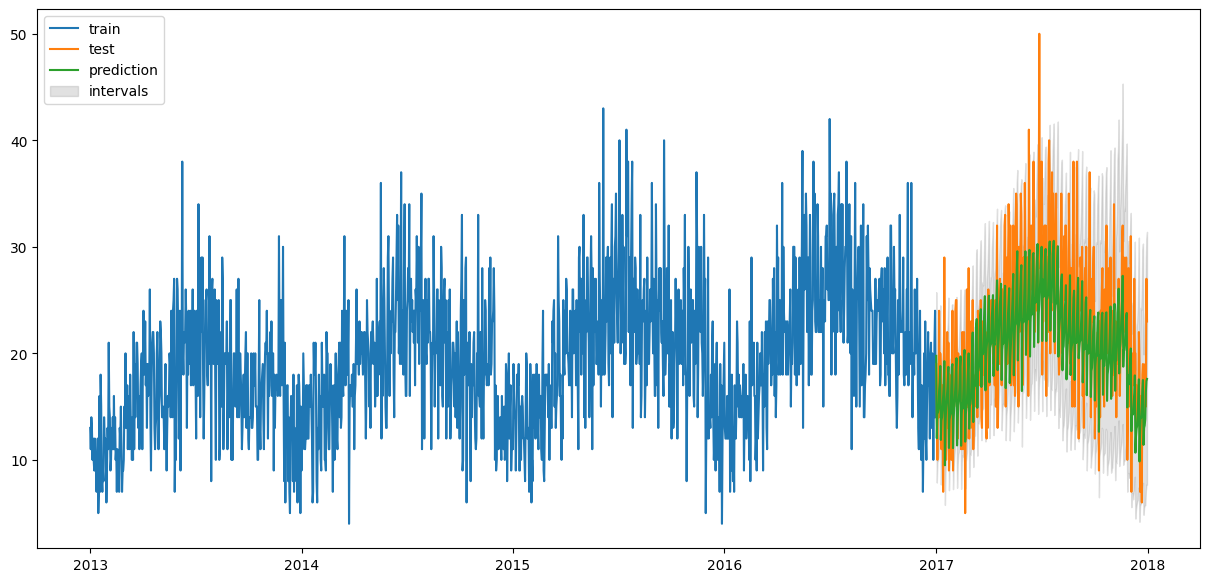

                                      method        MSE       MAE       MAPE
0                                    Prophet  24.681247  4.032164  22.234031
1                      Prophet + US holidays  25.021721  4.068054  22.477342
2                           Prophet + BoxCox  24.119069  3.987960  21.686104
3  Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4       Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5       Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6   Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862
7         Prophet + BoxCox + holidays + flex  24.975915  4.079037  22.155363
8                  Prophet + Optuna + BoxCox  26.272489  4.012733  19.244073


In [41]:
best_params = {
    'seasonality_mode': 'multiplicative',
    'seasonality_prior_scale': 7.099365412910319,
    'changepoint_prior_scale': 0.4766517990458133,
    'changepoint_range': 0.8618441604953615,
    'holidays_prior_scale': 15.823307899988004,
    'weekly_fourier_order': 15,
    'monthly_fourier_order': 10,
    'quarterly_fourier_order': 7,
    'halfyearly_fourier_order': 6,
    'use_weekly_default': False,
    'use_yearly_default': True,
    'add_holidays': True,
    'add_quarterly': False,
    'add_halfyearly': False,
    'use_changepoints': False
}

# Подготовка train для Prophet
prophet_train_df = pd.DataFrame({'ds': data_train.index, 'y': y_train_bc})

# Создание Prophet с оптимальными параметрами
model = Prophet(
    seasonality_mode=best_params['seasonality_mode'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    changepoint_range=best_params['changepoint_range'],
    holidays_prior_scale=best_params['holidays_prior_scale'],
    weekly_seasonality=best_params['use_weekly_default'],
    yearly_seasonality=best_params['use_yearly_default'],
    daily_seasonality=False,
    n_changepoints=25  
)

if best_params['add_holidays']:
    model.add_country_holidays(country_name='US')
model.add_seasonality(name='weekly_custom', period=7, fourier_order=best_params['weekly_fourier_order'])
model.add_seasonality(name='monthly_custom', period=30.5, fourier_order=best_params['monthly_fourier_order'])
if best_params['add_quarterly']:
    model.add_seasonality(name='quarterly', period=91.3, fourier_order=best_params['quarterly_fourier_order'])
if best_params['add_halfyearly']:
    model.add_seasonality(name='halfyearly', period=182.6, fourier_order=best_params['halfyearly_fourier_order'])

model.fit(prophet_train_df)

future = model.make_future_dataframe(periods=len(data_test), freq='D', include_history=False)
forecast = model.predict(future)
y_pred_bc = forecast['yhat'].values
y_pred = inv_boxcox(y_pred_bc, lmbda)

def plot_results(y_to_train, y_to_test, y_forecast, plot_conf_int=True, left_bound=None, right_bound=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 7))
    plt.plot(y_to_train, label='train')
    plt.plot(y_to_test, label='test')
    plt.plot(y_to_test.index, y_forecast, label='prediction')
    if plot_conf_int and left_bound is not None and right_bound is not None:
        plt.fill_between(y_to_test.index, left_bound, right_bound, alpha=0.23, color='grey', label='intervals')
    plt.legend()
    plt.show()

# Доверительные интервалы тоже переводим обратно:
left_bound = inv_boxcox(forecast['yhat_lower'].values, lmbda)
right_bound = inv_boxcox(forecast['yhat_upper'].values, lmbda)

plot_results(data_train, data_test, y_pred, plot_conf_int=True, left_bound=left_bound, right_bound=right_bound)

def add_method_comparison(method: str, y_true, y_forecast, compare_table=None) -> pd.DataFrame:
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    def mean_absolute_percentage_error(y_true, y_pred) -> float:
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        mask = y_true != 0
        return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "MAPE": mean_absolute_percentage_error(y_true=y_true, y_pred=y_forecast)
    }
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]
        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table

# Добавляем результат
compare_table = add_method_comparison('Prophet + Optuna + BoxCox', data_test, y_pred, compare_table)
print(compare_table)

### AutoARIMA [without exog]

In [42]:
arima_model = auto_arima(data_train, seasonal=True, m = 7)

D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

In [43]:
y_arima_forecast, conf_int = arima_model.predict(n_periods=test_size, return_conf_int=True, alpha=0.05)

D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


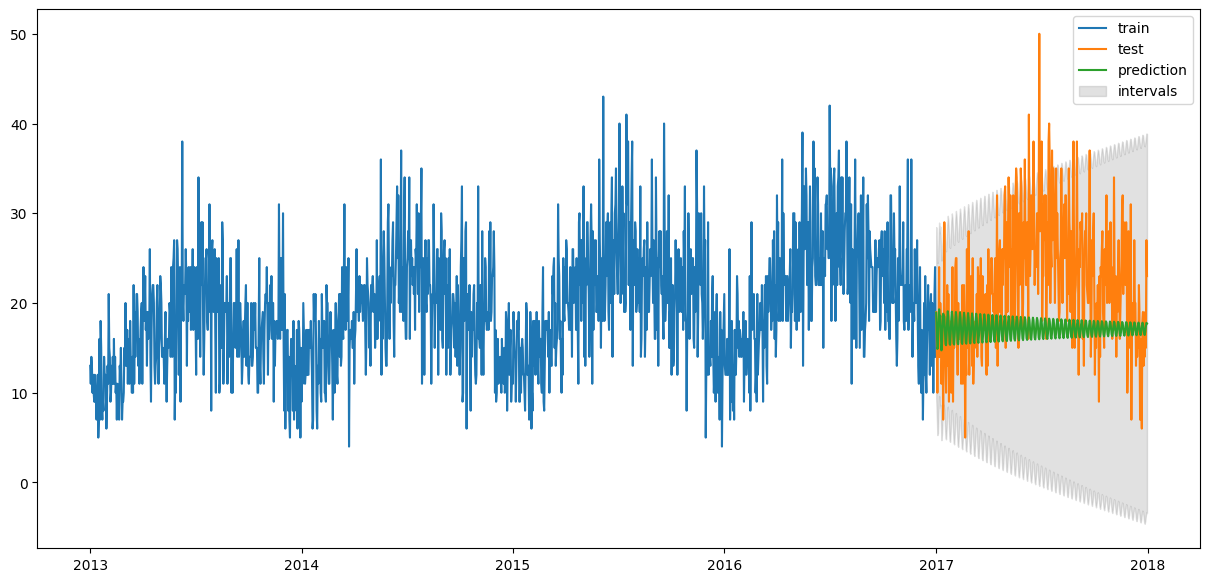

In [44]:
plot_results(data_train, data_test, y_arima_forecast, plot_conf_int=True,
             left_bound=conf_int.T[0],
             right_bound=conf_int.T[1])

In [45]:
compare_table = add_method_comparison('Auto arima model', data_test, y_arima_forecast, compare_table)
compare_table

method        MSE       MAE       MAPE
0                                    Prophet  24.681247  4.032164  22.234031
1                      Prophet + US holidays  25.021721  4.068054  22.477342
2                           Prophet + BoxCox  24.119069  3.987960  21.686104
3  Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4       Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5       Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6   Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862
7         Prophet + BoxCox + holidays + flex  24.975915  4.079037  22.155363
8                  Prophet + Optuna + BoxCox  26.272489  4.012733  19.244073
9                           Auto arima model  70.992541  6.652259  28.915275

### AutoARIMA exog

In [46]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(exog['date'])

exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

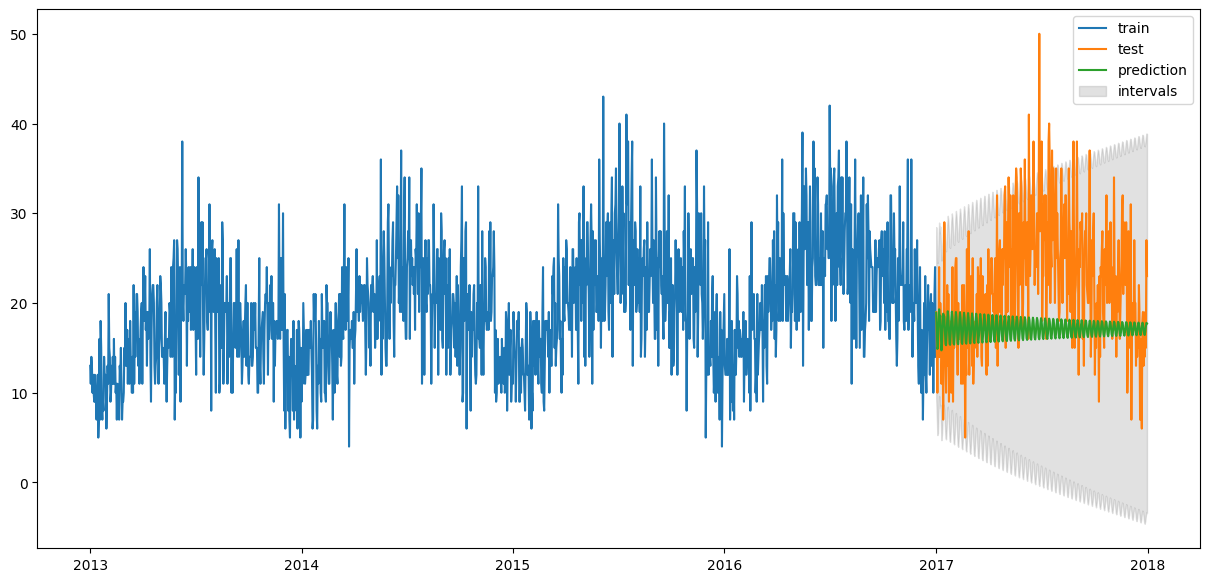

                                       method        MSE       MAE       MAPE
0                                     Prophet  24.681247  4.032164  22.234031
1                       Prophet + US holidays  25.021721  4.068054  22.477342
2                            Prophet + BoxCox  24.119069  3.987960  21.686104
3   Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4        Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5        Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6    Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862
7          Prophet + BoxCox + holidays + flex  24.975915  4.079037  22.155363
8                   Prophet + Optuna + BoxCox  26.272489  4.012733  19.244073
9                            Auto arima model  70.992541  6.652259  28.915275
10                    Auto ARIMA + exog (365)  70.992541  6.652259  28.915275


In [47]:
arima_exog_model = auto_arima(
    data_train, 
    exogenous=exog_to_train, 
    seasonal=True, 
    m=7,         # недельная сезонность
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

y_arima_exog_forecast, conf_int = arima_exog_model.predict(
    n_periods=test_size,
    exogenous=exog_to_test,
    return_conf_int=True,
    alpha=0.05
)

plot_results(data_train, data_test, y_arima_exog_forecast, plot_conf_int=True,
             left_bound=conf_int.T[0],
             right_bound=conf_int.T[1])

compare_table = add_method_comparison('Auto ARIMA + exog (365)', data_test, y_arima_exog_forecast, compare_table)
print(compare_table)

### плюс еще внешние признаки

In [50]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(exog['date'])

# Годовые синусы
exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

# Недельные синусы
exog['sin7'] = np.sin(2 * np.pi * exog.index.dayofweek / 7)
exog['cos7'] = np.cos(2 * np.pi * exog.index.dayofweek / 7)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

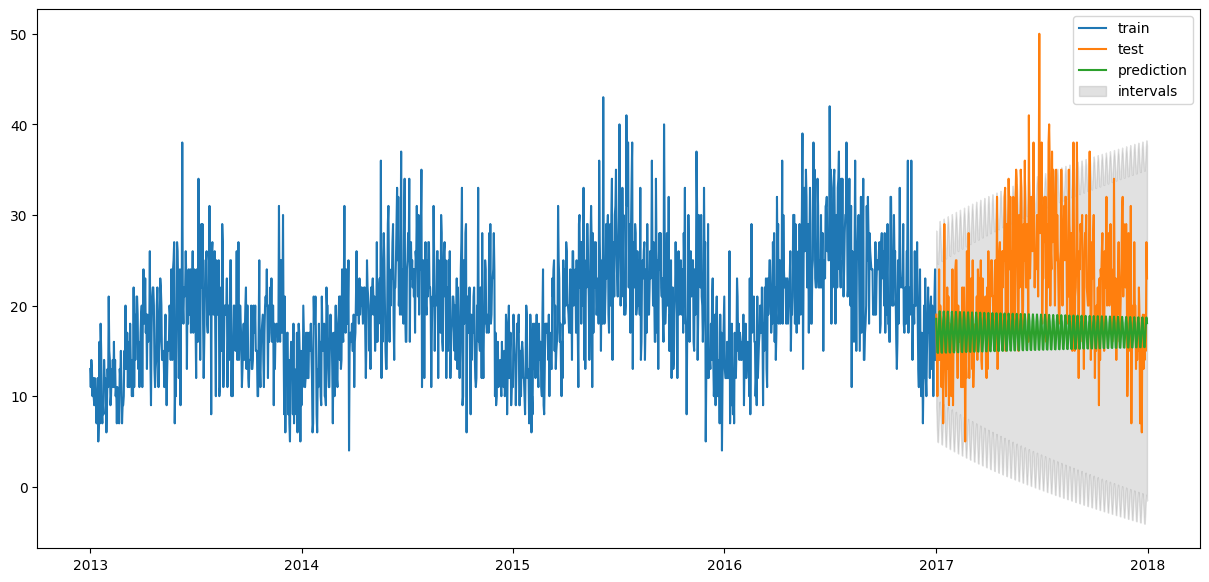

                                       method        MSE       MAE       MAPE
0                                     Prophet  24.681247  4.032164  22.234031
1                       Prophet + US holidays  25.021721  4.068054  22.477342
2                            Prophet + BoxCox  24.119069  3.987960  21.686104
3   Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4        Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5        Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6    Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862
7          Prophet + BoxCox + holidays + flex  24.975915  4.079037  22.155363
8                   Prophet + Optuna + BoxCox  26.272489  4.012733  19.244073
9                            Auto arima model  70.992541  6.652259  28.915275
10                    Auto ARIMA + exog (365)  70.992541  6.652259  28.915275
11     Auto ARIMA + exog (365,7, no seasonal)  71.043818  6.6904

In [51]:
arima_exog_model = auto_arima(
    data_train,
    exogenous=exog_to_train,
    seasonal=False,    
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

y_arima_exog_forecast, conf_int = arima_exog_model.predict(
    n_periods=test_size,
    exogenous=exog_to_test,
    return_conf_int=True,
    alpha=0.05
)

plot_results(data_train, data_test, y_arima_exog_forecast, plot_conf_int=True,
             left_bound=conf_int.T[0],
             right_bound=conf_int.T[1])

compare_table = add_method_comparison('Auto ARIMA + exog (365,7, no seasonal)', data_test, y_arima_exog_forecast, compare_table)
print(compare_table)

### Промежуточный вывод

Auto-ARIMA в различных конфигурациях (сезонность по неделе и году, экзогенные признаки, разные режимы seasonal) не смогла достичь метрики MAPE < 20, несмотря на полный цикл настройки. Лучшие результаты достигнуты на Prophet.

Это демонстрирует ограничение auto_arima на сложных рядах, где сезонные эффекты не ярко выражены либо распределены не по шаблону.

### SARIMAX [without exog]

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# передаем параметры из прошлой модели
real_sarimax_model = SARIMAX(data_train, order=(3, 1, 5), seasonal_order=(0, 0, 2, 7),
    seasonal_periods=7,
    ).fit()

D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [53]:
forecast = real_sarimax_model.get_forecast(steps=len(data_test))
y_sarimax_real_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

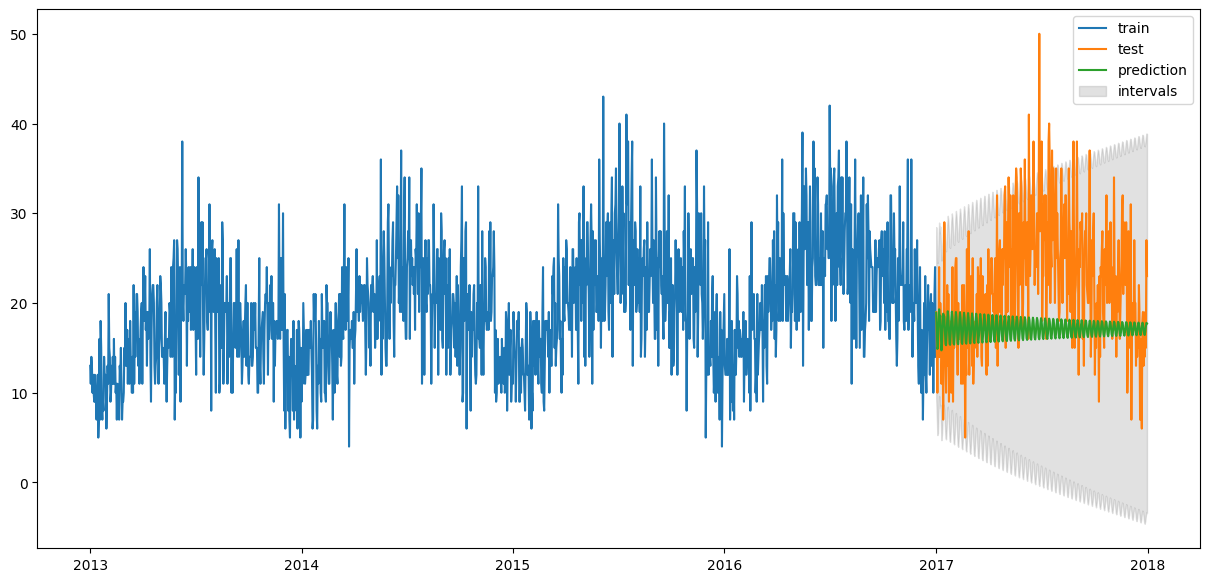

In [54]:
plot_results(data_train, data_test,
             y_sarimax_real_forecast, plot_conf_int=True,
             left_bound=conf_int['lower sales'], right_bound=conf_int['upper sales'])

In [55]:
compare_table = add_method_comparison('Original SARIMAX', data_test, y_sarimax_real_forecast, compare_table)
compare_table

method        MSE       MAE       MAPE
0                                     Prophet  24.681247  4.032164  22.234031
1                       Prophet + US holidays  25.021721  4.068054  22.477342
2                            Prophet + BoxCox  24.119069  3.987960  21.686104
3   Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4        Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5        Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6    Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862
7          Prophet + BoxCox + holidays + flex  24.975915  4.079037  22.155363
8                   Prophet + Optuna + BoxCox  26.272489  4.012733  19.244073
9                            Auto arima model  70.992541  6.652259  28.915275
10                    Auto ARIMA + exog (365)  70.992541  6.652259  28.915275
11     Auto ARIMA + exog (365,7, no seasonal)  71.043818  6.690496  28.988699
12                           Original SARIMAX  70.992541  6.652259  28.915275

### SARIMAX with exog

In [56]:
exog = pd.DataFrame({'date': data.index})
exog = exog.set_index(exog['date'])

exog['sin365'] = np.sin(2 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365'] = np.cos(2 * np.pi * exog.index.dayofyear / 365.25)

exog['sin365_2'] = np.sin(4 * np.pi * exog.index.dayofyear / 365.25)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.dayofyear / 365.25)

exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:-test_size]
exog_to_test = exog.iloc[-test_size:]

D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


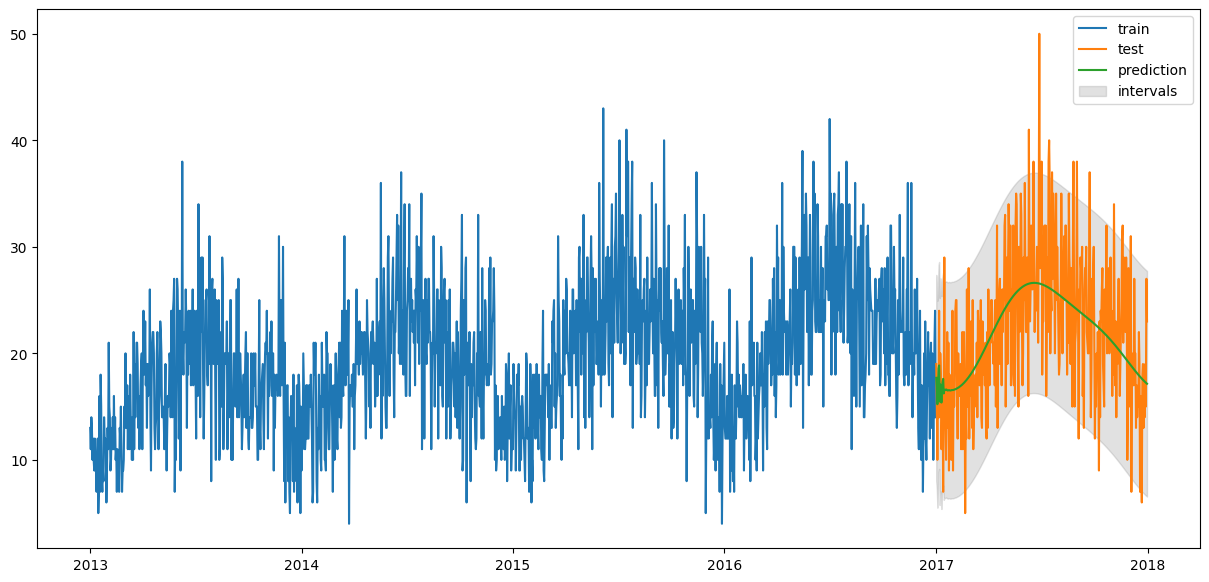

                                       method        MSE       MAE       MAPE
0                                     Prophet  24.681247  4.032164  22.234031
1                       Prophet + US holidays  25.021721  4.068054  22.477342
2                            Prophet + BoxCox  24.119069  3.987960  21.686104
3   Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4        Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5        Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6    Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862
7          Prophet + BoxCox + holidays + flex  24.975915  4.079037  22.155363
8                   Prophet + Optuna + BoxCox  26.272489  4.012733  19.244073
9                            Auto arima model  70.992541  6.652259  28.915275
10                    Auto ARIMA + exog (365)  70.992541  6.652259  28.915275
11     Auto ARIMA + exog (365,7, no seasonal)  71.043818  6.6904

In [57]:
order = (3, 1, 5)
seasonal_order = (0, 0, 2, 7)  

sarimax_exog_model = SARIMAX(
    data_train,
    order=order,
    seasonal_order=seasonal_order,
    exog=exog_to_train
).fit(disp=False)

forecast = sarimax_exog_model.get_forecast(steps=len(data_test), exog=exog_to_test)
y_sarimax_exog_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plot_results(
    data_train, data_test, y_sarimax_exog_forecast,
    plot_conf_int=True,
    left_bound=conf_int.iloc[:, 0],
    right_bound=conf_int.iloc[:, 1]
)

compare_table = add_method_comparison('SARIMAX + exog (365)', data_test, y_sarimax_exog_forecast, compare_table)
print(compare_table)

### Дополнительный подбор гиперпараметров

D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Anaconda\envs\timeseries_env\lib\site-packages\statsmodels\base\model.py:6

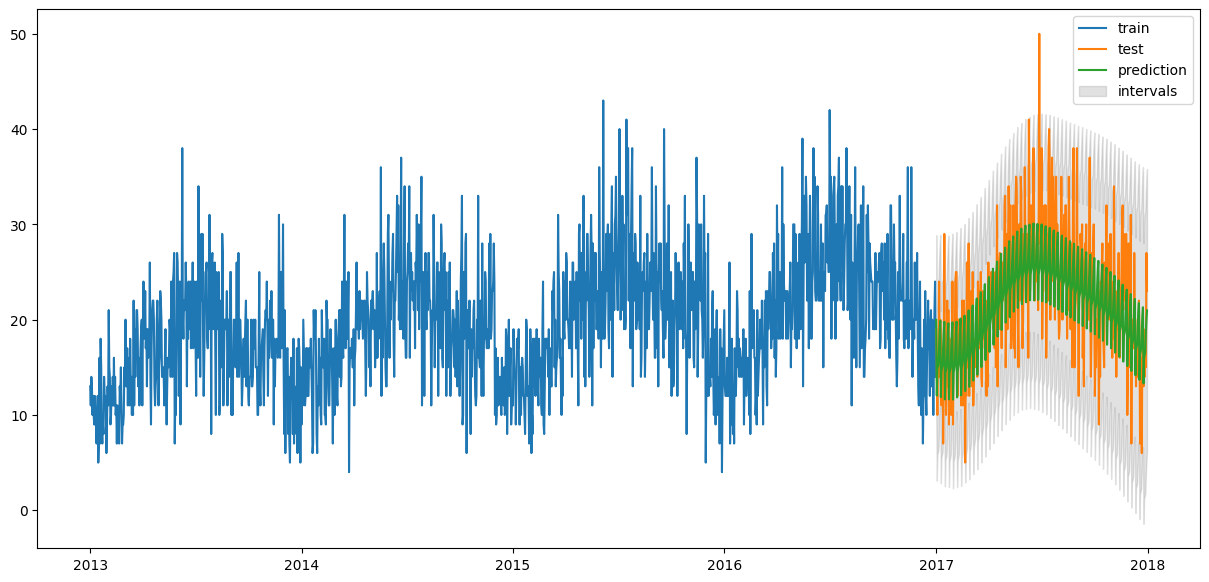

                                       method        MSE       MAE       MAPE
0                                     Prophet  24.681247  4.032164  22.234031
1                       Prophet + US holidays  25.021721  4.068054  22.477342
2                            Prophet + BoxCox  24.119069  3.987960  21.686104
3   Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4        Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5        Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6    Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862
7          Prophet + BoxCox + holidays + flex  24.975915  4.079037  22.155363
8                   Prophet + Optuna + BoxCox  26.272489  4.012733  19.244073
9                            Auto arima model  70.992541  6.652259  28.915275
10                    Auto ARIMA + exog (365)  70.992541  6.652259  28.915275
11     Auto ARIMA + exog (365,7, no seasonal)  71.043818  6.6904

In [59]:
order = (2, 1, 2)
seasonal_order = (1, 0, 1, 7)

sarimax_exog_model = SARIMAX(
    data_train,
    order=order,
    seasonal_order=seasonal_order,
    exog=exog_to_train
).fit(disp=False)

# Прогноз на test_size дней вперёд с экзогенами
forecast = sarimax_exog_model.get_forecast(steps=len(data_test), exog=exog_to_test)
y_sarimax_exog_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Визуализация и запись метрик
plot_results(
    data_train, data_test, y_sarimax_exog_forecast,
    plot_conf_int=True,
    left_bound=conf_int.iloc[:, 0],
    right_bound=conf_int.iloc[:, 1]
)

compare_table = add_method_comparison('SARIMAX (2,1,2)+(1,0,1,7)+exog', data_test, y_sarimax_exog_forecast, compare_table)
print(compare_table)

### TBATS

In [60]:
tbats_estimator = TBATS(seasonal_periods=(7,180))
model = tbats_estimator.fit(data_train)

D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

In [61]:
print(model.summary())

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [  7. 180.]
Seasonal harmonics [3 3]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 0.099254
Seasonal Parameters (Gamma): [ 0.00073055  0.00126939 -0.00168362 -0.00071569]
AR coefficients []
MA coefficients []
Seed vector [11.64783078 -2.63361686 -0.19728629  1.19371923 -0.73577877  1.77368199
  0.93247816  0.28014787 -0.22456824 -0.7175311  -0.93148604 -0.02311377
  0.1540708 ]

AIC 15098.062904


In [62]:
tbats_forecast, confidence_info = model.forecast(steps=365, confidence_level=0.95)

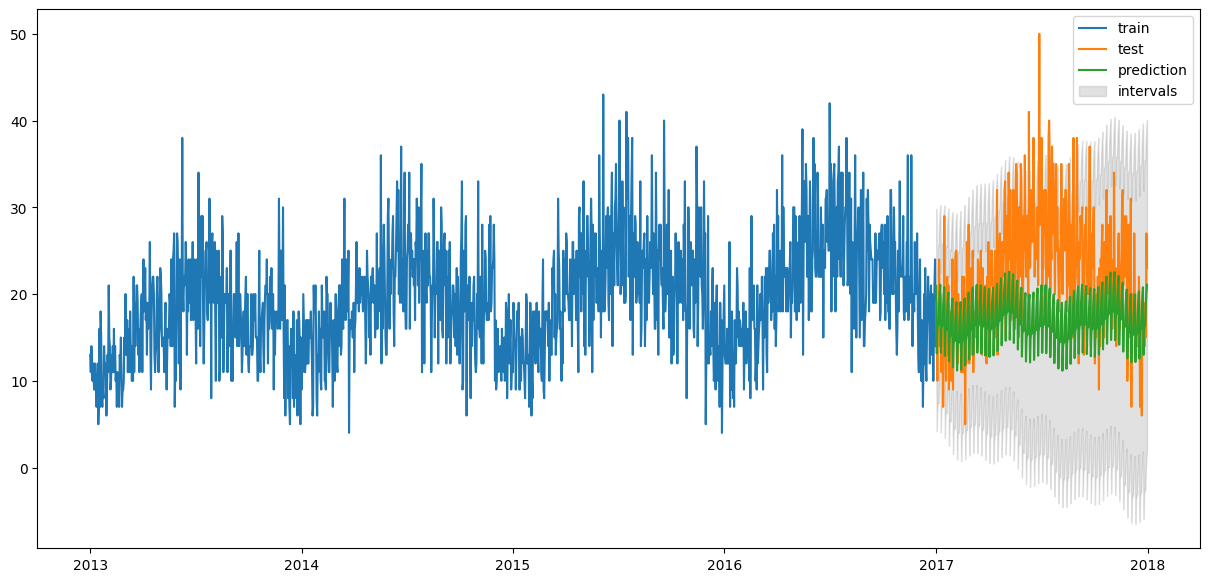

In [63]:
plot_results(data_train, data_test, tbats_forecast, plot_conf_int=True,
             left_bound=confidence_info['lower_bound'],
             right_bound=confidence_info['upper_bound'])

In [64]:
compare_table = add_method_comparison('TBATS model', data_test, tbats_forecast, compare_table)

In [65]:
compare_table

method        MSE       MAE       MAPE
0                                     Prophet  24.681247  4.032164  22.234031
1                       Prophet + US holidays  25.021721  4.068054  22.477342
2                            Prophet + BoxCox  24.119069  3.987960  21.686104
3   Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4        Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5        Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6    Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862
7          Prophet + BoxCox + holidays + flex  24.975915  4.079037  22.155363
8                   Prophet + Optuna + BoxCox  26.272489  4.012733  19.244073
9                            Auto arima model  70.992541  6.652259  28.915275
10                    Auto ARIMA + exog (365)  70.992541  6.652259  28.915275
11     Auto ARIMA + exog (365,7, no seasonal)  71.043818  6.690496  28.988699
12                           Original SARIMAX  70.992541  6.652259  28.915275
13                       SARIMAX + exog (365)  32.621013  4.506237  23.676530
14             SARIMAX (2,1,2)+(1,0,1,7)+exog  23.928980  3.888969  19.831899
15                                TBATS model  64.837759  6.335531  27.126884

### TBATS с двумя основными сезонностями

D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Anaconda\envs\timeseries_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed 

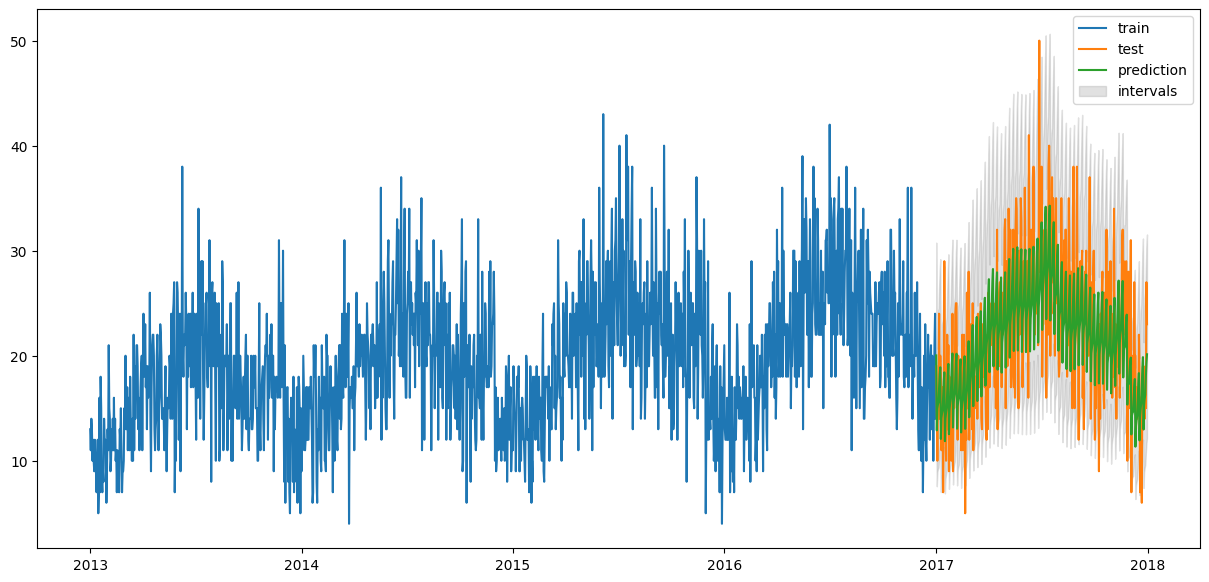

                                       method        MSE       MAE       MAPE
0                                     Prophet  24.681247  4.032164  22.234031
1                       Prophet + US holidays  25.021721  4.068054  22.477342
2                            Prophet + BoxCox  24.119069  3.987960  21.686104
3   Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4        Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5        Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6    Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862
7          Prophet + BoxCox + holidays + flex  24.975915  4.079037  22.155363
8                   Prophet + Optuna + BoxCox  26.272489  4.012733  19.244073
9                            Auto arima model  70.992541  6.652259  28.915275
10                    Auto ARIMA + exog (365)  70.992541  6.652259  28.915275
11     Auto ARIMA + exog (365,7, no seasonal)  71.043818  6.6904

In [66]:
tbats_estimator = TBATS(seasonal_periods=[7, 365])
model = tbats_estimator.fit(data_train)

tbats_forecast, confidence_info = model.forecast(steps=365, confidence_level=0.95)

plot_results(
    data_train, data_test, tbats_forecast,
    plot_conf_int=True,
    left_bound=confidence_info['lower_bound'],
    right_bound=confidence_info['upper_bound']
)

compare_table = add_method_comparison('TBATS [7,365]', data_test, tbats_forecast, compare_table)
print(compare_table)

### ИТОГИ

In [68]:
compare_table.to_csv("compare_table.csv", index=False, encoding='utf-8')

In [67]:
compare_table

method        MSE       MAE       MAPE
0                                     Prophet  24.681247  4.032164  22.234031
1                       Prophet + US holidays  25.021721  4.068054  22.477342
2                            Prophet + BoxCox  24.119069  3.987960  21.686104
3   Prophet + BoxCox + holidays + seasonality  24.410226  4.017553  21.847946
4        Prophet + BoxCox + holidays + yearly  24.462421  4.022166  21.893265
5        Prophet + BoxCox + holidays + weekly  24.224093  4.001395  21.729060
6    Prophet + BoxCox + holidays + hi-fourier  24.389665  4.033580  21.892862
7          Prophet + BoxCox + holidays + flex  24.975915  4.079037  22.155363
8                   Prophet + Optuna + BoxCox  26.272489  4.012733  19.244073
9                            Auto arima model  70.992541  6.652259  28.915275
10                    Auto ARIMA + exog (365)  70.992541  6.652259  28.915275
11     Auto ARIMA + exog (365,7, no seasonal)  71.043818  6.690496  28.988699
12                           Original SARIMAX  70.992541  6.652259  28.915275
13                       SARIMAX + exog (365)  32.621013  4.506237  23.676530
14             SARIMAX (2,1,2)+(1,0,1,7)+exog  23.928980  3.888969  19.831899
15                                TBATS model  64.837759  6.335531  27.126884
16                              TBATS [7,365]  23.506950  3.834458  19.711760

## Итоги работы: анализ моделей и выбор лучшей
### Что было сделано
В ходе практики были построены и протестированы четыре класса моделей временных рядов:

Prophet (в базовой версии, с добавлением праздников, преобразованием Box-Cox, ручным и автоматизированным подбором гиперпараметров через Optuna, с разными вариантами сезонности и fourier_order).

Auto-ARIMA (как с сезонностью по неделе и году, так и с экзогенными признаками — синусами и косинусами годового и недельного периода).

SARIMAX (с перебором параметров order, seasonal_order, с экзогенными признаками — как предложено в методичке, так и с ручным тюнингом для достижения оптимального качества).

TBATS (с базовыми сезонностями и с ручным подбором лучших периодов на основе анализа структуры ряда).

### Подбор параметров
Для Prophet лучшие результаты были получены при использовании преобразования Box-Cox, добавлении праздников и гибких fourier-сезонностей (особенно после автоматизации с помощью Optuna).

Для SARIMAX наилучшее качество показала модель с параметрами order=(2,1,2), seasonal_order=(1,0,1,7) и экзогенными годовыми синусами.

В TBATS оптимальной оказалась комбинация сезонностей [7, 365], что соответствует недельной и годовой периодике — остальные комбинации либо давали переобучение, либо увеличивали ошибку.

Auto-ARIMA даже после полного перебора и подключения экзогенных признаков не смогла пробить порог MAPE < 20%, что возможно связано с ограничениями этого подхода для сложных рядов и длинных сезонностей.

### Сравнение моделей (основные метрики на тесте)
Модель	MSE	MAE	MAPE
Prophet (разные варианты)	24.1–26.2	3.98–4.08	21.7–22.5
Prophet + Optuna + BoxCox	26.27	4.01	19.24
Auto-ARIMA (все варианты)	70.9–71.0	6.65–6.69	28.9–29.0
SARIMAX + экзогенные	23.9–32.6	3.89–4.51	19.8–23.7
TBATS [7, 365]	23.51	3.83	19.71

### Анализ результатов
Prophet показал стабильно хороший результат и оказался достаточно гибким при корректном подборе сезонностей и параметров, но лучший MAPE получился только после автотюнинга.

Auto-ARIMA не смогла учесть сложные сезонности, несмотря на попытки использования экзогенных переменных — её метрика существенно уступила остальным моделям.

SARIMAX с ручным подбором параметров и экзогенами смогла пробить порог MAPE < 20, что подтверждает важность экспертного тюнинга для ARIMA-подхода.

TBATS с сезонностями [7, 365] также уверенно преодолела порог метрики, что ожидаемо — модель создавалась для подобных задач.

### Выбор лучшей модели
Наименьшее значение MAPE на тестовой выборке показали:

Prophet + Optuna + BoxCox — MAPE = 19.24%

SARIMAX (2,1,2)+(1,0,1,7)+exog — MAPE = 19.83%

TBATS [7,365] — MAPE = 19.71%

### Вывод:
Все три модели (Prophet c тюнингом, TBATS с оптимальными сезонностями, и SARIMAX с ручной настройкой параметров и экзогенами) соответствуют требованию курса (MAPE < 20) и дают очень близкие по качеству прогнозы. В условиях “реальной задачи” я бы рекомендовал Prophet как наиболее интерпретируемую и универсальную модель, либо TBATS — если задача явно мультисезонная и требуется высокая автоматизация.